In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
#################### misc ####################
from collections import defaultdict
#################### sklearn START ####################
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report, PrecisionRecallDisplay
from sklearn.experimental import enable_iterative_imputer # is needed since data_processing_utils.py imports IterativeImputer
#################### sklearn END ####################
#################### imblearn START ####################
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
#################### imblearn END ####################
import tensorflow as tf
from xgboost import XGBClassifier, XGBRegressor
from utils.data_processing_utils import save_df, plot_splits_distribution, load_and_save_df_with_extra_features
from utils.data_analysis_utils import (plot_feature_skewness, plot_runners_dist, plot_splits_feature_dist, 
                                       plot_split_data_trend, plot_split_data_trend_by_cat, plot_non_finishers_by_cat)
from utils.model_utils import (load_and_concat_all_data, get_all_data, get_preprocessed_datasets, get_reg_preprocessed_datasets,
                               save_sklearn_model, load_sklearn_model, plot_confusion_matrix, 
                               plot_performance_comparison, plot_performance_distribution, plot_performance_diff)

## CONSTANTS:

In [2]:
YEAR_13: str = "2013"
YEAR_14: str = "2014"
YEAR_15: str = "2015"
YEAR_16: str = "2016"
YEAR_17: str = "2017"
YEAR_18: str = "2018"
YEAR_19: str = "2019"
YEAR_21: str = "2021"
YEAR_22: str = "2022"
YEAR_23: str = "2023"
YEARS: list[str] = [YEAR_13, YEAR_14, YEAR_15, YEAR_16, YEAR_17, YEAR_18, YEAR_19, YEAR_21, YEAR_22, YEAR_23]
SPLITS_KEYS: list[str] = ["k_5", "k_10", "k_15", "k_20", "k_half", "k_25", "k_30", "k_35", "k_40", "k_finish"]
SPLITS_NAMES: list[str] = ["5K", "10K", "15K", "20K", "Half", "25K", "30K", "35K", "40K", "Finish"]
SPLITS_ORDER: list[str] = ['k_5_time', 'k_5_pace', 'k_5_speed', 'k_10_time', 'k_10_pace', 'k_10_speed',
                           'k_15_time', 'k_15_pace', 'k_15_speed', 'k_20_time', 'k_20_pace', 'k_20_speed',
                           'k_half_time', 'k_half_pace', 'k_half_speed', 'k_25_time', 'k_25_pace', 'k_25_speed', 
                           'k_30_time', 'k_30_pace', 'k_30_speed', 'k_35_time', 'k_35_pace', 'k_35_speed',
                           'k_40_time', 'k_40_pace', 'k_40_speed', 'k_finish_time', 'k_finish_pace', 'k_finish_speed']

DTYPE_DICT: defaultdict = defaultdict(np.float64, age_cat="category", gender="category", 
                                      race_state="category", last_split="category", runner_type="category")
COLUMNS_ORDER = ['last_split', 'runner_type', 'age_cat', 'gender', 'race_state', 'daily_min', 
                'daily_max', 'medium_temp', 'avg_humidity', 'avg_barometer','avg_windspeed',
                '5k_dnf_pct', '10k_dnf_pct', '15k_dnf_pct', '20k_dnf_pct', 'half_dnf_pct', 
                '25k_dnf_pct', '30k_dnf_pct', '35k_dnf_pct', '40k_dnf_pct', 
                'k_5_time', 'k_5_pace', 'k_5_speed', 'k_10_time', 'k_10_pace', 'k_10_speed', 
                'k_15_time','k_15_pace', 'k_15_speed', 'k_20_time', 'k_20_pace', 'k_20_speed', 
                'k_half_time', 'k_half_pace', 'k_half_speed', 'k_25_time', 'k_25_pace', 'k_25_speed', 
                'k_30_time', 'k_30_pace', 'k_30_speed', 'k_35_time', 'k_35_pace', 'k_35_speed', 
                'k_40_time', 'k_40_pace', 'k_40_speed','k_finish_time', 'k_finish_pace', 'k_finish_speed']
CLASS_NAMES = ["Finished", "Started"]

In [3]:
RAW_DATA_PATH = "Marathons_Data/Raw"
CLN_DATA_PATH = "Marathons_Data/Clean"
IMP_DATA_PATH = "Marathons_Data/Impute"
OTHER_DATA_PATH = "Marathons_Data/Other"
EXTENDED_DATA_PATH = "Marathons_Data/Extended"
#################### Marathons START ####################
# London
LDN: str = "London"
LDN_RAW_PATH: str = f"{RAW_DATA_PATH}/{LDN}"
LDN_CLN_PATH: str = f"{CLN_DATA_PATH}/{LDN}"
LDN_IMP_PATH: str = f"{IMP_DATA_PATH}/{LDN}"
LDN_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{LDN}"
# Hamburg
HAM: str = "Hamburg"
HAM_RAW_PATH: str = f"{RAW_DATA_PATH}/{HAM}"
HAM_CLN_PATH: str = f"{CLN_DATA_PATH}/{HAM}"
HAM_IMP_PATH: str = f"{IMP_DATA_PATH}/{HAM}"
HAM_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{HAM}"
# Houston
HOU: str = "Houston"
HOU_RAW_PATH: str = f"{RAW_DATA_PATH}/{HOU}"
HOU_CLN_PATH: str = f"{CLN_DATA_PATH}/{HOU}"
HOU_IMP_PATH: str = f"{IMP_DATA_PATH}/{HOU}"
HOU_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{HOU}"
# Stockholm
STO: str = "Stockholm"
STO_RAW_PATH: str = f"{RAW_DATA_PATH}/{STO}"
STO_CLN_PATH: str = f"{CLN_DATA_PATH}/{STO}"
STO_IMP_PATH: str = f"{IMP_DATA_PATH}/{STO}"
STO_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{STO}"
# Boston
BOS: str = "Boston"
BOS_RAW_PATH: str = f"{RAW_DATA_PATH}/{BOS}"
BOS_CLN_PATH: str = f"{CLN_DATA_PATH}/{BOS}"
BOS_IMP_PATH: str = f"{IMP_DATA_PATH}/{BOS}"
BOS_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{BOS}"
# Chicago
CHI: str = "Chicago"
CHI_RAW_PATH: str = f"{RAW_DATA_PATH}/{CHI}"
CHI_CLN_PATH: str = f"{CLN_DATA_PATH}/{CHI}"
CHI_IMP_PATH: str = f"{IMP_DATA_PATH}/{CHI}"
CHI_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{CHI}"
# All Marathons
MARATHON_NAMES = [LDN, HAM, HOU, STO, BOS, CHI]
MARATHON_EXT_PATHS = [LDN_EXT_PATH, HAM_EXT_PATH, HOU_EXT_PATH, STO_EXT_PATH, BOS_EXT_PATH, CHI_EXT_PATH]
#################### Marathons END ####################
#################### Weather START ####################
WEATHER_DATA_PATH = f"{OTHER_DATA_PATH}/weather_marathon_data.csv"
WEATHER_COLS = ["daily_min", "daily_max", "medium_temp", "avg_humidity", "avg_barometer", "avg_windspeed"]
#################### Weather END ####################
#################### Model Save Paths START ####################
MODEL_CLASS_SAVE_NORMAL = "Models/Classification/Normal/"
MODEL_CLASS_SAVE_OVER = "Models/Classification/Oversampled/"
MODEL_CLASS_SAVE_HYBRID = "Models/Classification/Hybrid/"
MODEL_REG_SAVE_NORMAL = "Models/Regression/Normal/"
#################### Model Save Paths END ####################

## Feature Engineering (Only run if the Extended folder and its datasets do not exist):

In [4]:
# Load the weather data.
weather_df = pd.read_csv(WEATHER_DATA_PATH)

### London:

In [5]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(LDN, YEARS, LDN_IMP_PATH, LDN_EXT_PATH, weather_df, WEATHER_COLS, SPLITS_NAMES, DTYPE_DICT, COLUMNS_ORDER)

DataFrame not found at Marathons_Data/Impute/London/London2013/London2013_iter_impute.csv or Marathons_Data/Impute/London/London2013/London2013_knn_impute.csv.
DataFrame saved to Marathons_Data/Extended/London/London2014/London2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2014/London2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2015/London2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2015/London2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2016/London2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2016/London2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2017/London2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2017/London2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2018/London2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2018/London201

### Hamburg:

In [6]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(HAM, YEARS, HAM_IMP_PATH, HAM_EXT_PATH, weather_df, WEATHER_COLS, SPLITS_NAMES, DTYPE_DICT, COLUMNS_ORDER)

DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2013/Hamburg2013_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2013/Hamburg2013_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2014/Hamburg2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2014/Hamburg2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2015/Hamburg2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2015/Hamburg2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2016/Hamburg2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2016/Hamburg2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2017/Hamburg2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2017/Hamburg2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2018/Hamburg2018_iter_ext.csv.
DataFrame saved to Maratho

### Houston:

In [7]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(HOU, YEARS[5:7], HOU_IMP_PATH, HOU_EXT_PATH, weather_df, WEATHER_COLS, SPLITS_NAMES, DTYPE_DICT, COLUMNS_ORDER)

DataFrame saved to Marathons_Data/Extended/Houston/Houston2018/Houston2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Houston/Houston2018/Houston2018_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Houston/Houston2019/Houston2019_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Houston/Houston2019/Houston2019_knn_ext.csv.


### Stockholm:

In [8]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(STO, YEARS[7:9], STO_IMP_PATH, STO_EXT_PATH, weather_df, WEATHER_COLS, SPLITS_NAMES, DTYPE_DICT, COLUMNS_ORDER)

DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2021/Stockholm2021_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2021/Stockholm2021_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2022/Stockholm2022_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2022/Stockholm2022_knn_ext.csv.


### Boston:

In [9]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(BOS, YEARS, BOS_IMP_PATH, BOS_EXT_PATH, weather_df, WEATHER_COLS, SPLITS_NAMES, DTYPE_DICT, COLUMNS_ORDER)

DataFrame not found at Marathons_Data/Impute/Boston/Boston2013/Boston2013_iter_impute.csv or Marathons_Data/Impute/Boston/Boston2013/Boston2013_knn_impute.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2014/Boston2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2014/Boston2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2015/Boston2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2015/Boston2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2016/Boston2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2016/Boston2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2017/Boston2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2017/Boston2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2018/Boston2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2018/Boston201

### Chicago:

In [10]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(CHI, YEARS, CHI_IMP_PATH, CHI_EXT_PATH, weather_df, WEATHER_COLS, SPLITS_NAMES, DTYPE_DICT, COLUMNS_ORDER)

DataFrame not found at Marathons_Data/Impute/Chicago/Chicago2013/Chicago2013_iter_impute.csv or Marathons_Data/Impute/Chicago/Chicago2013/Chicago2013_knn_impute.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2014/Chicago2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2014/Chicago2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2015/Chicago2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2015/Chicago2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2016/Chicago2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2016/Chicago2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2017/Chicago2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2017/Chicago2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2018/Chicago2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Ext

## Data Analysis and Visualisation:

In [4]:
import os
# TODO Combine the function in utils.model_utils with this one.
def analysis_load_concat_all_data(marathon_name: str, parent_path: str, years: list[str], dataset_name: str=None, dataset_type:str ="impute", dtype=None) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]|pd.DataFrame:
    """
    ### Load and concatenate all the DataFrames.
    ----
    ### Arguments:
    + marathon_name: The name of the marathon.
    + parent_path: The path to load the DataFrames.
    + years: The years of the marathon.
    + dataset_name: The name of the dataset to return.
    + dtype: The data types of the DataFrame.
    + dataset_type: The type of the dataset, either the imputed `impute` or the extended `ext`.
    ----
    ### Returns:
    + data: The DataFrames, if `dataset_name` is None.
    + The specified DataFrame, if `dataset_name` is not None.
    """
    # Check the dataset type.
    assert dataset_type in ["impute", "ext"], "dataset_type must be either `impute` or `ext`."

    data = [[], []]
    for year in years:
        knn_path = f"{parent_path}/{marathon_name}{year}/{marathon_name}{year}_knn_{dataset_type}.csv"
        iter_path = f"{parent_path}/{marathon_name}{year}/{marathon_name}{year}_iter_{dataset_type}.csv"
        if os.path.isfile(knn_path) and os.path.isfile(iter_path):
            knn_df = pd.read_csv(knn_path, dtype=dtype)
            knn_df["year"] = year
            iter_df = pd.read_csv(iter_path, dtype=dtype)
            iter_df["year"] = year
            data[0].append(knn_df)
            data[1].append(iter_df)
            # data[0].append(pd.read_csv(knn_path, dtype=dtype))
            # data[1].append(pd.read_csv(iter_path, dtype=dtype))
        else:
            print(f"DataFrame not found at {knn_path} or {iter_path}.")
            continue
    # Concatenate all data
    data[0] = pd.concat(data[0], ignore_index=True)
    data[1] = pd.concat(data[1], ignore_index=True)
    if dataset_name:
        match dataset_name:
            case "knn":
                return data[0]
            case "iter":
                return data[1]
    return data

### The Whole Dataset:

In [4]:
df_data = get_all_data(MARATHON_NAMES, MARATHON_EXT_PATHS, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)

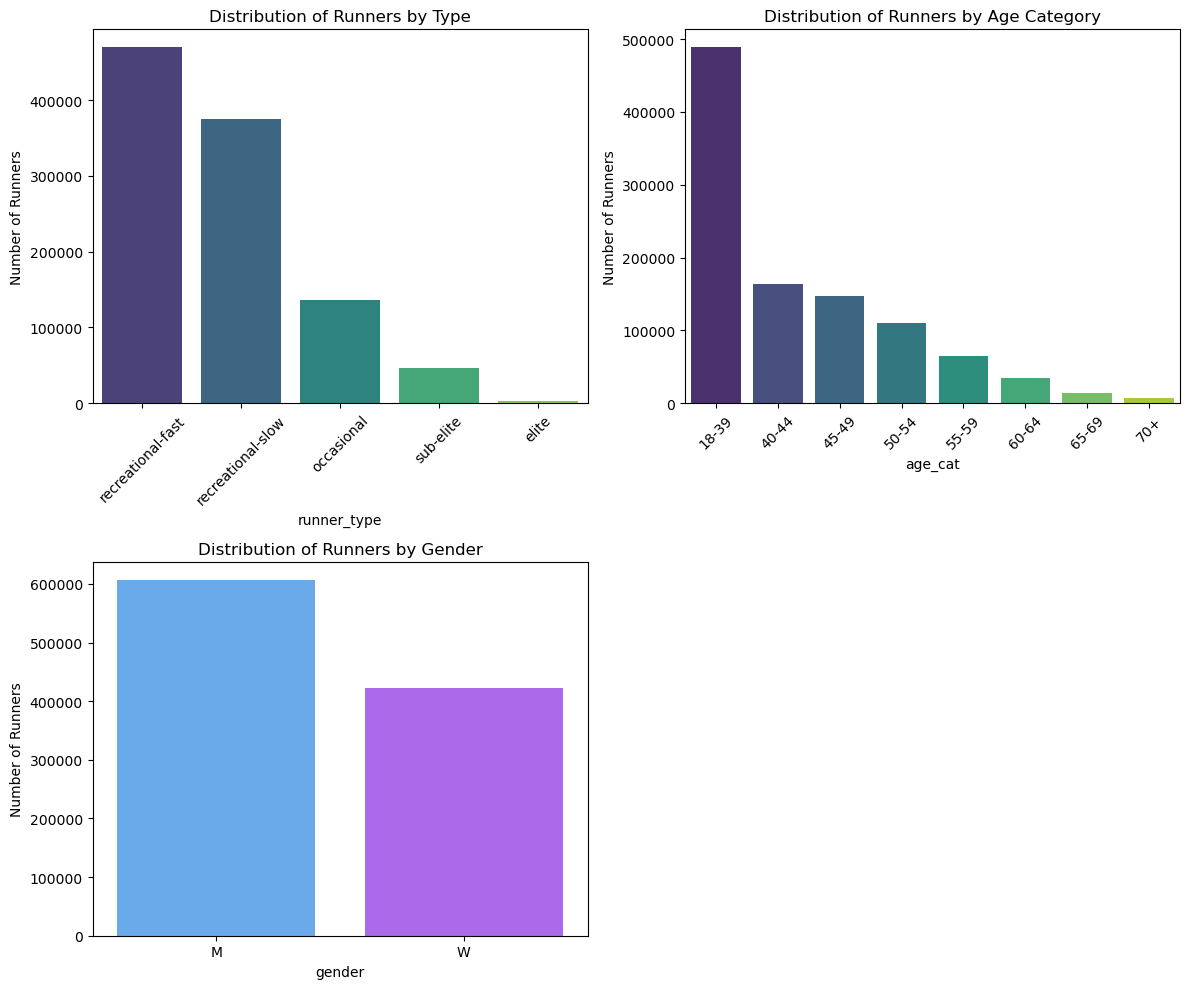

In [5]:
plot_runners_dist(df_data)

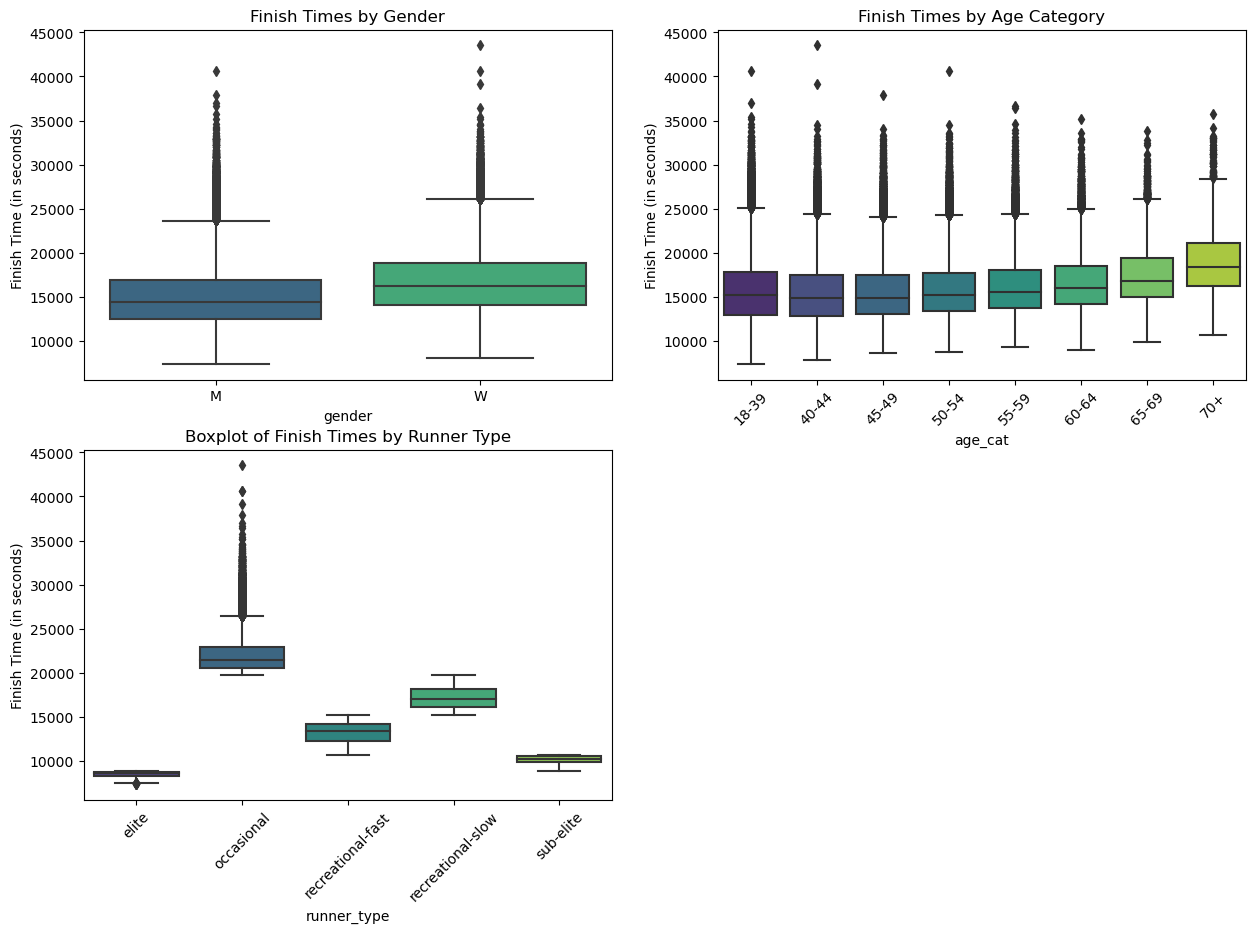

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(15, 10))

# Boxplot for finish times based on gender
plt.subplot(2, 2, 1)
sns.boxplot(data=df_data, x='gender', y='k_finish_time', palette='viridis')
plt.title('Finish Times by Gender')
plt.ylabel('Finish Time (in seconds)')

# Boxplot for finish times based on age_cat
plt.subplot(2, 2, 2)
sns.boxplot(data=df_data, x='age_cat', y='k_finish_time', palette='viridis')
plt.title('Finish Times by Age Category')
plt.xticks(rotation=45)
plt.ylabel('Finish Time (in seconds)')

# Boxplot for finish times based on runner_type
plt.subplot(2, 2, 3)
sns.boxplot(data=df_data, x="runner_type", y='k_finish_time', palette='viridis')
plt.title('Boxplot of Finish Times by Runner Type')
plt.xticks(rotation=45)
plt.ylabel('Finish Time (in seconds)')
plt.show()

plt.tight_layout()
plt.show()

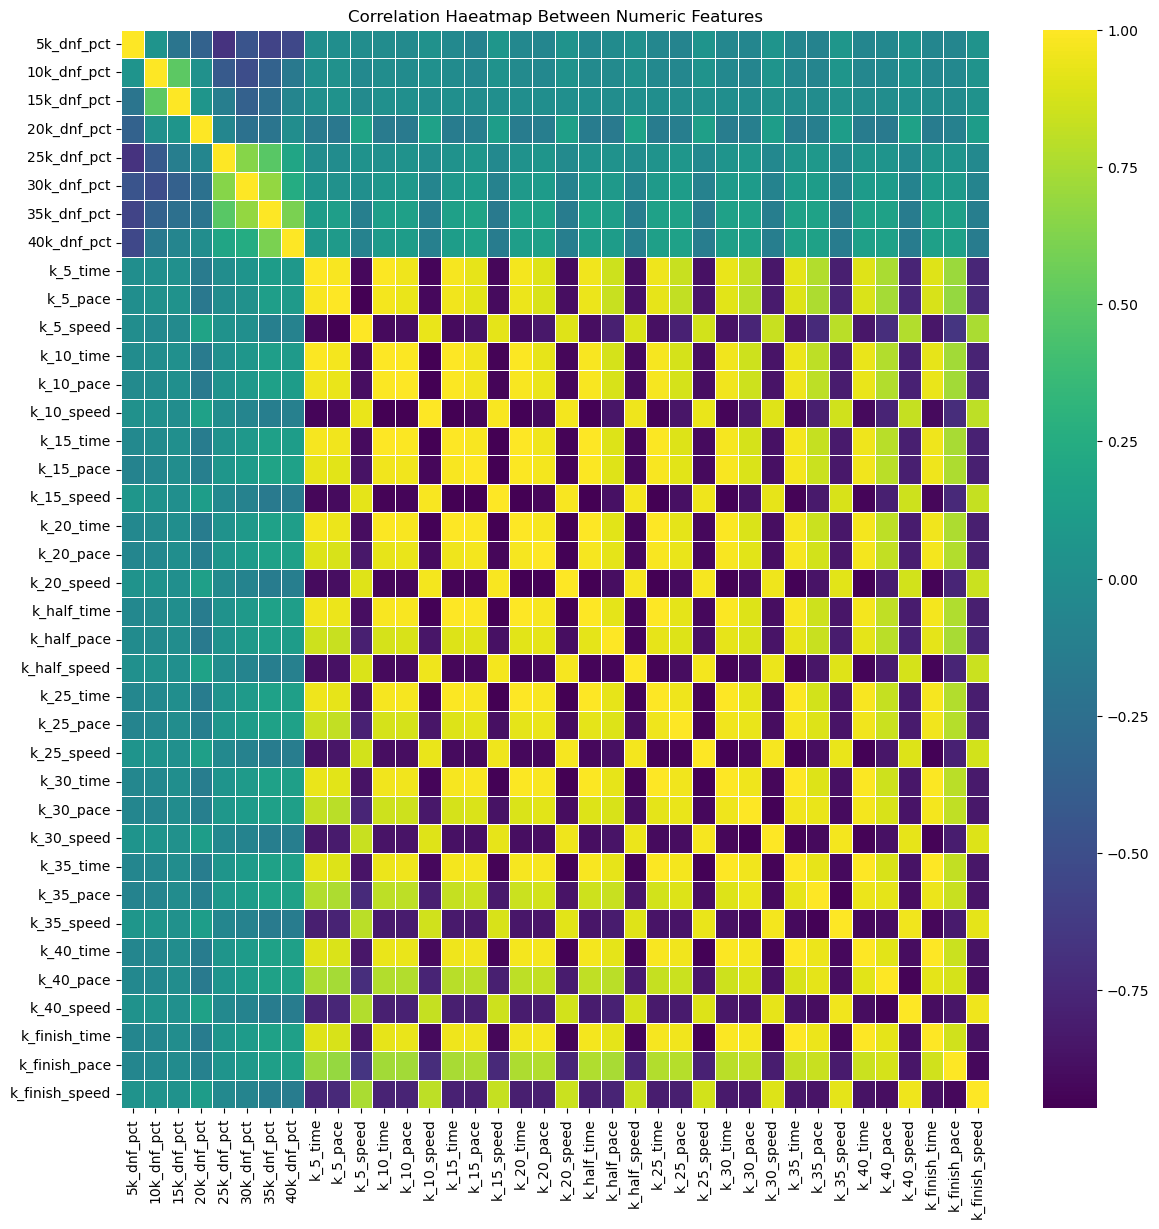

In [7]:
plt.figure(figsize=(14, 14))
sns.heatmap(df_data.filter(regex="k_.*_").corr(), cmap="viridis", linewidths=0.5)
plt.title("Correlation Haeatmap Between Numeric Features")
plt.show()

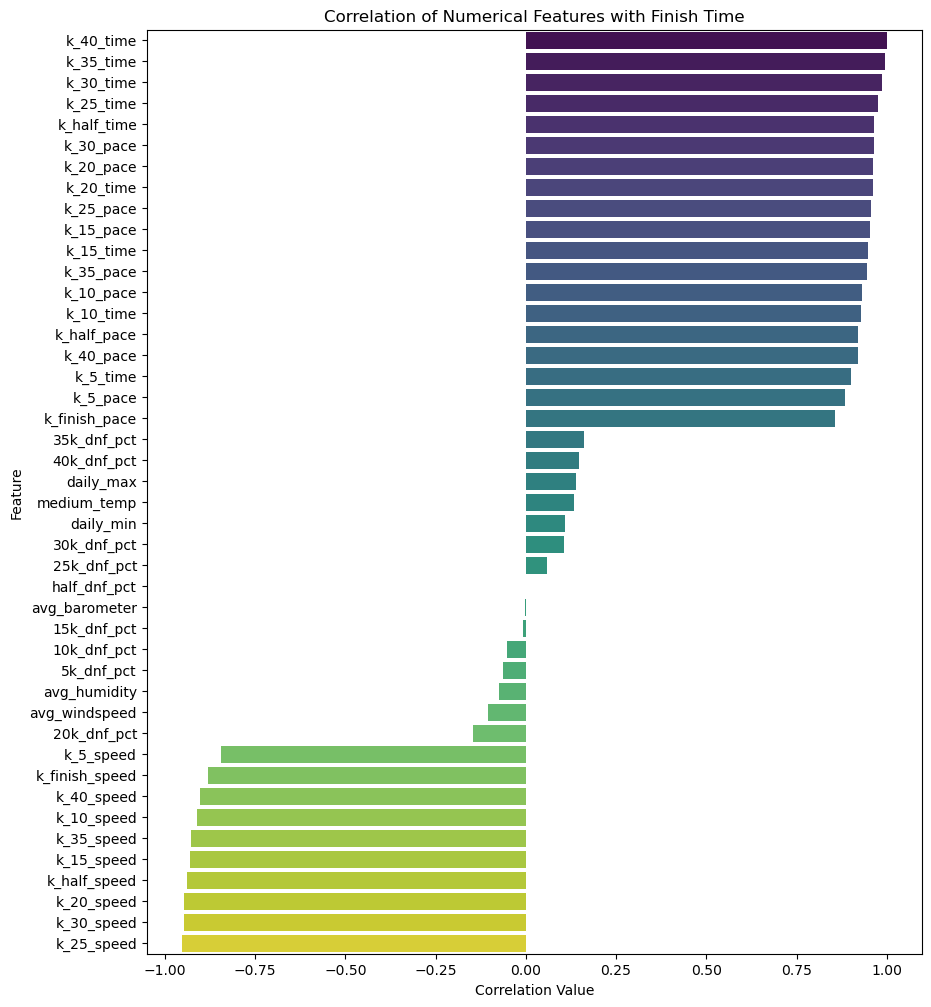

In [8]:
# Calculate the correlation between the other features and the finish time.
finish_time_corr = df_data.corr(numeric_only=True)["k_finish_time"].sort_values(ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(x=finish_time_corr.values[1:], y=finish_time_corr.index[1:], palette="viridis", orient="h");
plt.xlabel("Correlation Value")
plt.ylabel("Feature")
plt.title("Correlation of Numerical Features with Finish Time")
plt.show()

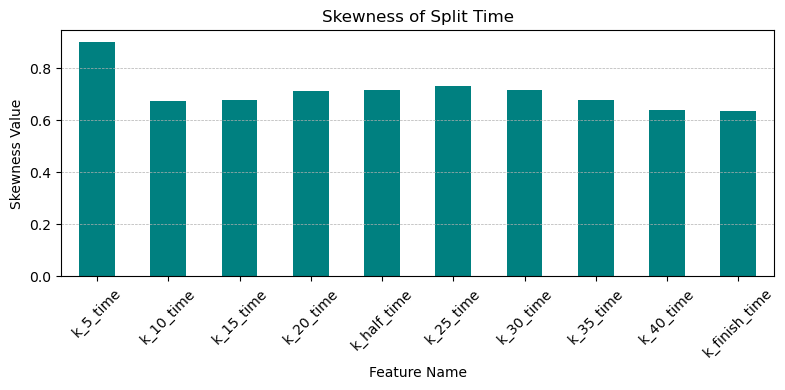

In [9]:
# Plot the skweness of the splits for the whole dataset.
plot_feature_skewness(df_data, 'time', fig_size=(8, 4))

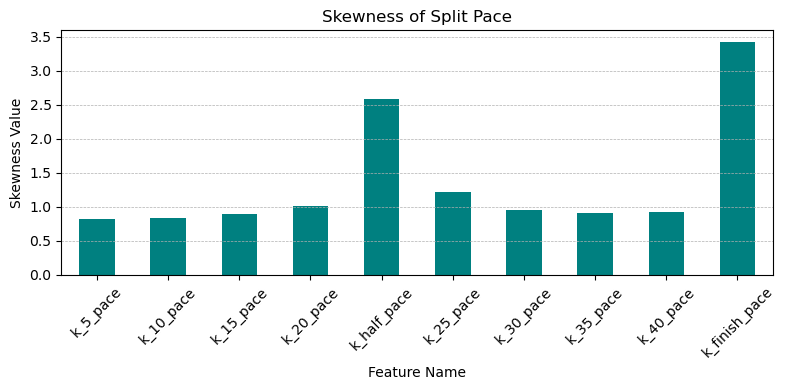

In [10]:
# Plot the skweness of the splits for the whole dataset.
plot_feature_skewness(df_data, 'pace', fig_size=(8, 4))

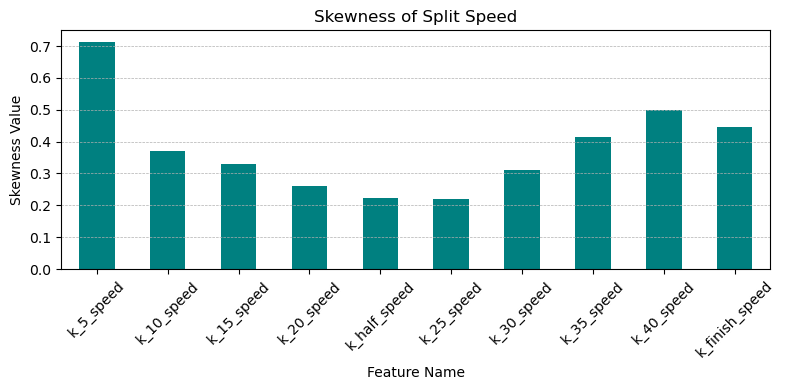

In [11]:
# Plot the skweness of the splits for the whole dataset.
plot_feature_skewness(df_data, 'speed', fig_size=(8, 4))

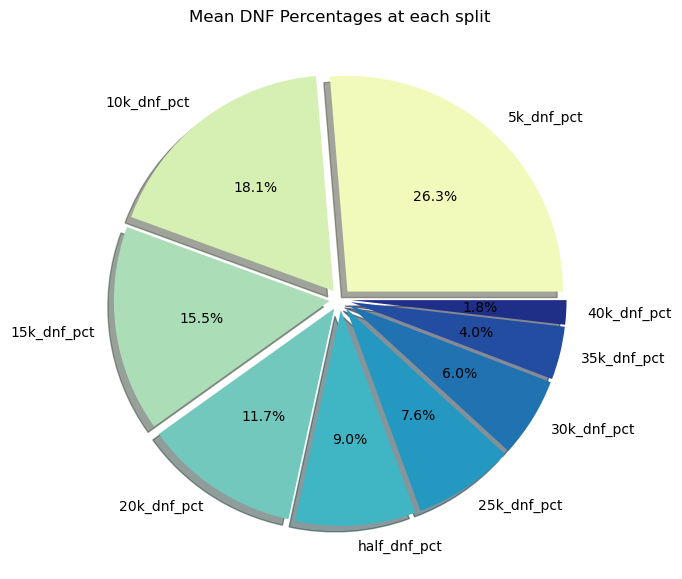

In [12]:
# Analyze DNF Percentages
# Extracting columns related to DNF percentages
dnf_columns = [col for col in df_data.columns if 'dnf_pct' in col]

# Calculating the mean DNF percentages for each split
plt.figure(figsize=(10,7))
dnf_percentages_mean = df_data[dnf_columns].mean()
plt.pie(dnf_percentages_mean, labels=dnf_percentages_mean.index, autopct='%1.1f%%', shadow=True, 
        explode=[0.05]*len(dnf_percentages_mean), colors=sns.color_palette("YlGnBu", len(dnf_percentages_mean)))
plt.title('Mean DNF Percentages at each split')
plt.show()

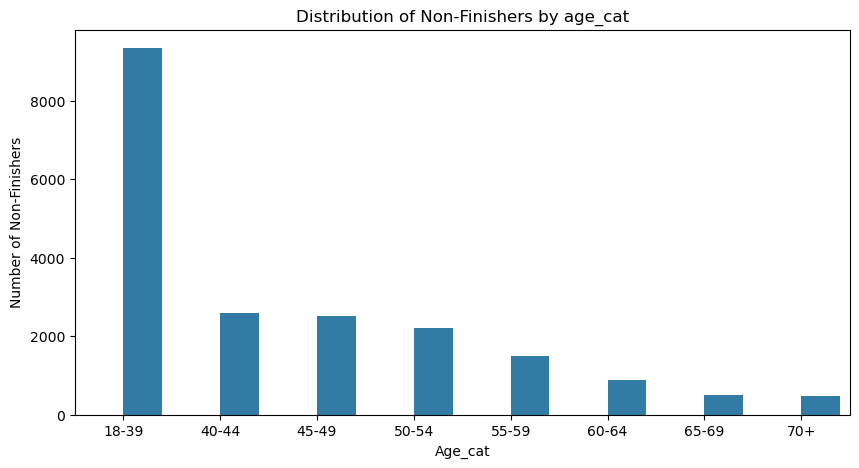

In [13]:
plot_non_finishers_by_cat(df_data, "age_cat")

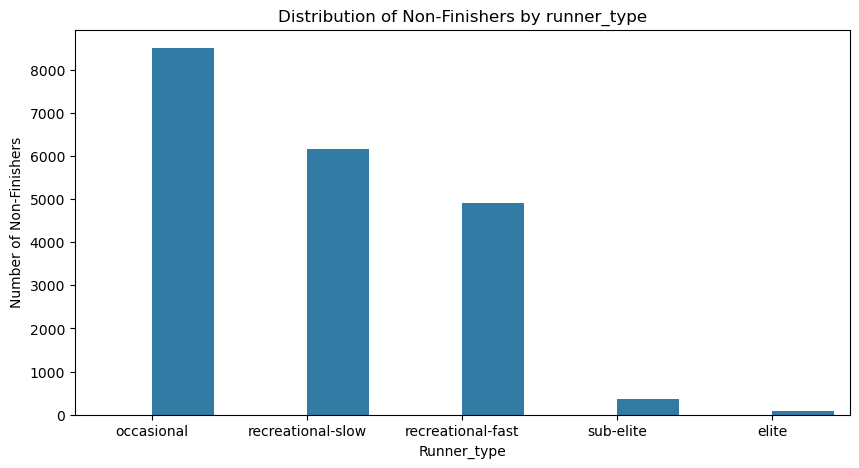

In [14]:
plot_non_finishers_by_cat(df_data, "runner_type")

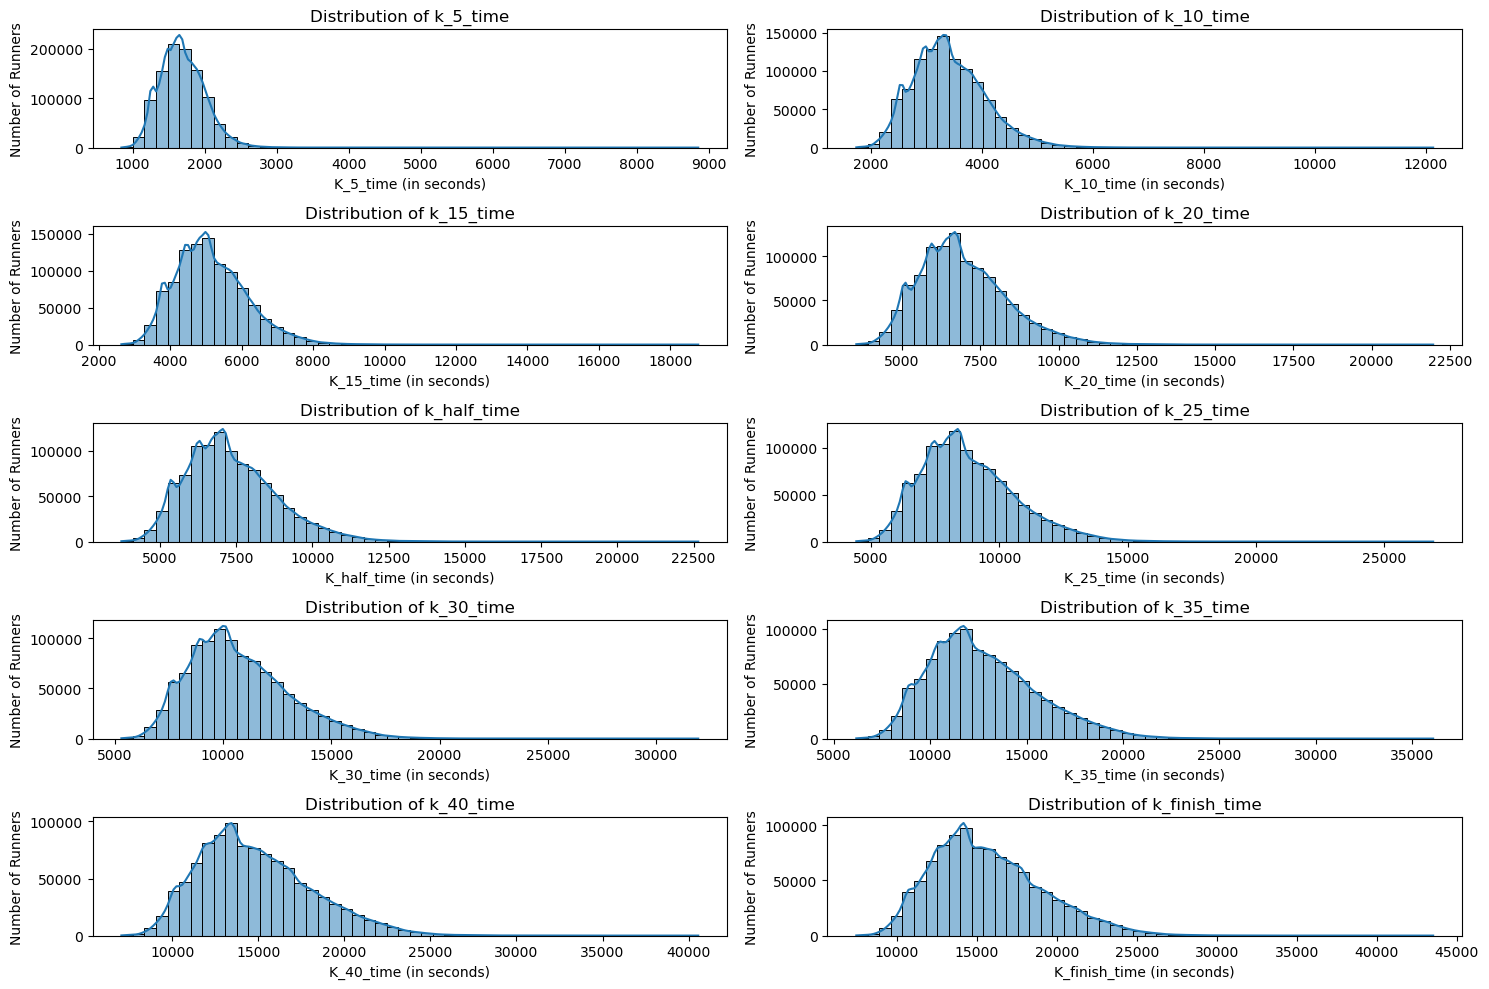

In [15]:
plot_splits_feature_dist(df_data, "time")

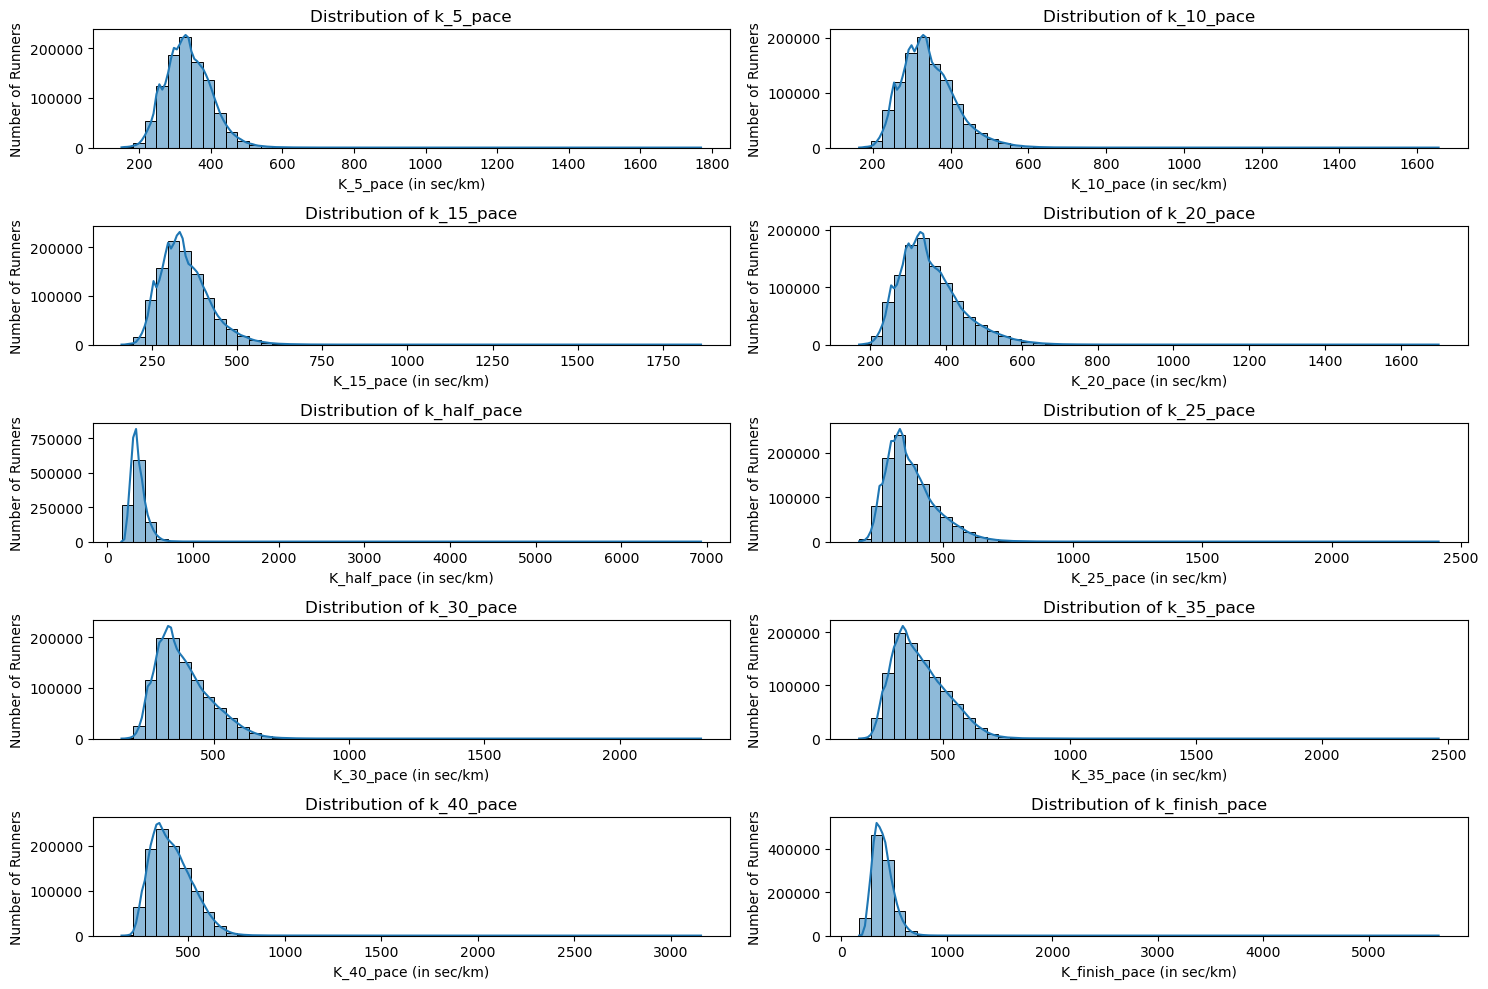

In [16]:
plot_splits_feature_dist(df_data, "pace")

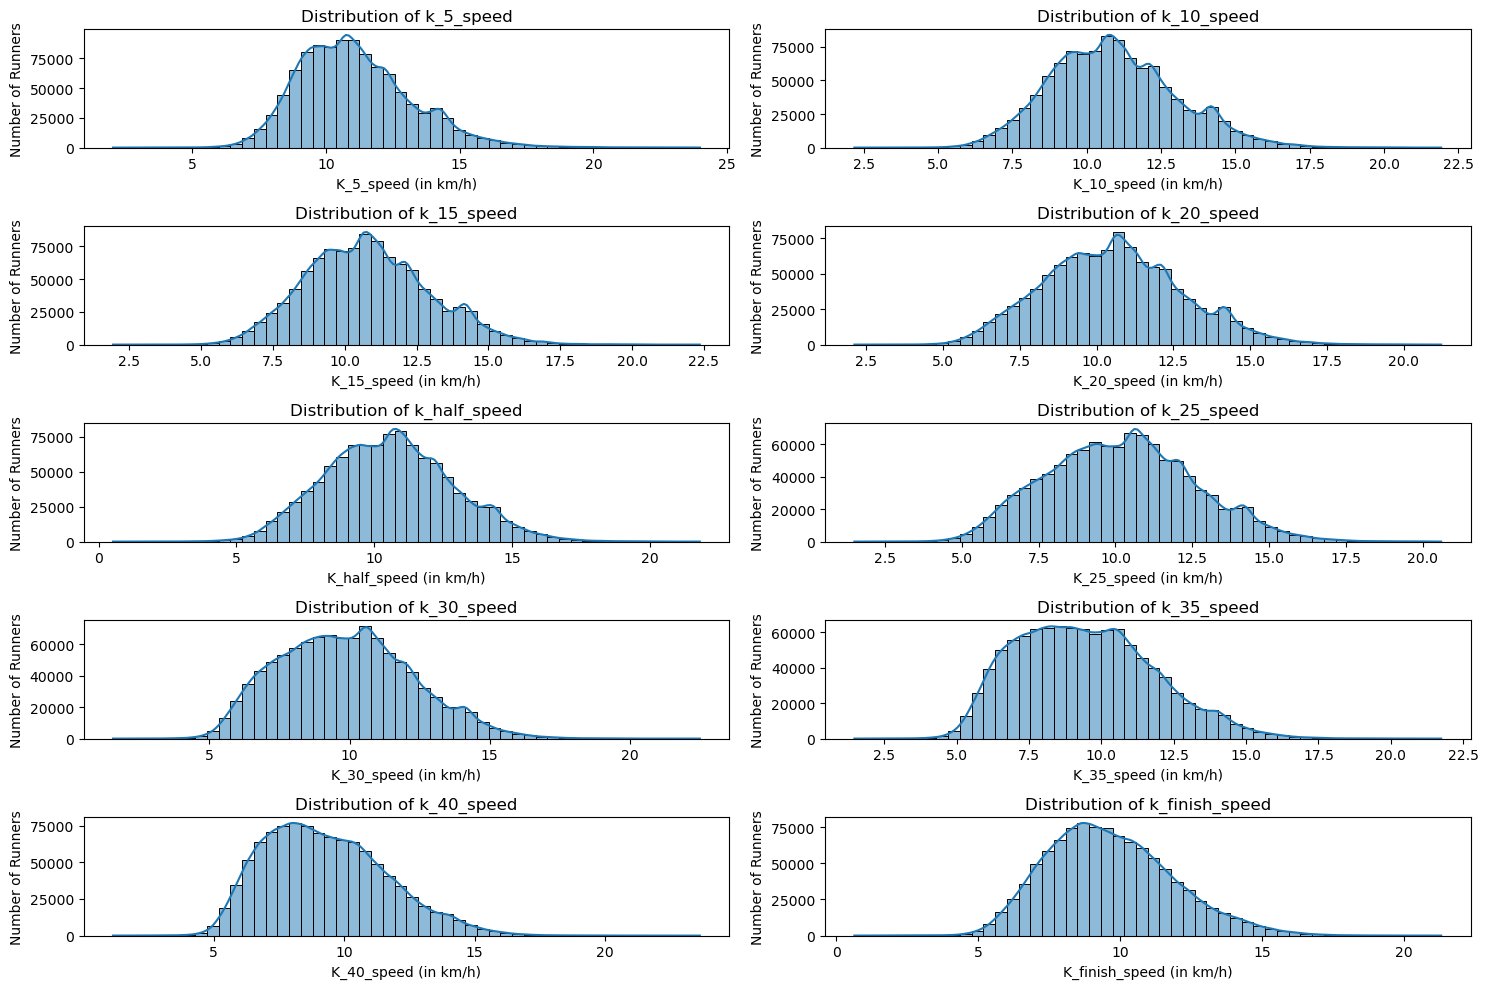

In [17]:
plot_splits_feature_dist(df_data, "speed")

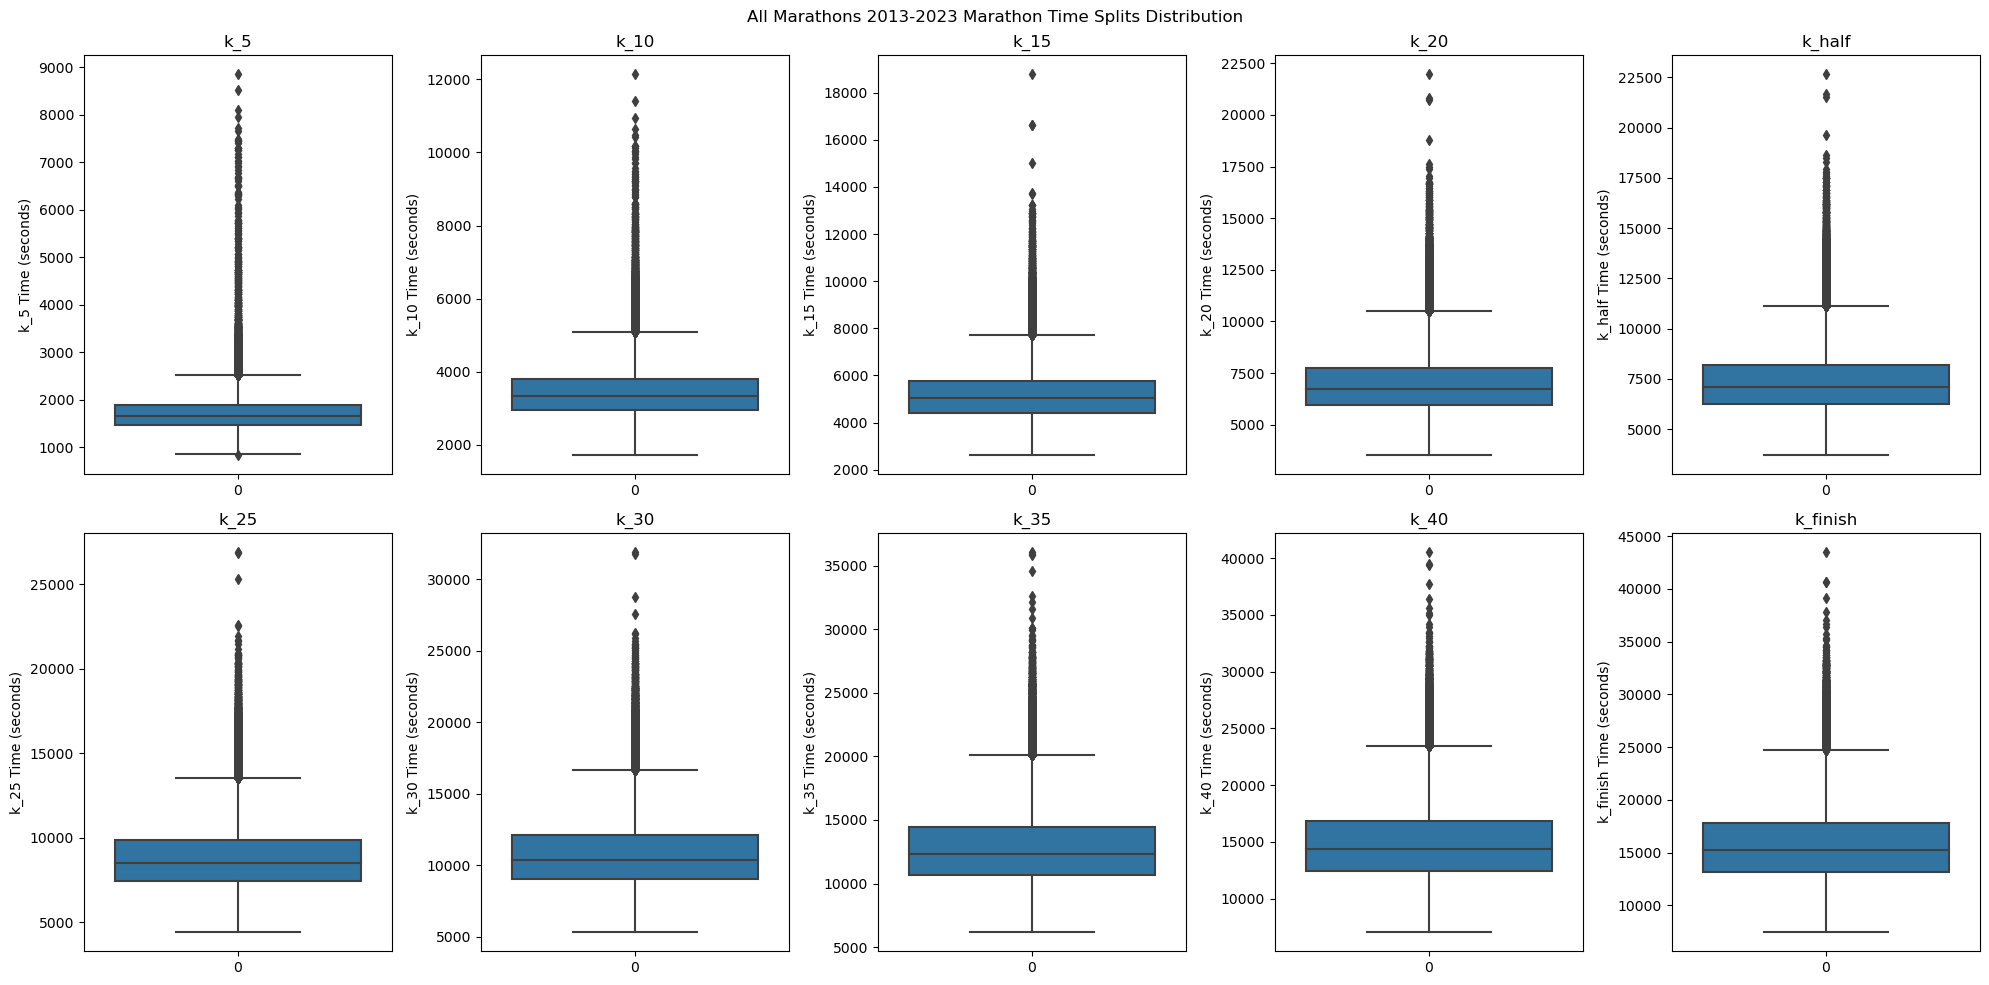

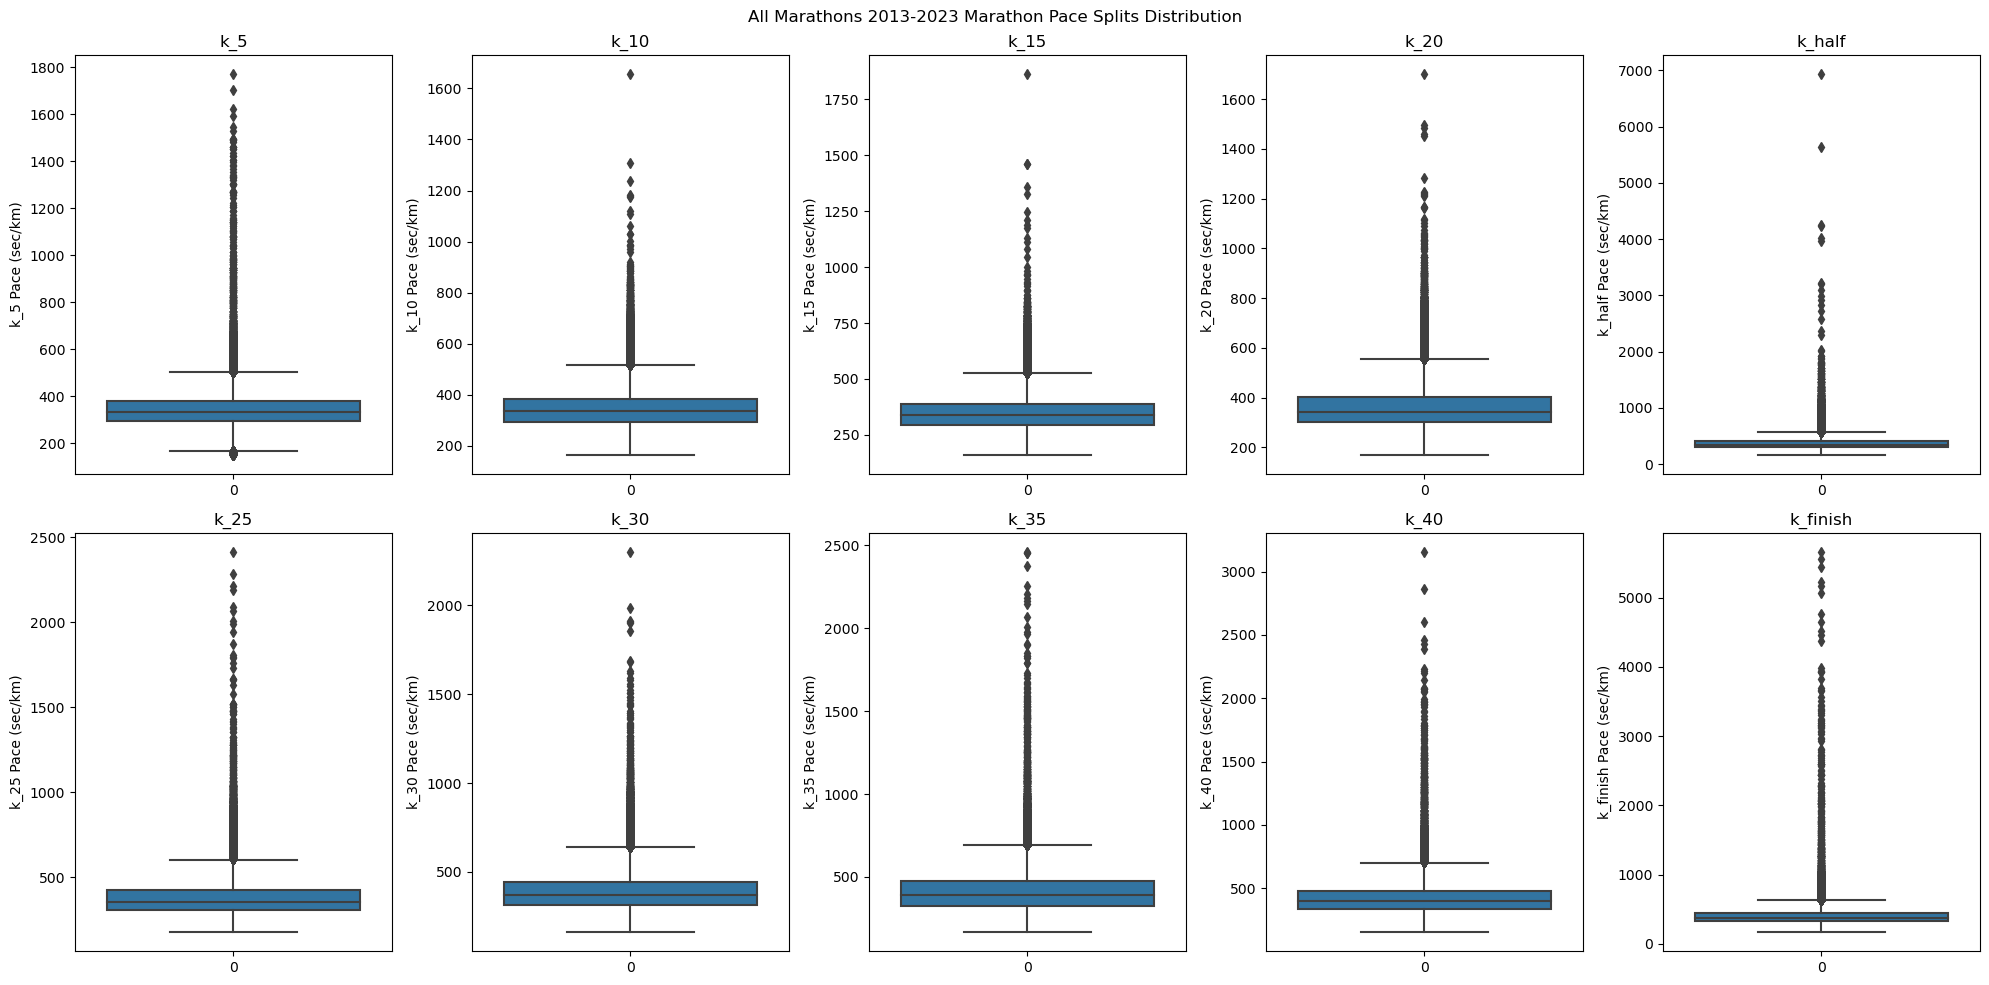

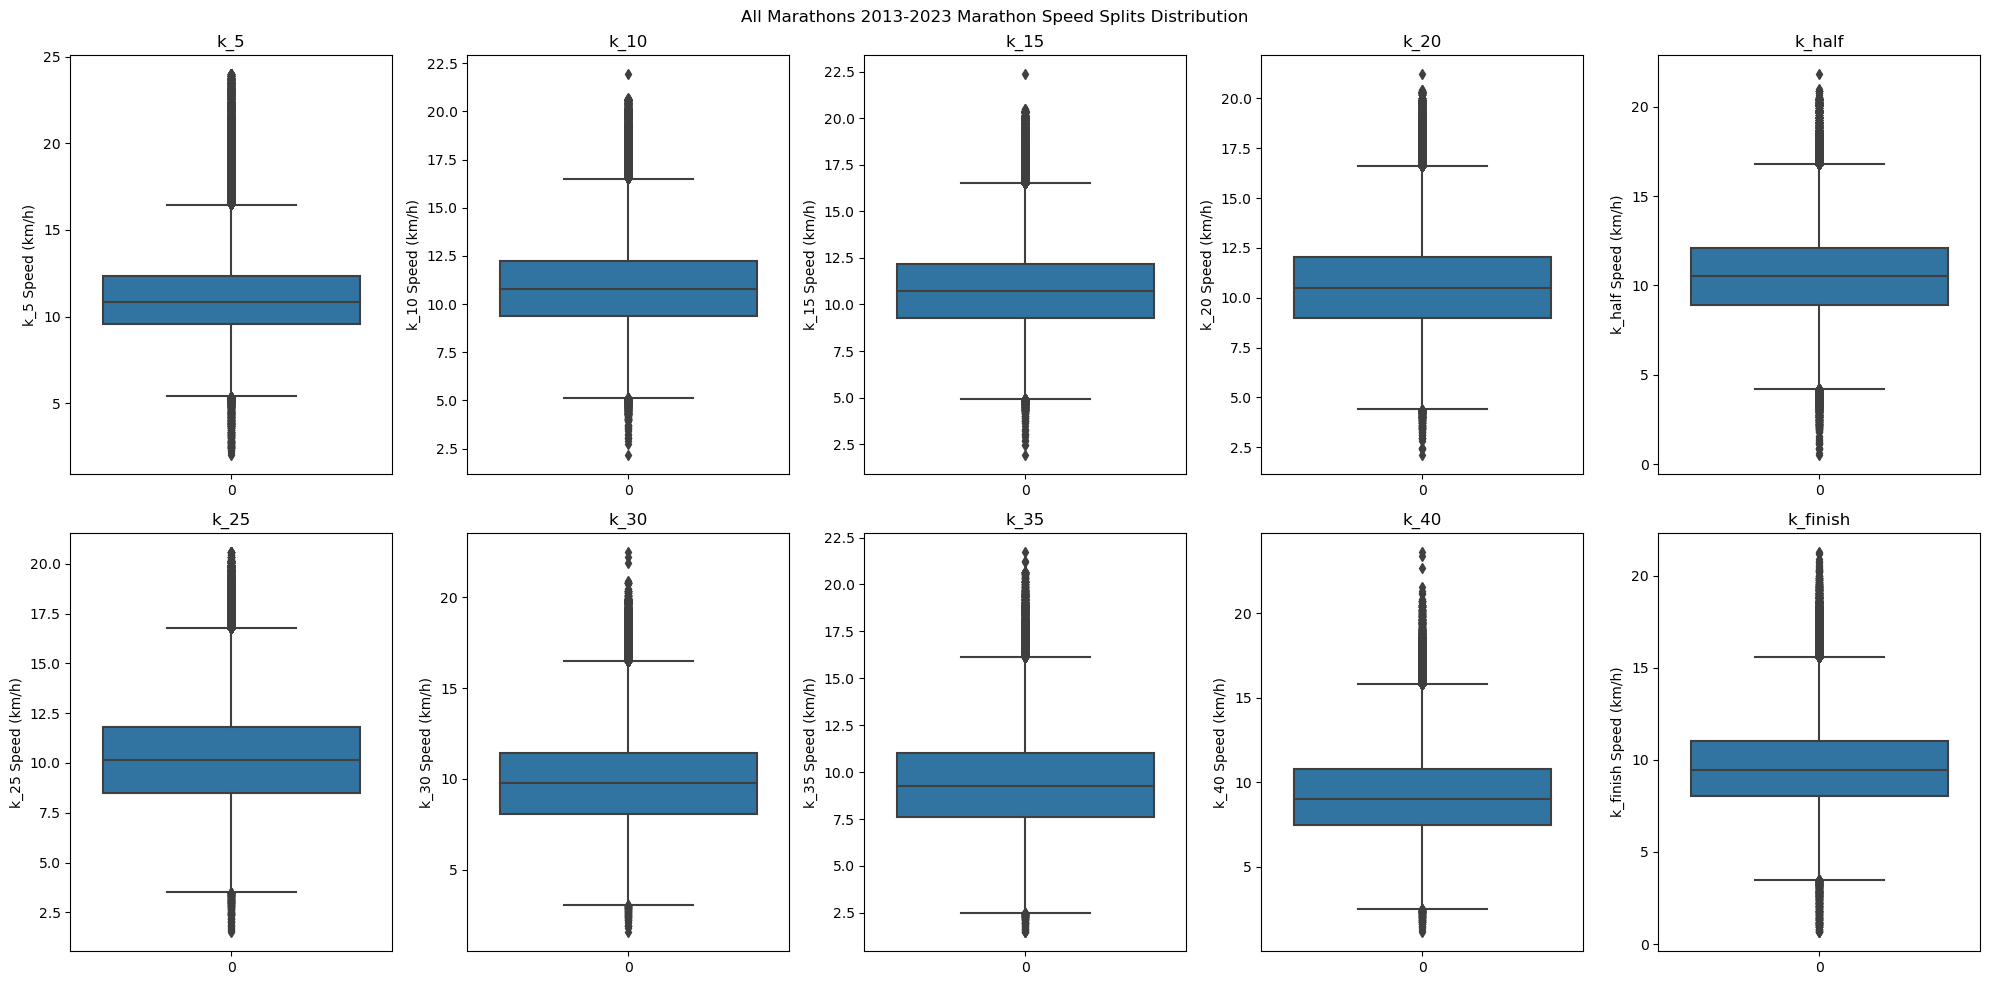

In [18]:
plot_splits_distribution(df_data, SPLITS_KEYS, "All Marathons", "2013-2023")

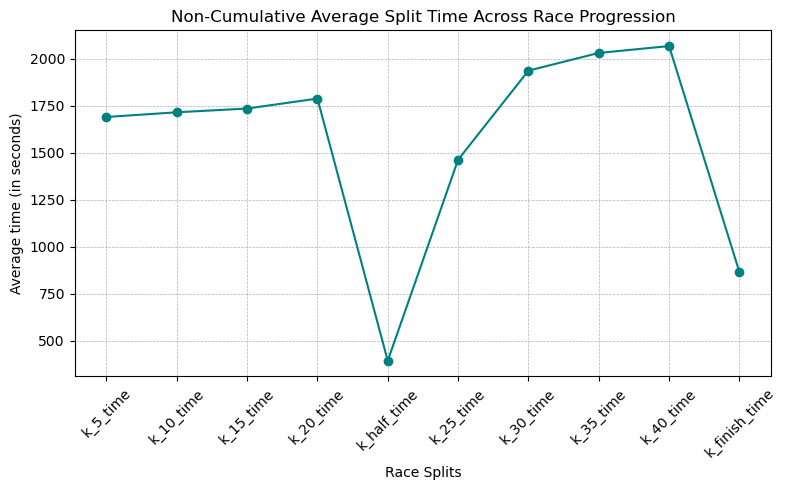

In [19]:
plot_split_data_trend(df_data, "time")

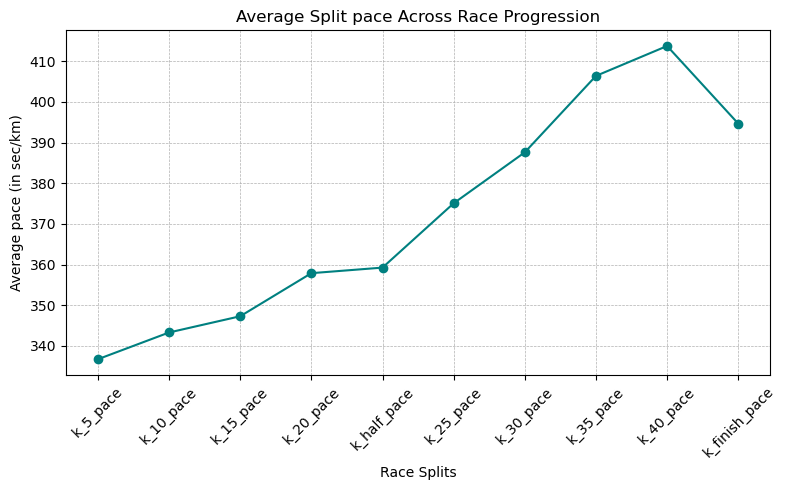

In [20]:
plot_split_data_trend(df_data, "pace")

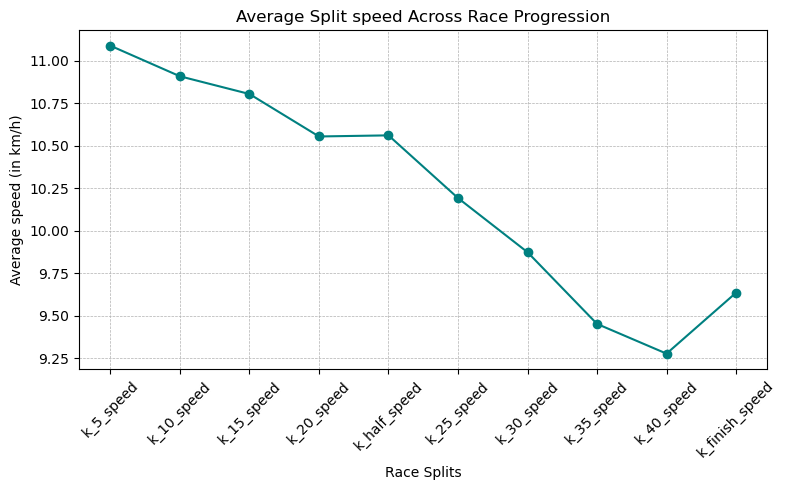

In [21]:
plot_split_data_trend(df_data, "speed")

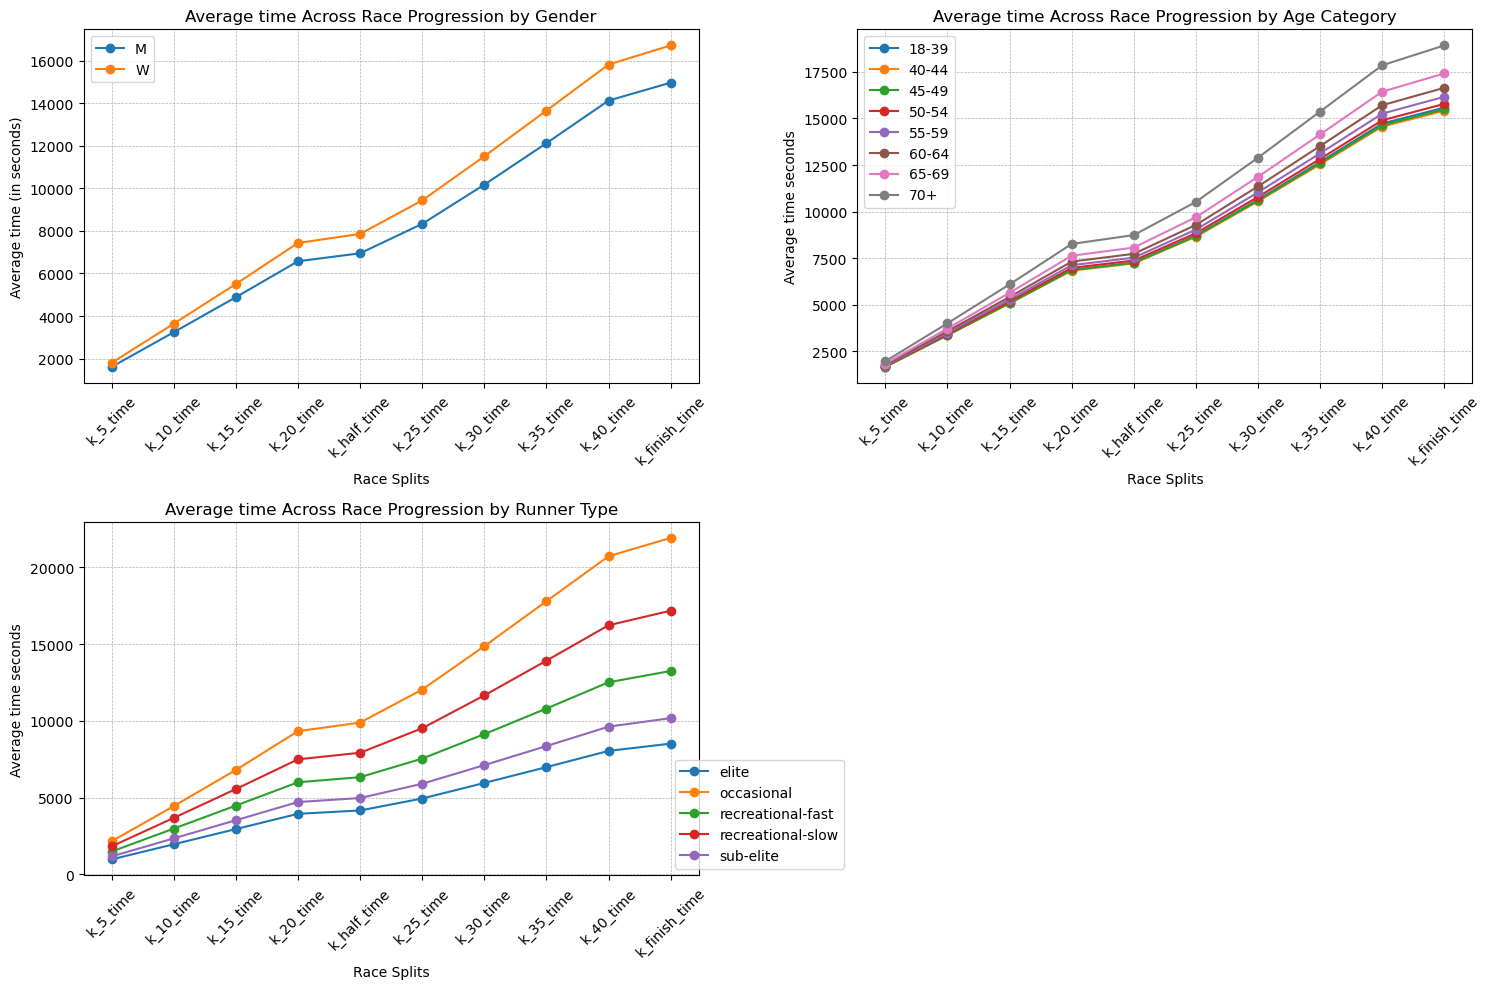

In [22]:
plot_split_data_trend_by_cat(df_data, "time")

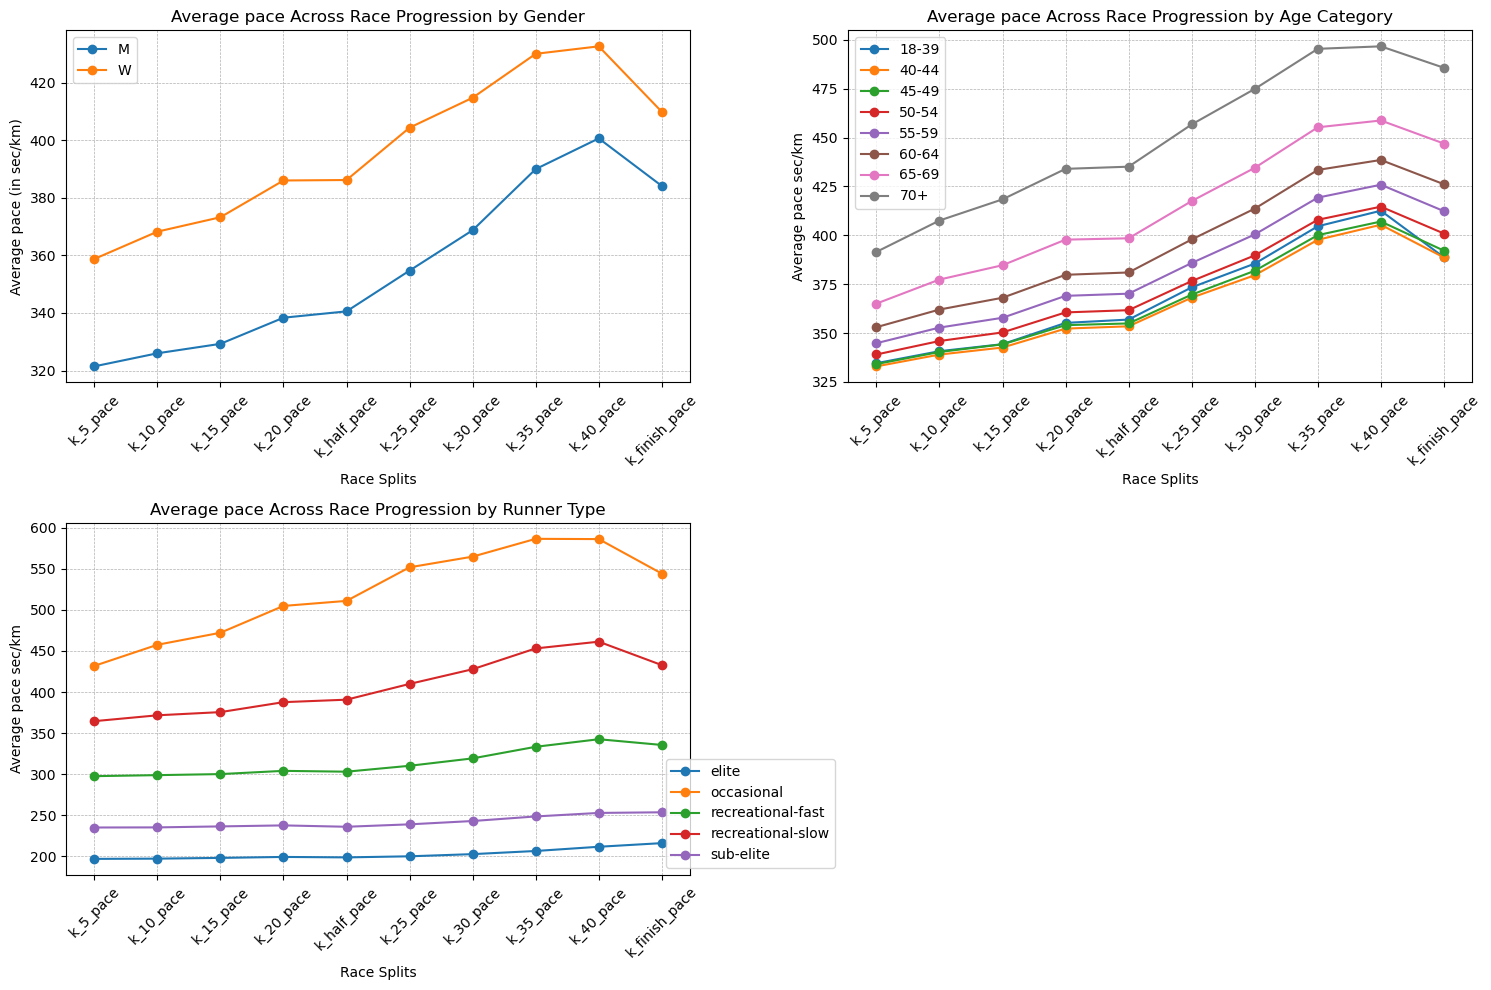

In [23]:
plot_split_data_trend_by_cat(df_data, "pace")

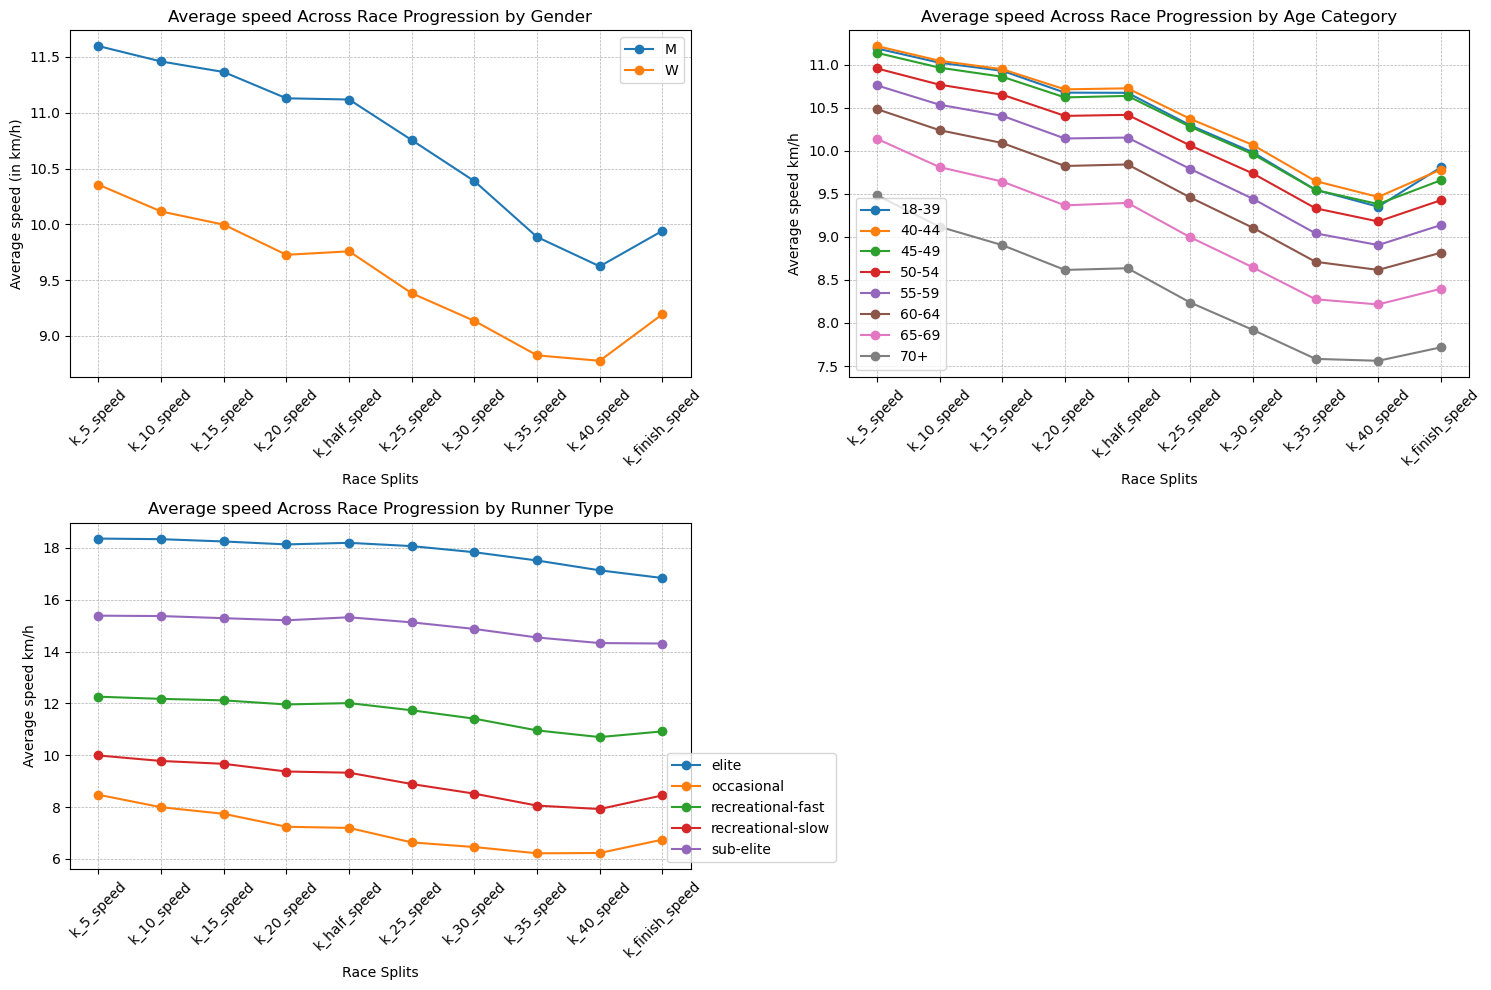

In [24]:
plot_split_data_trend_by_cat(df_data, "speed")

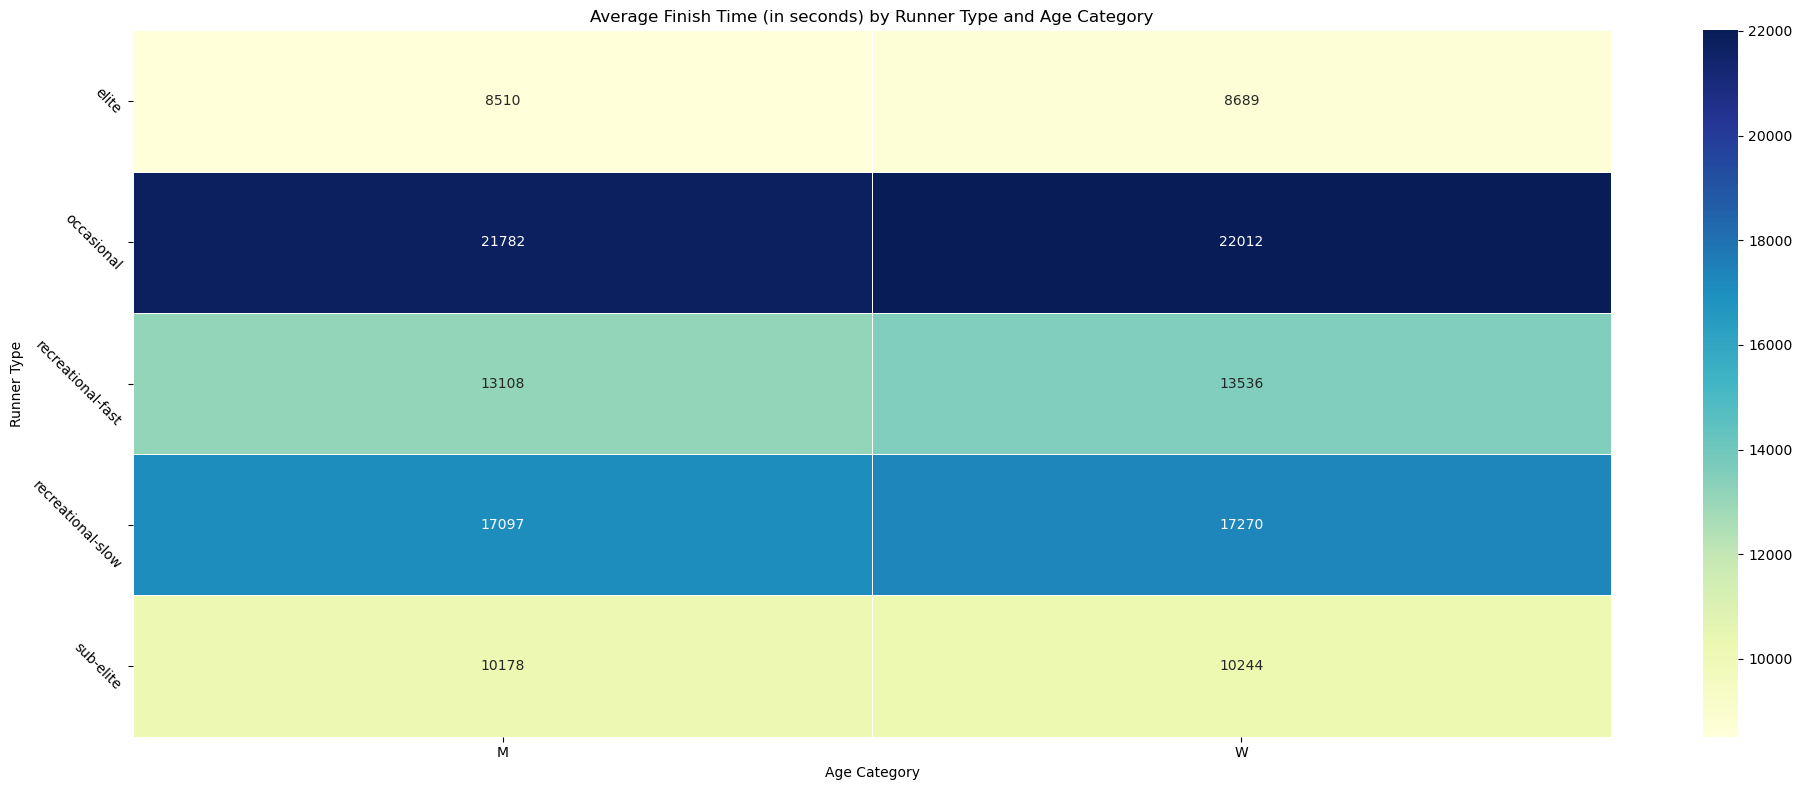

In [25]:
heatmap_data = df_data.pivot_table(index='runner_type', columns='gender', values='k_finish_time', aggfunc='mean')

plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=.5)
plt.title('Average Finish Time (in seconds) by Runner Type and Age Category')
plt.ylabel('Runner Type')
plt.yticks(rotation=-45)
plt.xlabel('Age Category')
plt.tight_layout()
plt.show()

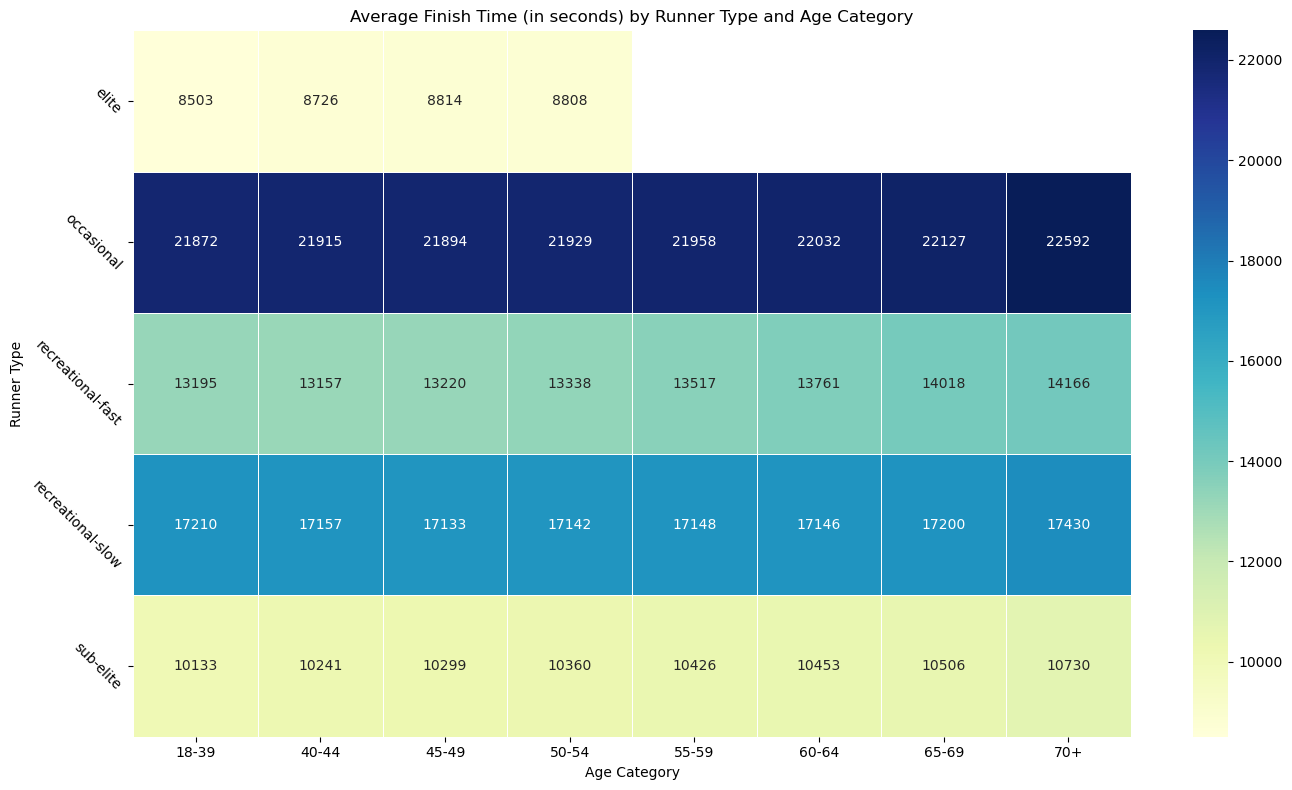

In [26]:
# Creating a heatmap for finish times based on runner type and age category
heatmap_data = df_data.pivot_table(index='runner_type', columns='age_cat', values='k_finish_time', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=.5)
plt.title('Average Finish Time (in seconds) by Runner Type and Age Category')
plt.xlabel('Age Category')
plt.ylabel('Runner Type')
plt.yticks(rotation=-45)
plt.tight_layout()
plt.show()


In [27]:
del df_data

# Datasets Pre-Processing:

In [4]:
# Run this cell to load the data from all marathons into one DataFrame.
# N.B this cell need to be run both for Dropout prediction and Finish time prediction.
MARATHON_NAMES = [HAM, HOU, STO, BOS, CHI]
MARATHON_EXT_PATHS = [HAM_EXT_PATH, HOU_EXT_PATH, STO_EXT_PATH, BOS_EXT_PATH, CHI_EXT_PATH]

df_data = load_and_concat_all_data(LDN, LDN_EXT_PATH, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)
for marathon_name, ext_path in zip(MARATHON_NAMES, MARATHON_EXT_PATHS):
    tmp = load_and_concat_all_data(marathon_name, ext_path, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)
    df_data = pd.concat([df_data, tmp], ignore_index=True)

DataFrame not found at Marathons_Data/Extended/London/London2013/London2013_knn_ext.csv or Marathons_Data/Extended/London/London2013/London2013_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Hamburg/Hamburg2021/Hamburg2021_knn_ext.csv or Marathons_Data/Extended/Hamburg/Hamburg2021/Hamburg2021_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2013/Houston2013_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2013/Houston2013_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2014/Houston2014_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2014/Houston2014_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2015/Houston2015_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2015/Houston2015_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2016/Houston2016_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2016/Houston2016_iter_ext.csv.
DataFrame not found at

### Dropout Prediction:

In [5]:
# Getting the preprocessed datasets. takes around (25 seconds).
train, test, val, dataset_cols = get_preprocessed_datasets(df_data, COLUMNS_ORDER, SPLITS_ORDER, return_cols=True, last_split=10)
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val

Transforming skewed features...

Transforming columns (oneHotEncoding and Scaling)...

("The columns to be used: ['daily_min', 'daily_max', 'medium_temp', "
 "'avg_humidity', 'avg_barometer', 'avg_windspeed', '5k_dnf_pct', "
 "'10k_dnf_pct', '15k_dnf_pct', '20k_dnf_pct', 'half_dnf_pct', '25k_dnf_pct', "
 "'30k_dnf_pct', '35k_dnf_pct', '40k_dnf_pct', 'age_cat_18-39', "
 "'age_cat_40-44', 'age_cat_45-49', 'age_cat_50-54', 'age_cat_55-59', "
 "'age_cat_60-64', 'age_cat_65-69', 'age_cat_70+', 'gender_W', "
 "'runner_type_elite', 'runner_type_occasional', "
 "'runner_type_recreational-fast', 'runner_type_recreational-slow', "
 "'runner_type_sub-elite', 'k_5_time', 'k_5_pace', 'k_10_time', 'k_10_pace', "
 "'k_15_time', 'k_15_pace', 'k_20_time', 'k_20_pace', 'k_half_time', "
 "'k_half_pace', 'k_25_time', 'k_25_pace', 'k_30_time', 'k_30_pace', "
 "'k_35_time', 'k_35_pace', 'k_40_time', 'k_40_pace', 'k_finish_time', "
 "'k_finish_pace']")


In [6]:
print("Normal Data Shape:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Normal Data Shape:
X_train shape: (617705, 49), y_train shape: (617705,)
X_test shape: (205902, 49), y_test shape: (205902,)
X_val shape: (205902, 49), y_val shape: (205902,)


In [7]:
# Define the stratified k-fold cross-validator for marathon dropout prediction.
K_FOLD_NUM = 5
s_kfold = StratifiedKFold(n_splits=K_FOLD_NUM, shuffle=True, random_state=17)

### Performance Prediction:

In [5]:
# Only keeping the runner who finished.
df_data_finishers = df_data[df_data["race_state"] == "Finished"].reset_index(drop=True)
# Drop split DNF pct cols.
df_data_finishers = df_data_finishers.drop(columns=[col for col in df_data_finishers.columns.to_list() if "dnf_pct" in col])
# Get the preprocessed datasets.
train, test, val, p_transformer, dataset_cols = get_reg_preprocessed_datasets(df_data_finishers, df_data_finishers.columns, SPLITS_ORDER, return_cols=True, last_split=5)

Transforming skewed features...

Transforming columns (oneHotEncoding and Scaling)...

("The columns to be used: ['daily_min', 'daily_max', 'medium_temp', "
 "'avg_humidity', 'avg_barometer', 'avg_windspeed', 'age_cat_18-39', "
 "'age_cat_40-44', 'age_cat_45-49', 'age_cat_50-54', 'age_cat_55-59', "
 "'age_cat_60-64', 'age_cat_65-69', 'age_cat_70+', 'gender_W', "
 "'runner_type_elite', 'runner_type_occasional', "
 "'runner_type_recreational-fast', 'runner_type_recreational-slow', "
 "'runner_type_sub-elite', 'k_5_time', 'k_5_pace', 'k_10_time', 'k_10_pace', "
 "'k_15_time', 'k_15_pace', 'k_20_time', 'k_20_pace', 'k_half_time', "
 "'k_half_pace']")


In [6]:
# Unpacking the datasets.
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val

In [ ]:
# Save the transformer, since it will be needed to inverse transform the predictions.
save_sklearn_model(p_transformer, "Regression_PowerTransformer", MODEL_REG_SAVE_NORMAL)

In [6]:
# Define the k-fold cross-validator for marathon performance prediction.
K_FOLD_NUM = 5
kfold = KFold(n_splits=K_FOLD_NUM, shuffle=True, random_state=17)

# Models:

## Marathon Dropout Prediction:

### Extended Dataset:

#### KNN:

In [8]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')

In [9]:
cv_score = cross_val_score(knn_cls, X_train, y_train, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.339 (0.010)


In [10]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [11]:
y_pred = knn_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.70      0.26      0.38      4002

    accuracy                           0.98    205902
   macro avg       0.84      0.63      0.69    205902
weighted avg       0.98      0.98      0.98    205902



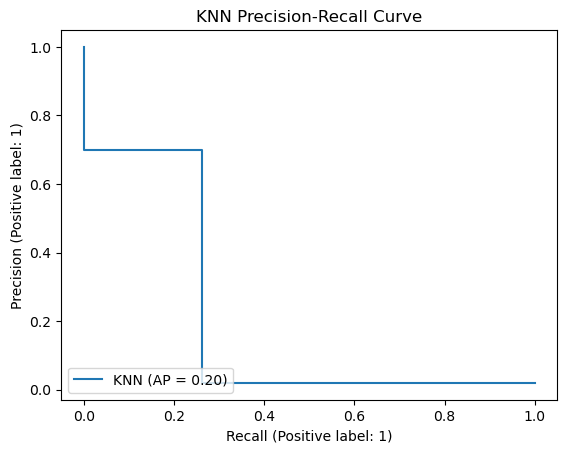

In [46]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="KNN")
pr_display.ax_.set_title("KNN Precision-Recall Curve")
plt.show()

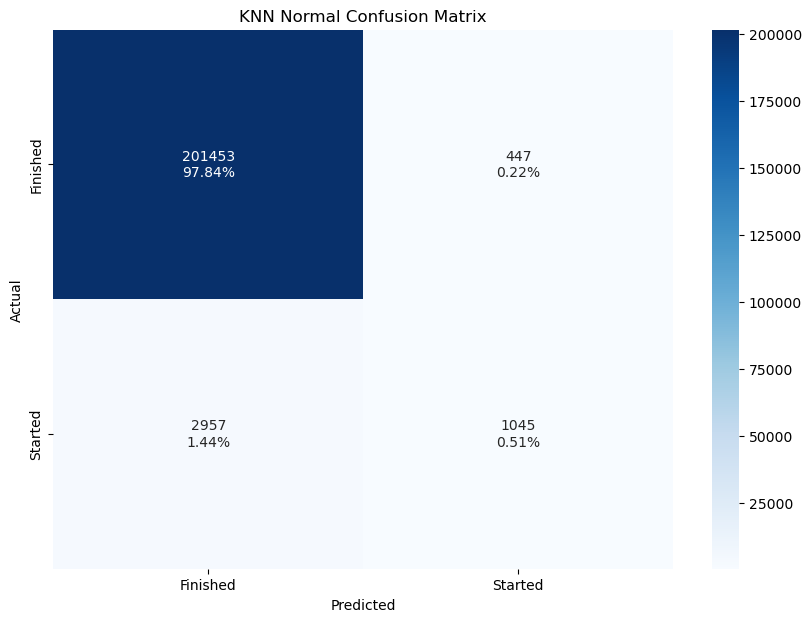

In [47]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="KNN Normal Confusion Matrix")

In [48]:
save_sklearn_model(knn_cls, "KNN_normal", MODEL_CLASS_SAVE_NORMAL)

Model saved to Models/Classification/Normal/KNN_normal.joblib


In [49]:
del knn_cls

#### Random Forest:

In [50]:
rfr_cls = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=2, min_samples_split=4, criterion='gini', random_state=17, n_jobs=-1)

In [51]:
cv_score = cross_val_score(rfr_cls, X_train, y_train, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.520 (0.010)


In [52]:
rfr_cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_jobs=-1, random_state=17)

<Axes: >

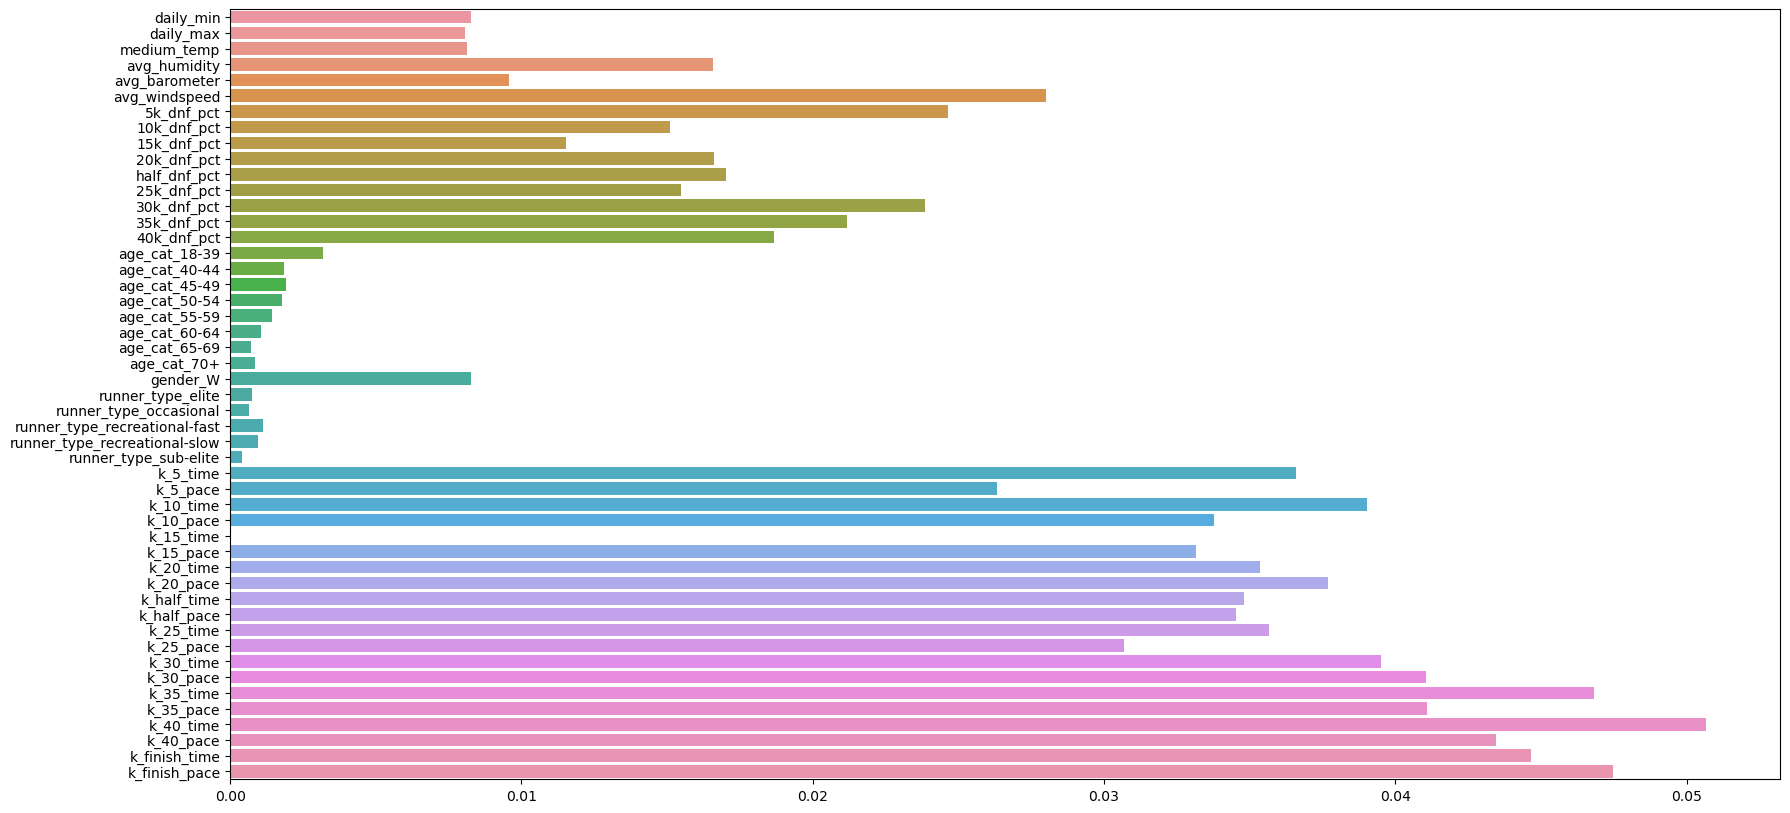

In [53]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_cls.feature_importances_, y=dataset_cols)

In [54]:
y_pred = rfr_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.86      0.30      0.44      4002

    accuracy                           0.99    205902
   macro avg       0.92      0.65      0.72    205902
weighted avg       0.98      0.99      0.98    205902



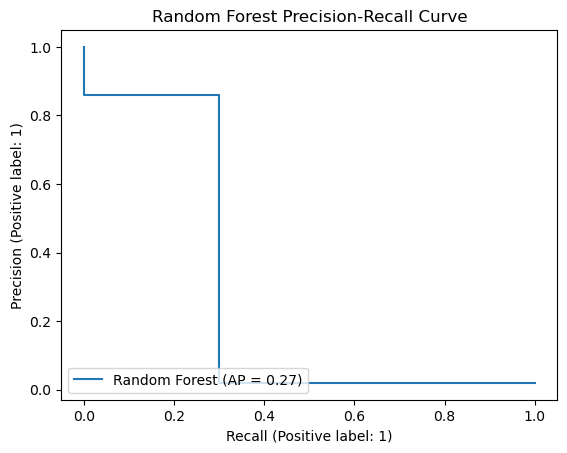

In [55]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Random Forest")
pr_display.ax_.set_title("Random Forest Precision-Recall Curve")
plt.show()

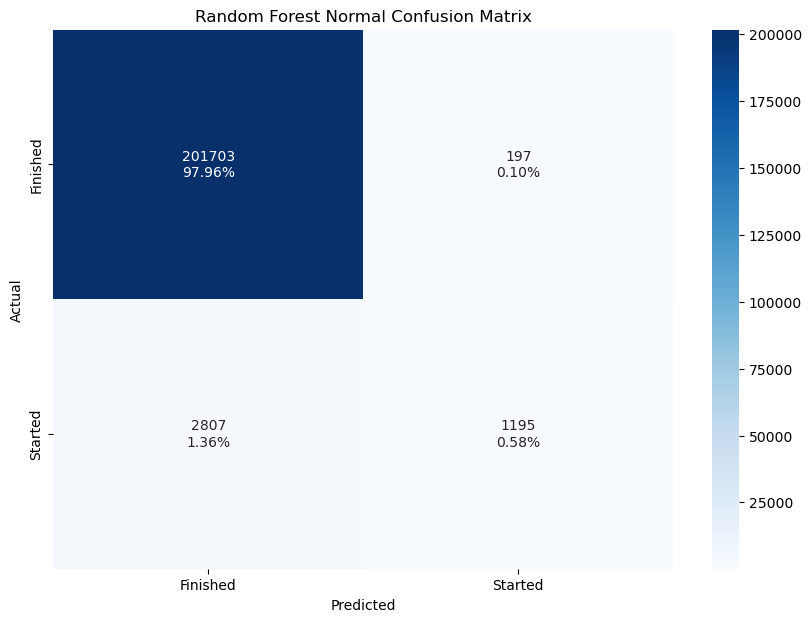

In [56]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Random Forest Normal Confusion Matrix")

In [57]:
save_sklearn_model(rfr_cls, "RandomForest_normal", MODEL_CLASS_SAVE_NORMAL)

Model saved to Models/Classification/Normal/RandomForest_normal.joblib


In [58]:
del rfr_cls

#### Balanced Random Forest:

In [59]:
brf_cls = BalancedRandomForestClassifier(n_estimators=100, max_depth=20, sampling_strategy="all", replacement=True, 
                                         min_samples_leaf=2, min_samples_split=4, random_state=17, n_jobs=-1)

In [60]:
cv_score = cross_val_score(brf_cls, X_test, y_test, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.427 (0.013)


In [61]:
brf_cls.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=2,
                               min_samples_split=4, n_jobs=-1, random_state=17,
                               replacement=True, sampling_strategy='all')

<Axes: >

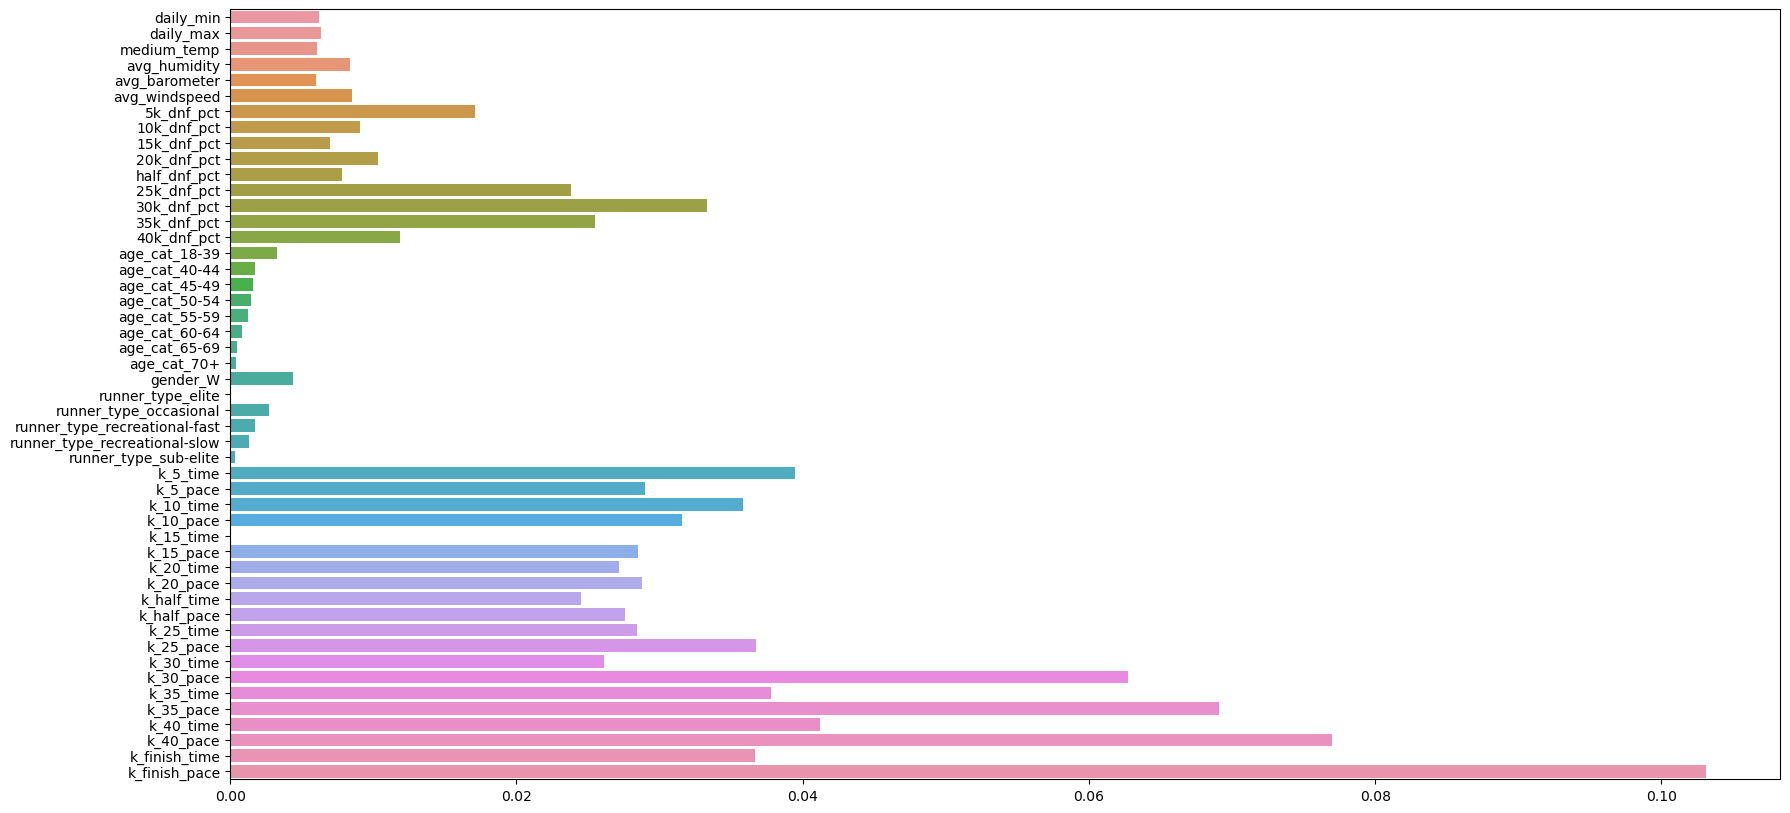

In [62]:
plt.figure(figsize=(20, 10))
sns.barplot(x=brf_cls.feature_importances_, y=dataset_cols)

In [63]:
y_pred = brf_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       1.00      0.89      0.94    201900
     Started       0.13      0.82      0.22      4002

    accuracy                           0.89    205902
   macro avg       0.56      0.85      0.58    205902
weighted avg       0.98      0.89      0.93    205902



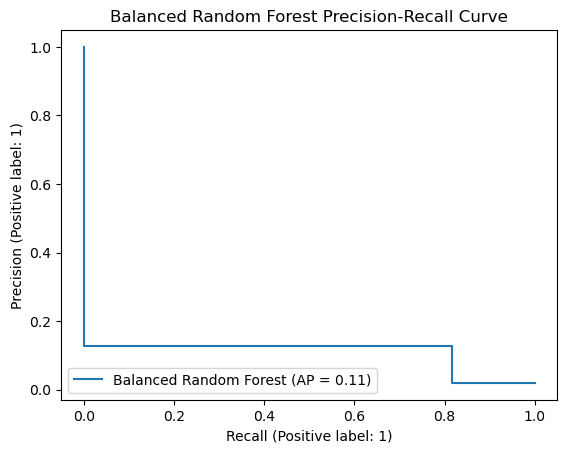

In [64]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Balanced Random Forest")
pr_display.ax_.set_title("Balanced Random Forest Precision-Recall Curve")
plt.show()

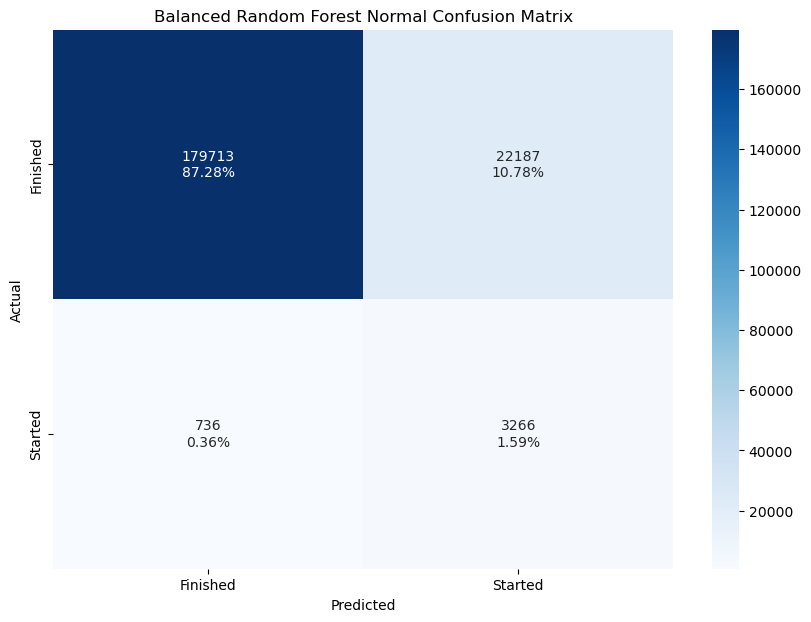

In [65]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Balanced Random Forest Normal Confusion Matrix")

In [66]:
save_sklearn_model(brf_cls, "BalancedRandomForest_normal", MODEL_CLASS_SAVE_NORMAL)

Model saved to Models/Classification/Normal/BalancedRandomForest_normal.joblib


In [67]:
del brf_cls

#### XGBoost:

In [192]:
xgb_cls = XGBClassifier(n_estimators=200, max_depth=20, eval_metric="aucpr", max_delta_step=2,
                        reg_alpha=20, learning_rate=0.8, gamma=0.1, random_state=17, n_jobs=-1, early_stopping_rounds=10)

In [193]:
# If this cell is run, the model should not be intialised with early stopping.
cv_score = cross_val_score(xgb_cls, X_train, y_train, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.604 (0.010)


In [172]:
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_cls.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.46439	validation_1-aucpr:0.39454
[1]	validation_0-aucpr:0.53002	validation_1-aucpr:0.44442
[2]	validation_0-aucpr:0.56907	validation_1-aucpr:0.47119
[3]	validation_0-aucpr:0.59326	validation_1-aucpr:0.48974
[4]	validation_0-aucpr:0.61230	validation_1-aucpr:0.50089
[5]	validation_0-aucpr:0.64020	validation_1-aucpr:0.51734
[6]	validation_0-aucpr:0.65683	validation_1-aucpr:0.52705
[7]	validation_0-aucpr:0.67805	validation_1-aucpr:0.53788
[8]	validation_0-aucpr:0.69190	validation_1-aucpr:0.54617
[9]	validation_0-aucpr:0.70466	validation_1-aucpr:0.55264
[10]	validation_0-aucpr:0.71751	validation_1-aucpr:0.55920
[11]	validation_0-aucpr:0.73370	validation_1-aucpr:0.56593
[12]	validation_0-aucpr:0.74496	validation_1-aucpr:0.57264
[13]	validation_0-aucpr:0.75501	validation_1-aucpr:0.57638
[14]	validation_0-aucpr:0.76369	validation_1-aucpr:0.57943
[15]	validation_0-aucpr:0.77416	validation_1-aucpr:0.58458
[16]	validation_0-aucpr:0.78197	validation_1-aucpr:0.58839
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

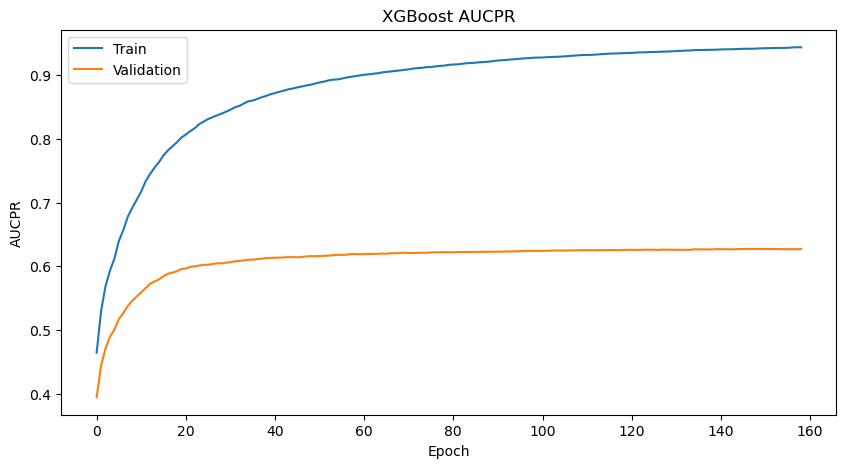

In [173]:
plt.figure(figsize=(10, 5))
plt.plot(xgb_cls.evals_result_["validation_0"]["aucpr"], label="Train")
plt.plot(xgb_cls.evals_result_["validation_1"]["aucpr"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUCPR")
plt.title("XGBoost AUCPR")

plt.show()

<Axes: >

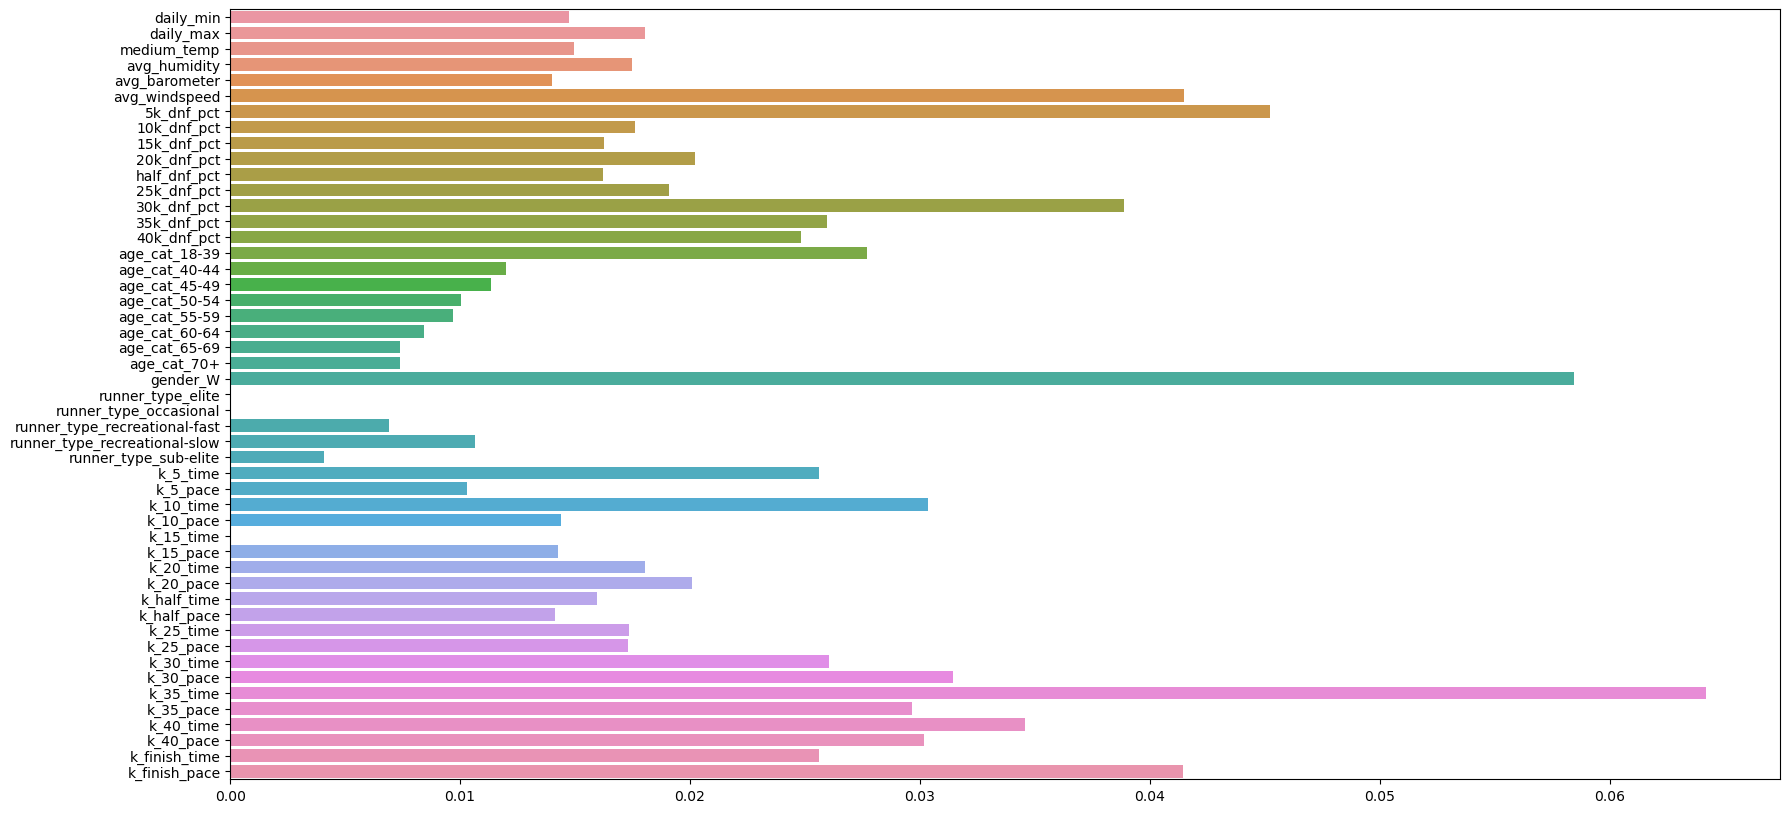

In [174]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_cls.feature_importances_, y=dataset_cols)

In [175]:
y_pred = xgb_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.80      0.44      0.56      4002

    accuracy                           0.99    205902
   macro avg       0.89      0.72      0.78    205902
weighted avg       0.99      0.99      0.98    205902



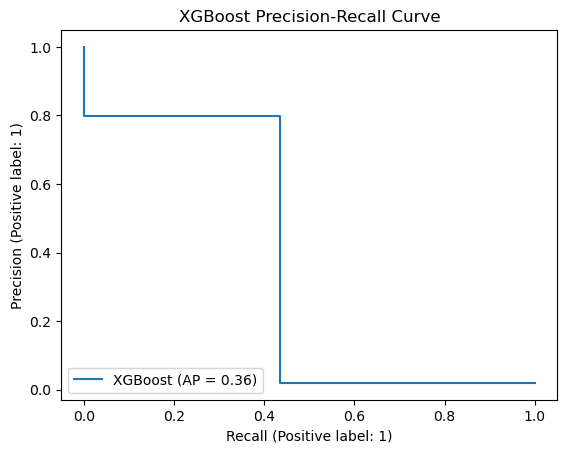

In [176]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="XGBoost")
pr_display.ax_.set_title("XGBoost Precision-Recall Curve")
plt.show()

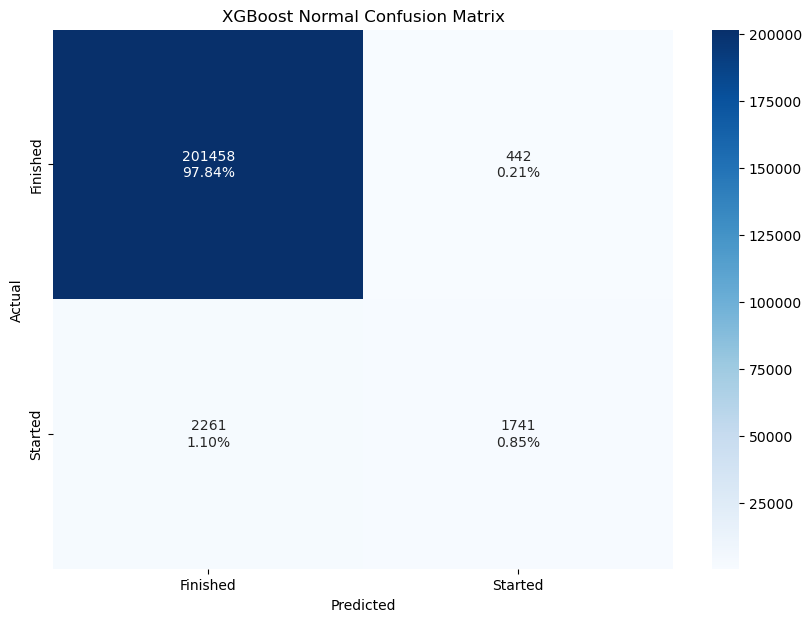

In [177]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="XGBoost Normal Confusion Matrix")

In [178]:
xgb_cls.save_model(f"{MODEL_CLASS_SAVE_NORMAL}XGBoost_normal.json")

In [194]:
del xgb_cls

#### Neural Network:

In [51]:
METRICS = [
    #   tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    #   tf.keras.metrics.MeanSquaredError(name='Brier score'),
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy', metrics=METRICS)

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2624      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6849 (26.75 KB)
Trainable params: 6849 (26.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
302/302 [==============================] - 8s 26ms/step - loss: 0.1223 - accuracy: 0.9732 - precision: 0.0204 - recall: 0.0080 - auc: 0.6339 - prc: 0.0285 - val_loss: 0.0823 - val_accuracy: 0.9806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8043 - val_prc: 0.1170
Epoch 2/100
302/302 [==============================] - 7s 23ms/step - loss: 0.0822 - accuracy: 0.9809 - precision: 0.7616 - recall: 0.0218 - auc: 0.7961 - prc: 0.1595 - val_loss: 0.0730 - val_accuracy: 0.9813 - val_precision: 0.9140 - val_recall: 0.0425 - val_auc: 0.8421 - val_prc: 0.2874
Epoch 3/100
302/302 [==============================] - 7s 22ms/step - loss: 0.0760 - accuracy: 0.9816 - precision: 0.7542 - recall: 0.0815 - auc: 0.8223 - prc: 0.2522 - val_loss: 0.0696 - val_accuracy: 0.9824 - val_precision: 0.8310 - val_recall: 0.1167 - val_auc: 0.8572 - val_prc: 0.3264
Epoch 4/100
302/302 [==============================] - 6s 21ms/step - loss: 0.0732 - accuracy: 0.9821 - precision: 0.7589 

In [53]:
model.evaluate(X_test, y_test)

6435/6435 [==============================] - 88s 14ms/step - loss: 0.0499 - accuracy: 0.9853 - precision: 0.8033 - recall: 0.3193 - auc: 0.9479 - prc: 0.5515


[0.0498807355761528,
 0.9852502942085266,
 0.8032683730125427,
 0.319340318441391,
 0.9479070901870728,
 0.5514822006225586]

In [54]:
y_pred = model.predict(X_test)

6435/6435 [==============================] - 14s 2ms/step


In [61]:
print(classification_report(y_test, (y_pred > 0.5).astype(int), target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.80      0.32      0.46      4002

    accuracy                           0.99    205902
   macro avg       0.89      0.66      0.72    205902
weighted avg       0.98      0.99      0.98    205902



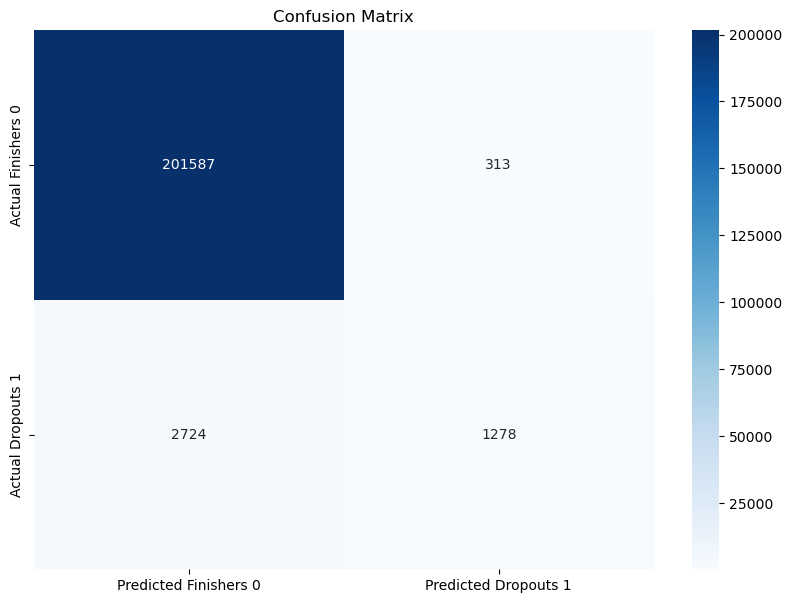

In [60]:
plot_confusion_matrix(y_test, (y_pred > 0.5).astype(int), class_names, title="Neural Network Normal Confusion Matrix")

### Extended SMOTE Dataset:

In [18]:
print(f"Samples' Count Before Over-Sampling: {np.unique(y_train, return_counts=True)}")
# Define the over-sampling method.
smote = SMOTE(k_neighbors=5, random_state=17)
############ N.B START The data has been saved, if you want to regenerate it uncomment this section ###############
# Apply over-sampling.
# X_train, y_train = smote.fit_resample(X_train, y_train)
# np.save(f"{OTHER_DATA_PATH}/X_train_smote.npy", X_train)
# np.save(f"{OTHER_DATA_PATH}/y_train_smote.npy", y_train)
########################### N.B END ###########################################
X_train = np.load(f"{OTHER_DATA_PATH}/X_train_smote.npy")
y_train = np.load(f"{OTHER_DATA_PATH}/y_train_smote.npy")
print(f"Samples' Count After Over-Sampling: {np.unique(y_train, return_counts=True)}")

Samples' Count Before Over-Sampling: (array([0, 1]), array([605698,  12007]))
Samples' Count After Over-Sampling: (array([0, 1]), array([605698, 605698]))


#### KNN:

In [19]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')

In [20]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [21]:
y_pred = knn_cls.predict(X_test)
class_names = ["Finished", "Started"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.99      0.91      0.95    201900
     Started       0.12      0.61      0.20      4002

    accuracy                           0.91    205902
   macro avg       0.56      0.76      0.58    205902
weighted avg       0.97      0.91      0.94    205902



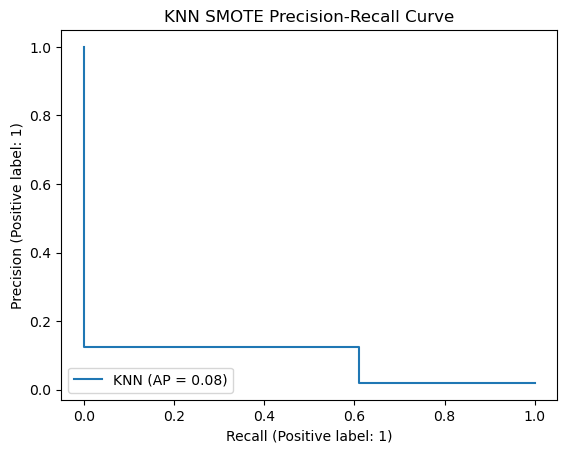

In [22]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="KNN")
pr_display.ax_.set_title("KNN SMOTE Precision-Recall Curve")
plt.show()

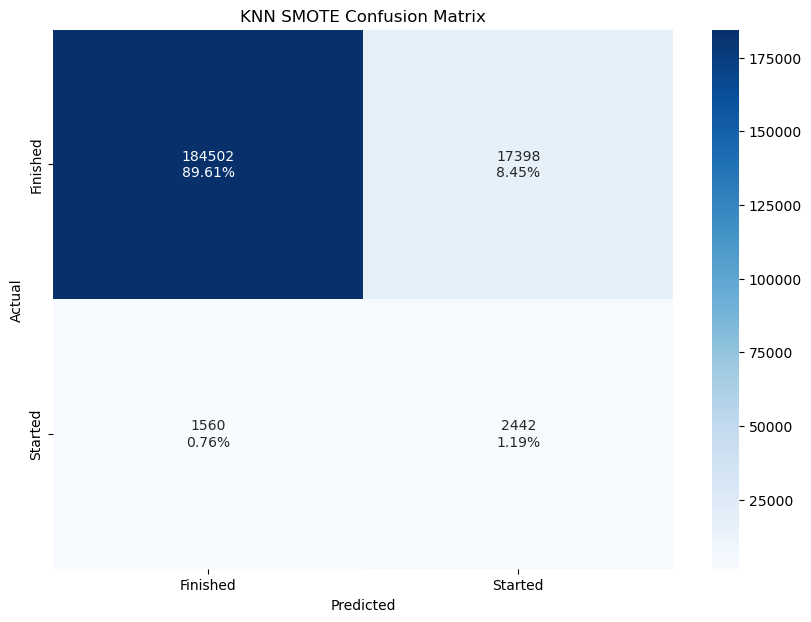

In [23]:
plot_confusion_matrix(y_test, y_pred, class_names, title="KNN SMOTE Confusion Matrix")

In [24]:
save_sklearn_model(knn_cls, "KNN_SMOTE", MODEL_CLASS_SAVE_OVER)

Model saved to Models/Classification/Oversampled/KNN_SMOTE.joblib


In [25]:
del knn_cls

#### Random Forest:

In [26]:
rfr_cls = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=2, min_samples_split=4, criterion='gini', random_state=17, n_jobs=-1)

In [27]:
rfr_cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_jobs=-1, random_state=17)

<Axes: >

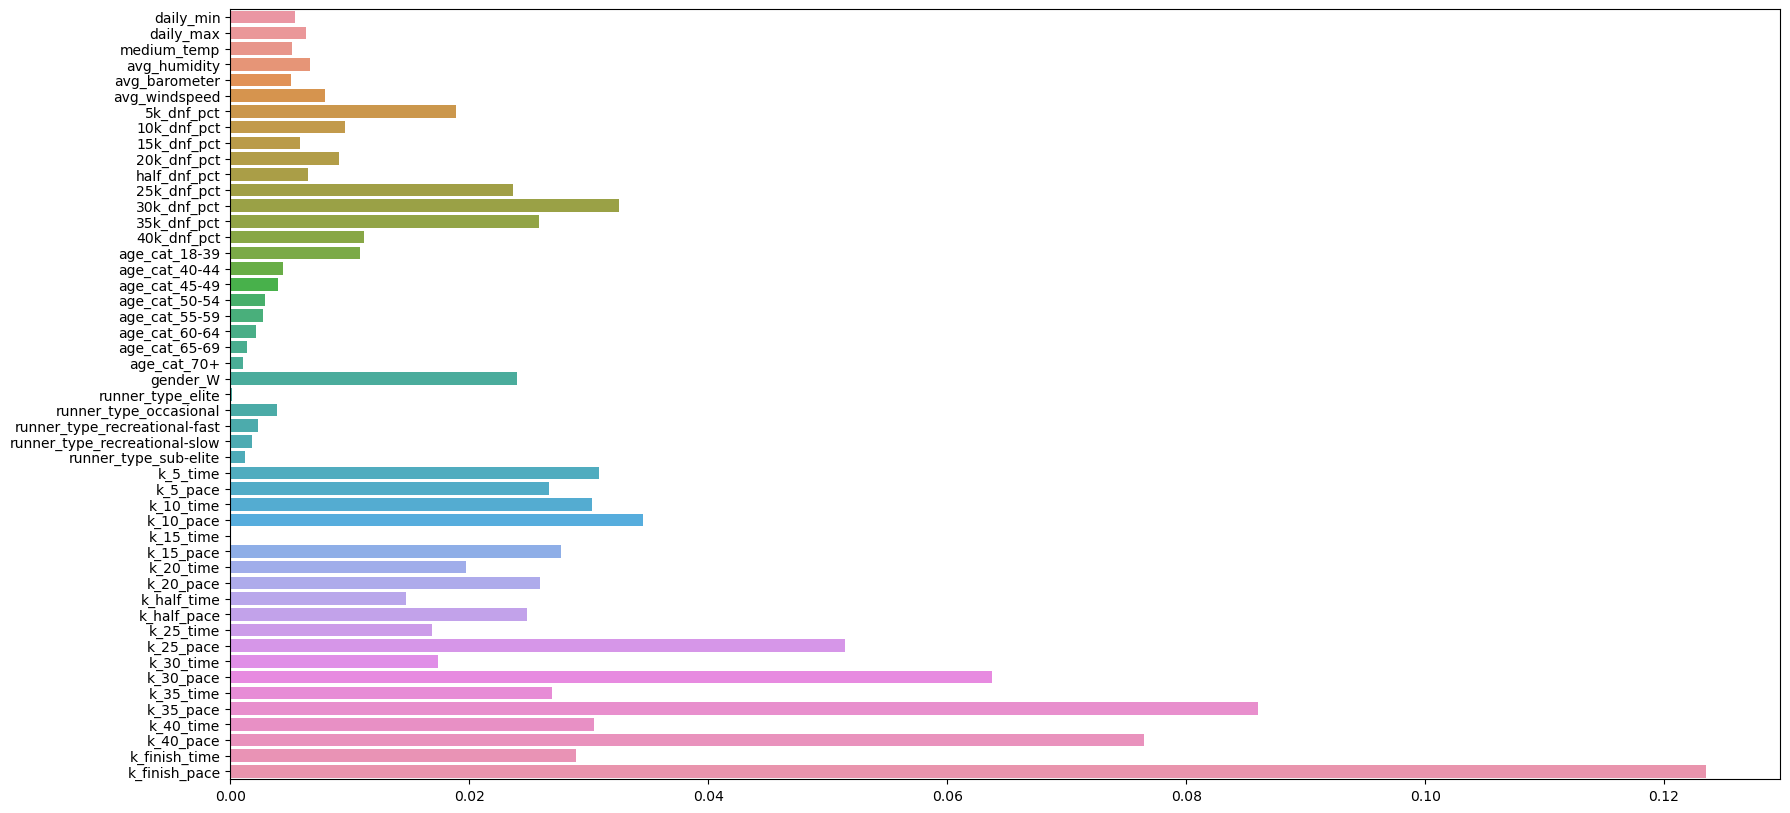

In [28]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_cls.feature_importances_, y=dataset_cols)

In [29]:
y_pred = rfr_cls.predict(X_test)
class_names = ["Finished", "Started"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.22      0.71      0.34      4002

    accuracy                           0.95    205902
   macro avg       0.61      0.83      0.65    205902
weighted avg       0.98      0.95      0.96    205902



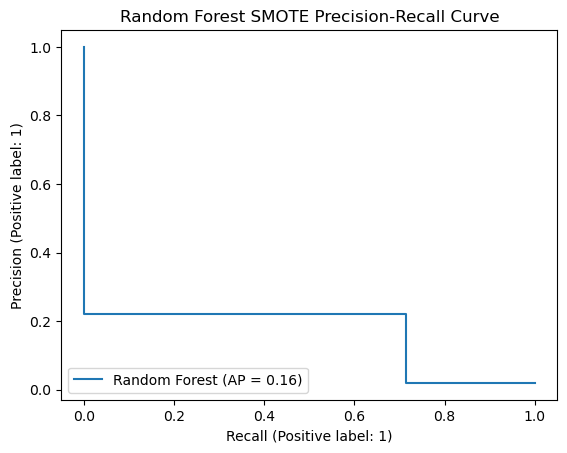

In [30]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Random Forest")
pr_display.ax_.set_title("Random Forest SMOTE Precision-Recall Curve")
plt.show()

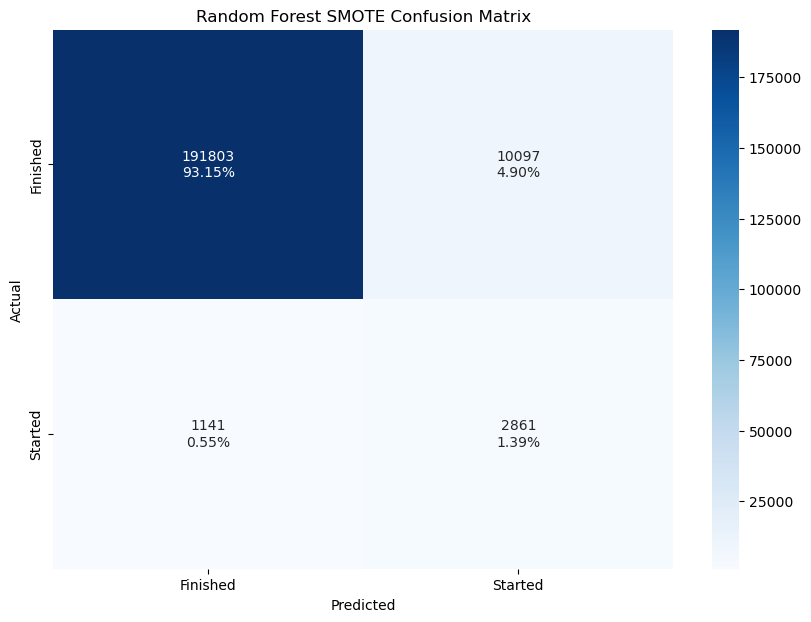

In [31]:
plot_confusion_matrix(y_test, y_pred, class_names, title="Random Forest SMOTE Confusion Matrix")

In [32]:
save_sklearn_model(rfr_cls, "RandomForest_SMOTE", MODEL_CLASS_SAVE_OVER)

Model saved to Models/Classification/Oversampled/RandomForest_SMOTE.joblib


In [33]:
del rfr_cls

#### Balanced Random Forest:

In [34]:
brf_cls = BalancedRandomForestClassifier(n_estimators=100, max_depth=20, sampling_strategy="all", replacement=True, 
                                         min_samples_leaf=2, min_samples_split=4, random_state=17, n_jobs=-1)

In [35]:
brf_cls.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=2,
                               min_samples_split=4, n_jobs=-1, random_state=17,
                               replacement=True, sampling_strategy='all')

<Axes: >

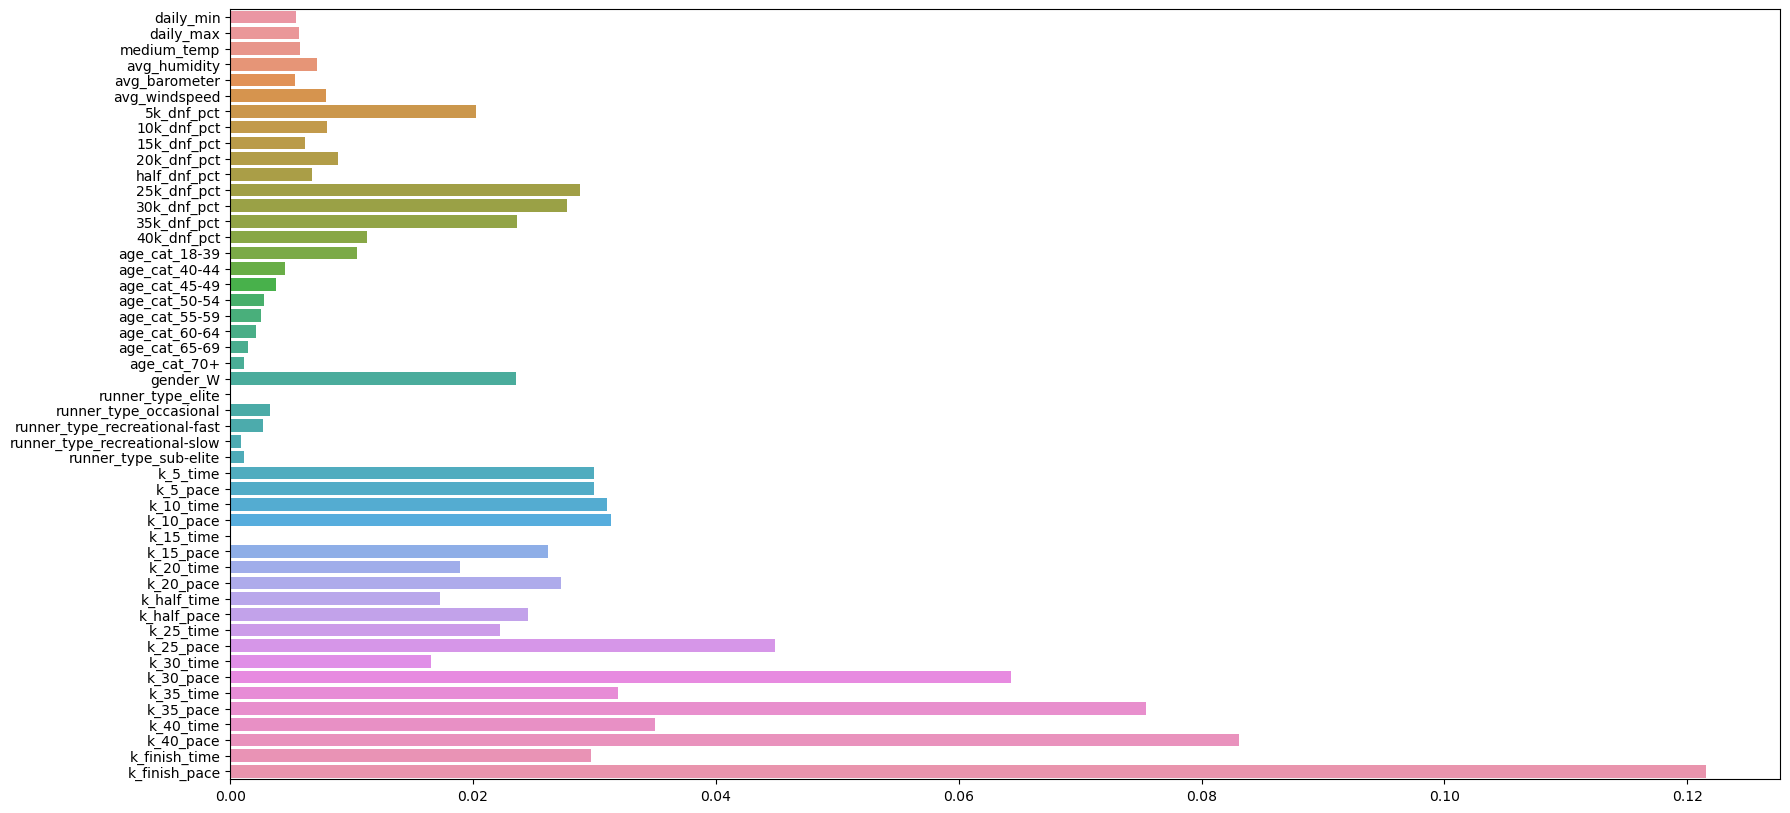

In [36]:
plt.figure(figsize=(20, 10))
sns.barplot(x=brf_cls.feature_importances_, y=dataset_cols)

In [37]:
y_pred = brf_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.22      0.73      0.33      4002

    accuracy                           0.94    205902
   macro avg       0.61      0.84      0.65    205902
weighted avg       0.98      0.94      0.96    205902



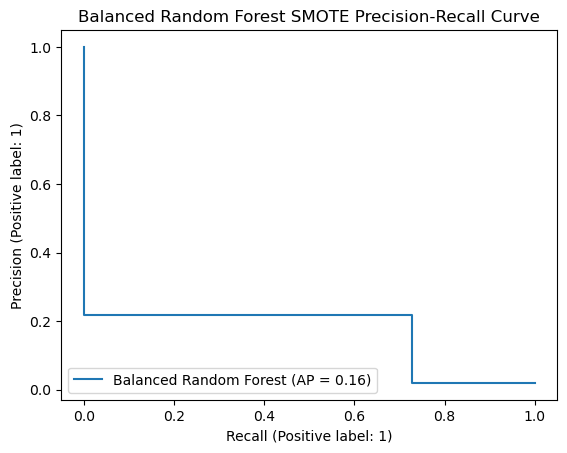

In [38]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Balanced Random Forest")
pr_display.ax_.set_title("Balanced Random Forest SMOTE Precision-Recall Curve")
plt.show()

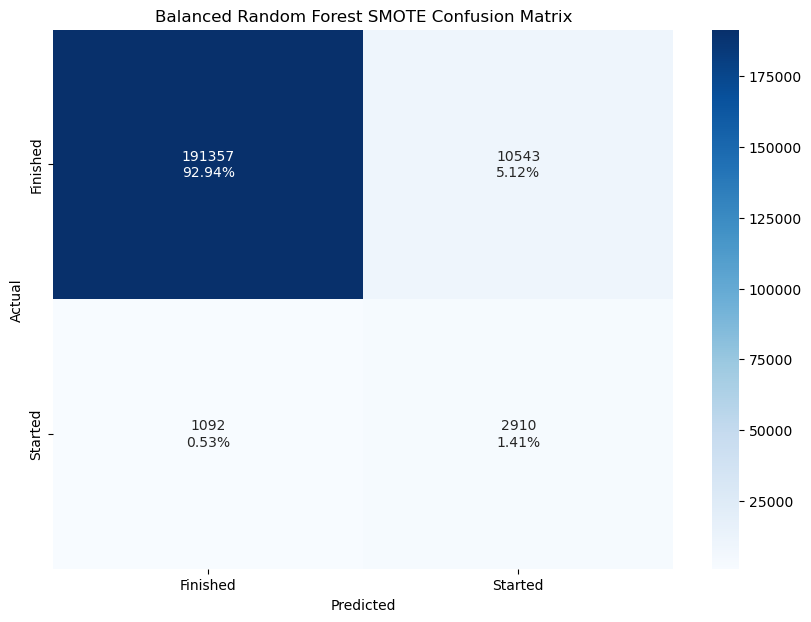

In [39]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Balanced Random Forest SMOTE Confusion Matrix")

In [40]:
save_sklearn_model(brf_cls, "BalancedRandomForest_SMOTE", MODEL_CLASS_SAVE_OVER)

Model saved to Models/Classification/Oversampled/BalancedRandomForest_SMOTE.joblib


In [41]:
del brf_cls

#### XGBoost:

In [42]:
xgb_cls = XGBClassifier(n_estimators=200, max_depth=20, eval_metric="aucpr", max_delta_step=2,
                        reg_alpha=20, learning_rate=0.8, gamma=0.1, random_state=17, n_jobs=-1, early_stopping_rounds=10)

In [43]:
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_cls.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.97223	validation_1-aucpr:0.38370
[1]	validation_0-aucpr:0.98387	validation_1-aucpr:0.43908
[2]	validation_0-aucpr:0.98937	validation_1-aucpr:0.46474
[3]	validation_0-aucpr:0.99260	validation_1-aucpr:0.49146
[4]	validation_0-aucpr:0.99434	validation_1-aucpr:0.49960
[5]	validation_0-aucpr:0.99555	validation_1-aucpr:0.50426
[6]	validation_0-aucpr:0.99612	validation_1-aucpr:0.50412
[7]	validation_0-aucpr:0.99674	validation_1-aucpr:0.50560
[8]	validation_0-aucpr:0.99699	validation_1-aucpr:0.50598
[9]	validation_0-aucpr:0.99740	validation_1-aucpr:0.50374
[10]	validation_0-aucpr:0.99776	validation_1-aucpr:0.50371
[11]	validation_0-aucpr:0.99788	validation_1-aucpr:0.50419
[12]	validation_0-aucpr:0.99827	validation_1-aucpr:0.50538
[13]	validation_0-aucpr:0.99840	validation_1-aucpr:0.50467
[14]	validation_0-aucpr:0.99857	validation_1-aucpr:0.50855
[15]	validation_0-aucpr:0.99878	validation_1-aucpr:0.51736
[16]	validation_0-aucpr:0.99888	validation_1-aucpr:0.51588
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

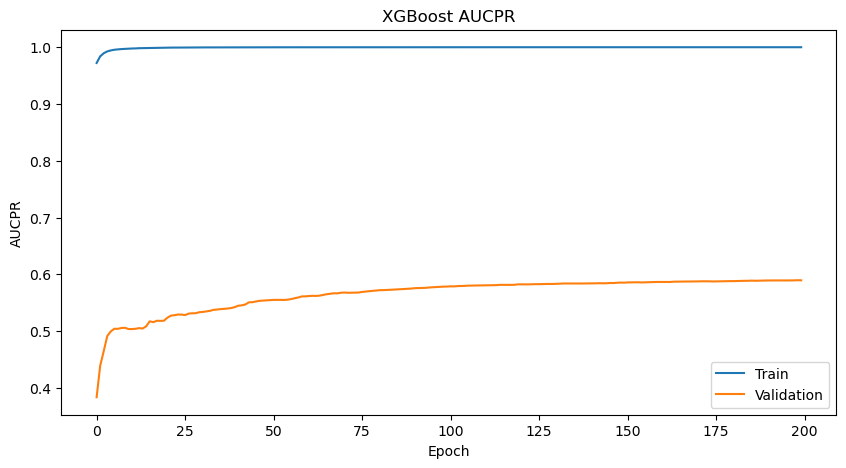

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(xgb_cls.evals_result_["validation_0"]["aucpr"], label="Train")
plt.plot(xgb_cls.evals_result_["validation_1"]["aucpr"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUCPR")
plt.title("XGBoost AUCPR")

plt.show()

<Axes: >

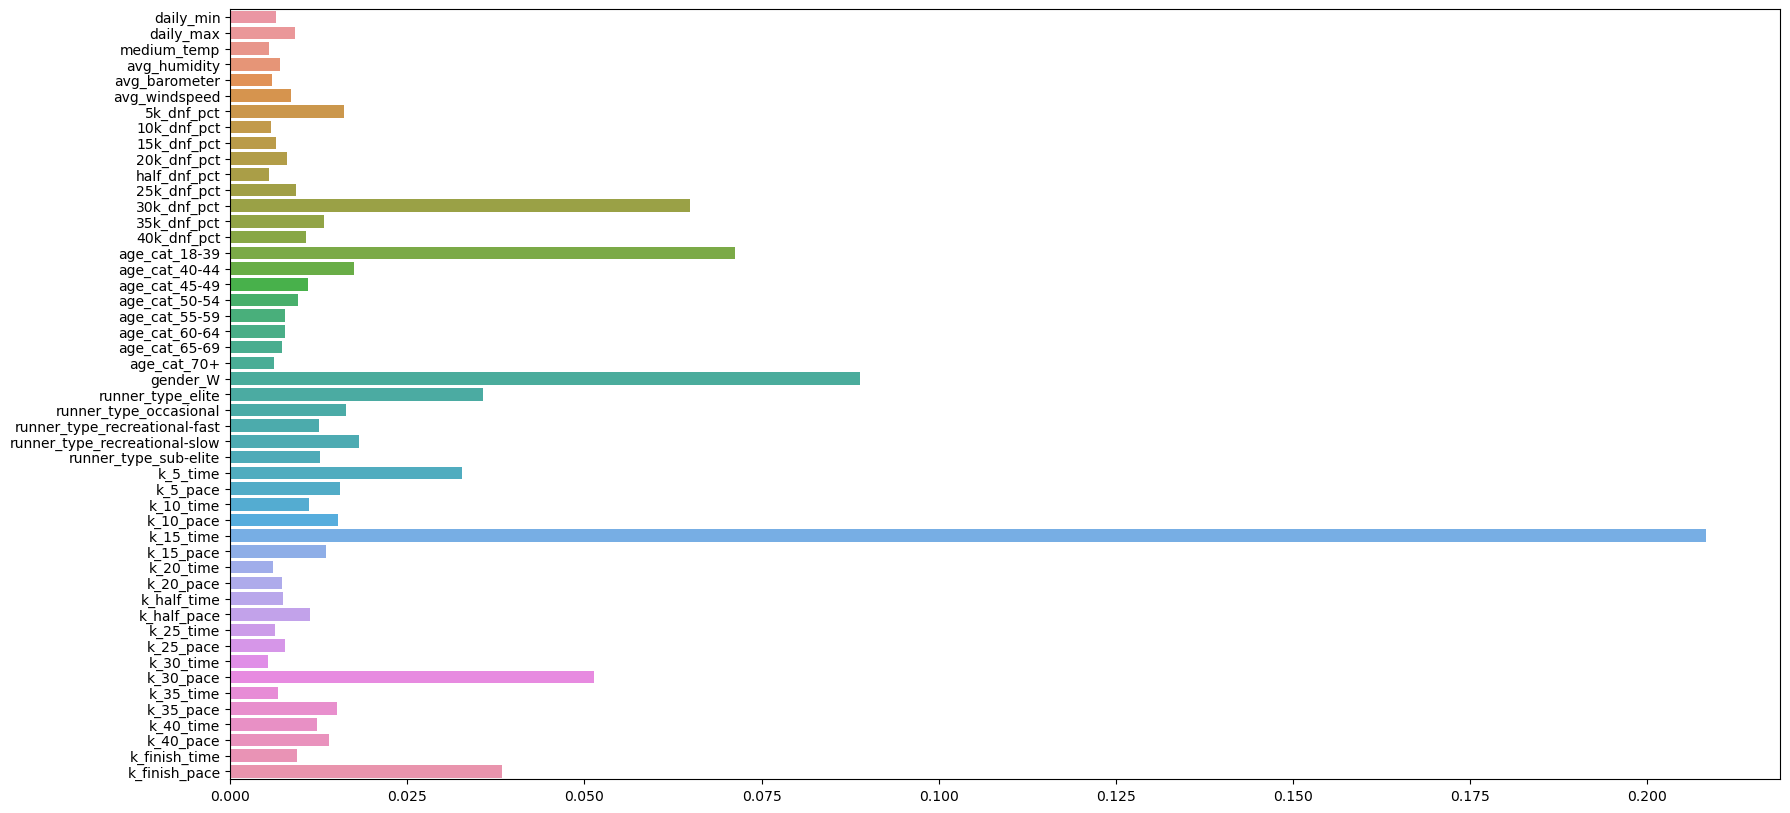

In [45]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_cls.feature_importances_, y=dataset_cols)

In [46]:
y_pred = xgb_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.99      0.99    201900
     Started       0.54      0.55      0.54      4002

    accuracy                           0.98    205902
   macro avg       0.77      0.77      0.77    205902
weighted avg       0.98      0.98      0.98    205902



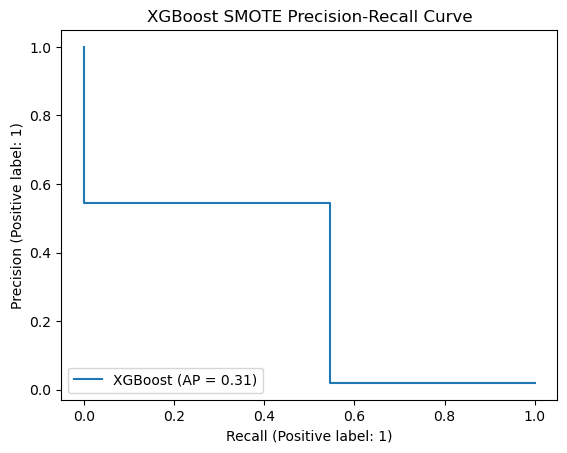

In [47]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="XGBoost")
pr_display.ax_.set_title("XGBoost SMOTE Precision-Recall Curve")
plt.show()

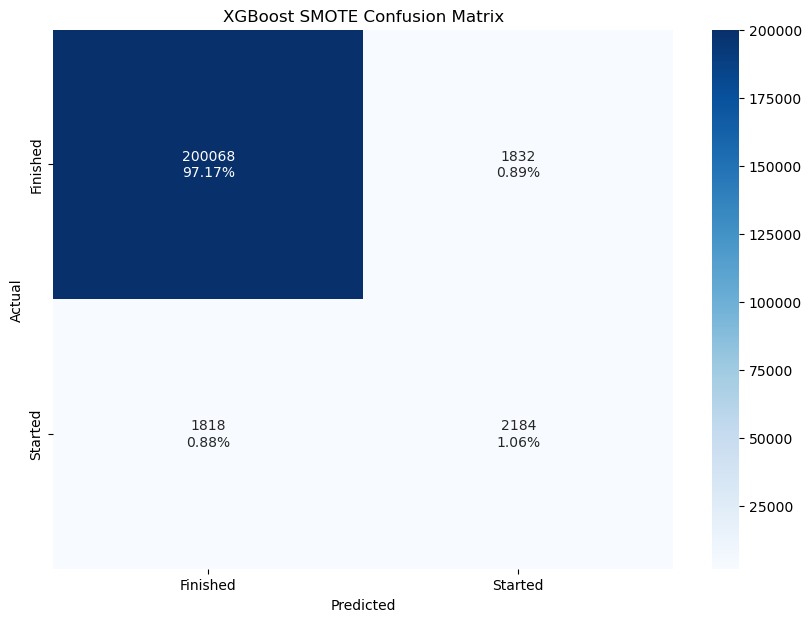

In [48]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="XGBoost SMOTE Confusion Matrix")

In [49]:
xgb_cls.save_model(f"{MODEL_CLASS_SAVE_OVER}XGBoost_SMOTE.json")

In [50]:
del xgb_cls

#### Neural Network:

### Extended SMOTEENN Dataset:

In [8]:
# IMPORTANT: Ensure that X_train and y_train are the original extended data and not the over-sampled data.
print(f"Samples' Count Before Over-Sampling: {np.unique(y_train, return_counts=True)}")
# Define the under-sampling method.
enn = EditedNearestNeighbours(n_neighbors=5, n_jobs=-1)
# Define the over-sampling method.
smote = SMOTE(k_neighbors=5)
# Define the hybrid method.
smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=17)
############ N.B This will take a long time. (6 minutes), only run if the numpy files are not present ###############
# Apply over-sampling.
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)
# np.save(f"{OTHER_DATA_PATH}/X_train_smoteenn.npy", X_train)
# np.save(f"{OTHER_DATA_PATH}/y_train_smoteen.npy", y_train)
########################################## N.B END #############################################
X_train = np.load(f"{OTHER_DATA_PATH}/X_train_smoteenn.npy")
y_train = np.load(f"{OTHER_DATA_PATH}/y_train_smoteen.npy")
print(f"Samples' Count After Over-Sampling: {np.unique(y_train, return_counts=True)}")

Samples' Count Before Over-Sampling: (array([0, 1]), array([605698,  12007]))
Samples' Count After Over-Sampling: (array([0, 1]), array([605698, 599818]))


#### KNN:

In [9]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')

In [10]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [11]:
y_pred = knn_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.92      0.95    201900
     Started       0.13      0.60      0.21      4002

    accuracy                           0.91    205902
   macro avg       0.56      0.76      0.58    205902
weighted avg       0.97      0.91      0.94    205902



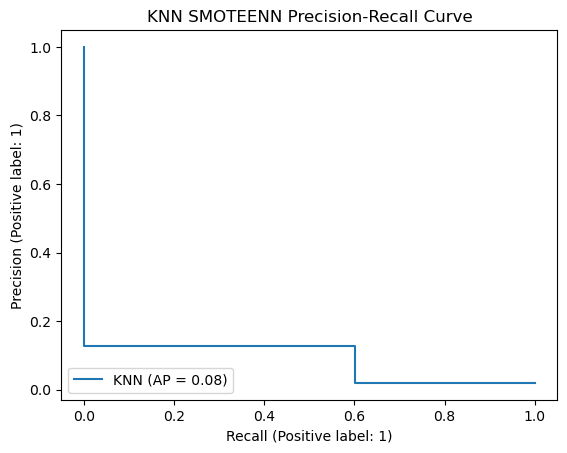

In [12]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="KNN")
pr_display.ax_.set_title("KNN SMOTEENN Precision-Recall Curve")
plt.show()

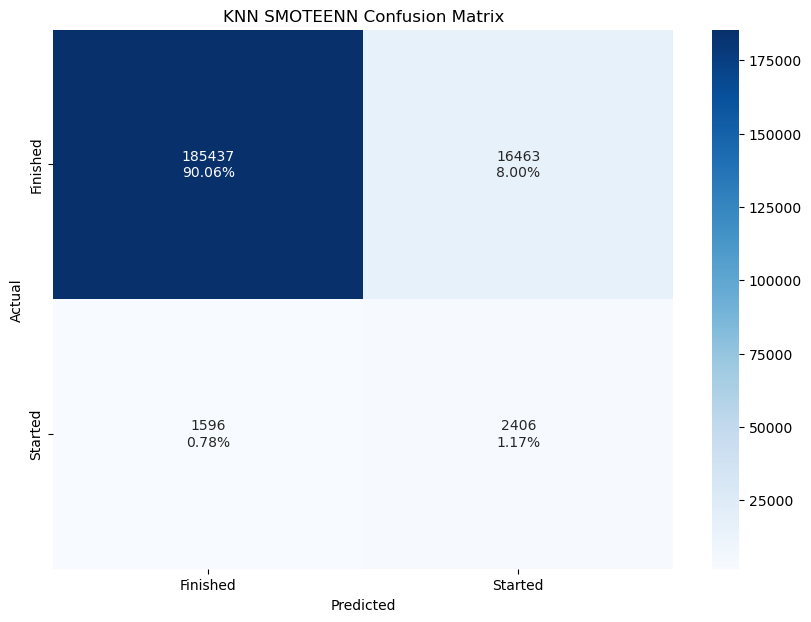

In [13]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="KNN SMOTEENN Confusion Matrix")

In [14]:
save_sklearn_model(knn_cls, "KNN_SMOTEENN", MODEL_CLASS_SAVE_HYBRID)

Model saved to Models/Classification/Hybrid/KNN_SMOTEENN.joblib


In [15]:
del knn_cls

#### Random Forest:

In [16]:
rfr_cls = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=2, min_samples_split=4, criterion='gini', random_state=17, n_jobs=-1)

In [17]:
rfr_cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_jobs=-1, random_state=17)

<Axes: >

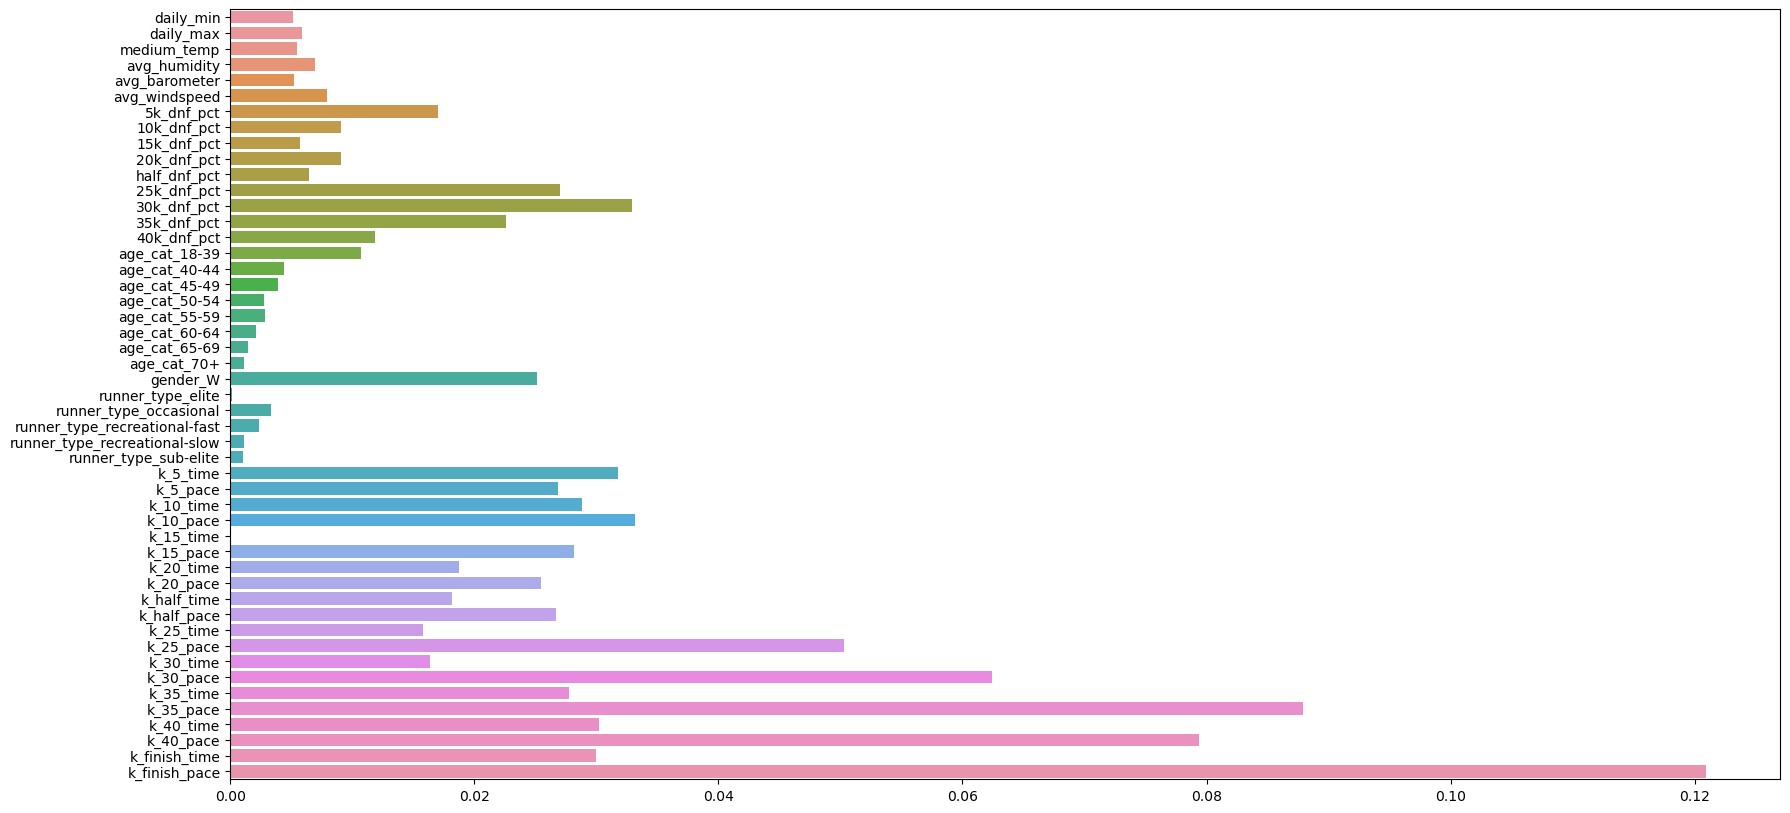

In [18]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_cls.feature_importances_, y=dataset_cols)

In [19]:
y_pred = rfr_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.23      0.71      0.34      4002

    accuracy                           0.95    205902
   macro avg       0.61      0.83      0.66    205902
weighted avg       0.98      0.95      0.96    205902



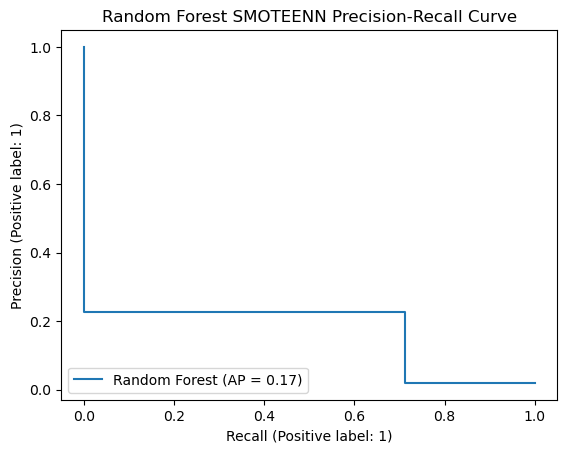

In [20]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Random Forest")
pr_display.ax_.set_title("Random Forest SMOTEENN Precision-Recall Curve")
plt.show()

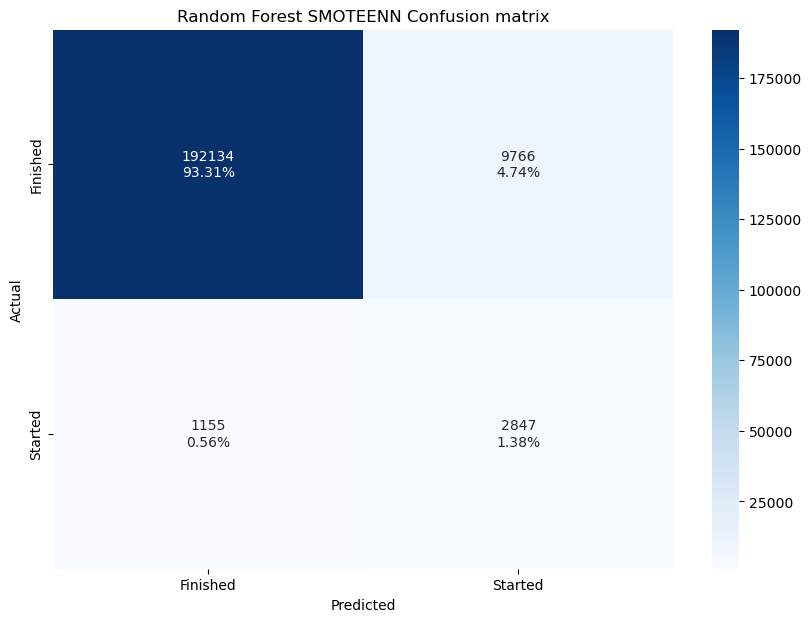

In [21]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title='Random Forest SMOTEENN Confusion matrix')

In [22]:
save_sklearn_model(rfr_cls, "RandomForest_SMOTEENN", MODEL_CLASS_SAVE_HYBRID)

Model saved to Models/Classification/Hybrid/RandomForest_SMOTEENN.joblib


In [23]:
del rfr_cls

#### Balanced Random Forest:

In [24]:
brf_cls = BalancedRandomForestClassifier(n_estimators=100, max_depth=20, sampling_strategy="all", replacement=True, 
                                         min_samples_leaf=2, min_samples_split=4, random_state=17, n_jobs=-1)

In [25]:
brf_cls.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=2,
                               min_samples_split=4, n_jobs=-1, random_state=17,
                               replacement=True, sampling_strategy='all')

<Axes: >

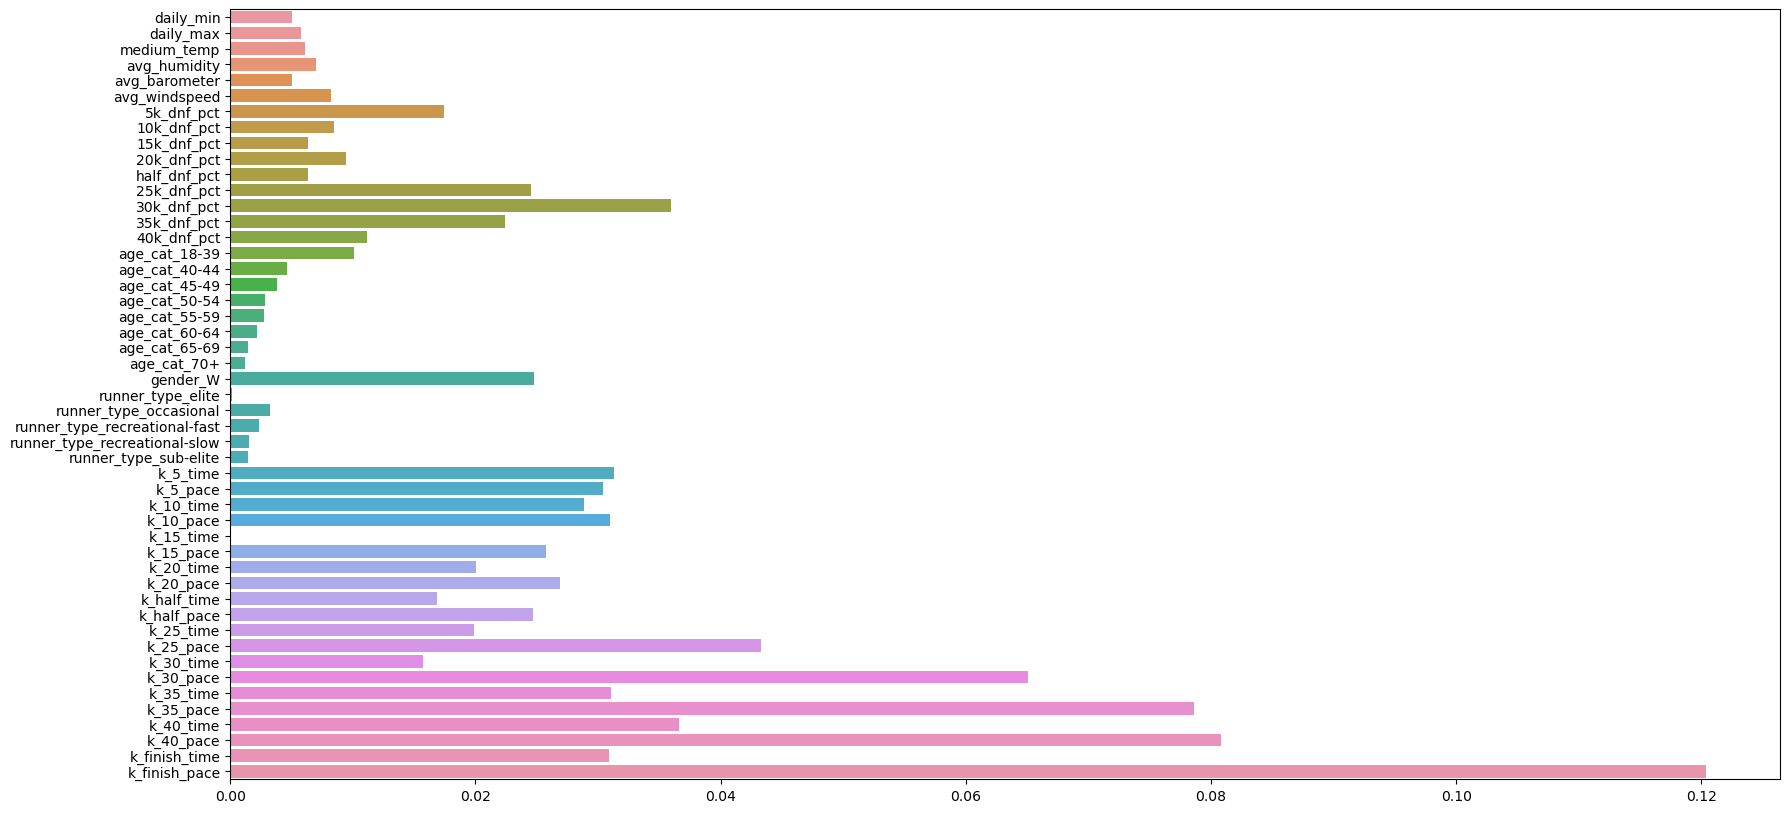

In [26]:
plt.figure(figsize=(20, 10))
sns.barplot(x=brf_cls.feature_importances_, y=dataset_cols)

In [27]:
y_pred = brf_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.22      0.72      0.33      4002

    accuracy                           0.94    205902
   macro avg       0.61      0.83      0.65    205902
weighted avg       0.98      0.94      0.96    205902



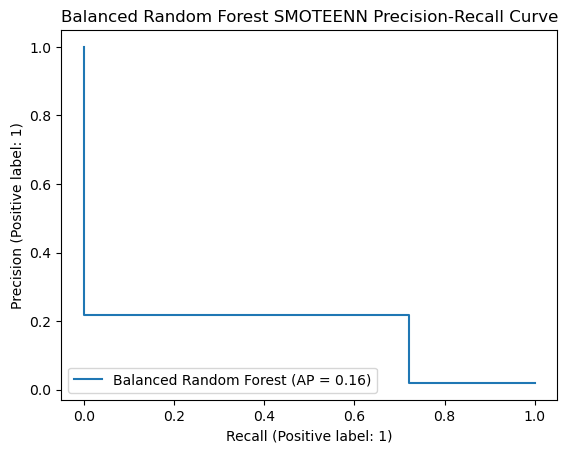

In [28]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Balanced Random Forest")
pr_display.ax_.set_title("Balanced Random Forest SMOTEENN Precision-Recall Curve")
plt.show()

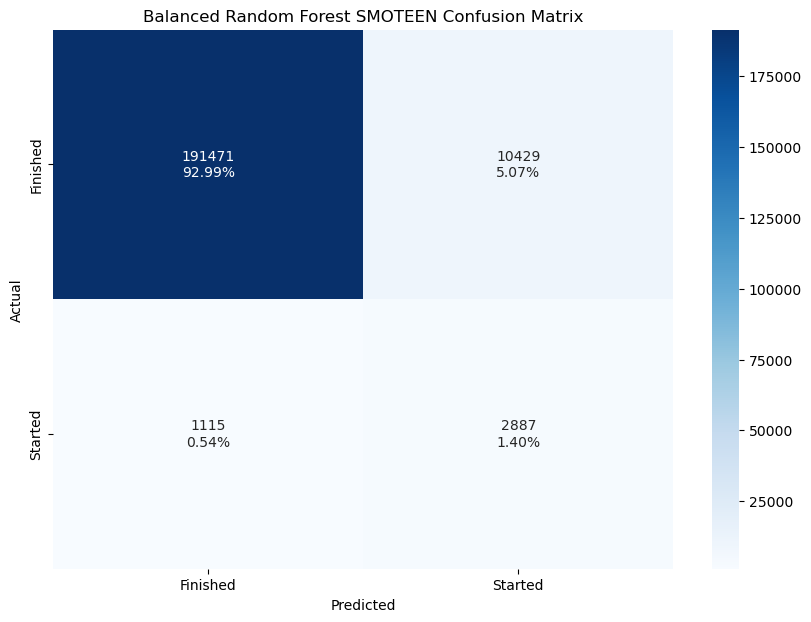

In [29]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Balanced Random Forest SMOTEEN Confusion Matrix")

In [30]:
save_sklearn_model(brf_cls, "BalancedRandomForest_SMOTEENN", MODEL_CLASS_SAVE_HYBRID)

Model saved to Models/Classification/Hybrid/BalancedRandomForest_SMOTEENN.joblib


In [31]:
del brf_cls

#### XGBoost:

In [33]:
xgb_cls = XGBClassifier(n_estimators=200, max_depth=20, eval_metric="aucpr", max_delta_step=2,
                        reg_alpha=20, learning_rate=0.8, gamma=0.1, random_state=17, n_jobs=-1, early_stopping_rounds=10)

In [34]:
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_cls.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.97322	validation_1-aucpr:0.40744
[1]	validation_0-aucpr:0.98470	validation_1-aucpr:0.44391
[2]	validation_0-aucpr:0.98951	validation_1-aucpr:0.47028
[3]	validation_0-aucpr:0.99214	validation_1-aucpr:0.48874
[4]	validation_0-aucpr:0.99474	validation_1-aucpr:0.50065
[5]	validation_0-aucpr:0.99534	validation_1-aucpr:0.49982
[6]	validation_0-aucpr:0.99635	validation_1-aucpr:0.50630
[7]	validation_0-aucpr:0.99719	validation_1-aucpr:0.50733
[8]	validation_0-aucpr:0.99752	validation_1-aucpr:0.50975
[9]	validation_0-aucpr:0.99788	validation_1-aucpr:0.51077
[10]	validation_0-aucpr:0.99817	validation_1-aucpr:0.51571
[11]	validation_0-aucpr:0.99844	validation_1-aucpr:0.51543
[12]	validation_0-aucpr:0.99853	validation_1-aucpr:0.51512
[13]	validation_0-aucpr:0.99866	validation_1-aucpr:0.51547
[14]	validation_0-aucpr:0.99873	validation_1-aucpr:0.51559
[15]	validation_0-aucpr:0.99882	validation_1-aucpr:0.51677
[16]	validation_0-aucpr:0.99896	validation_1-aucpr:0.51603
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

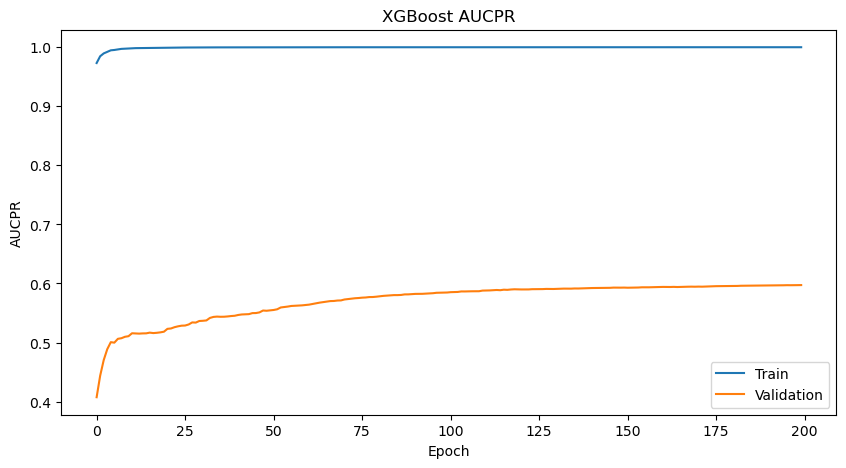

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(xgb_cls.evals_result_["validation_0"]["aucpr"], label="Train")
plt.plot(xgb_cls.evals_result_["validation_1"]["aucpr"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUCPR")
plt.title("XGBoost AUCPR")
plt.show()

<Axes: >

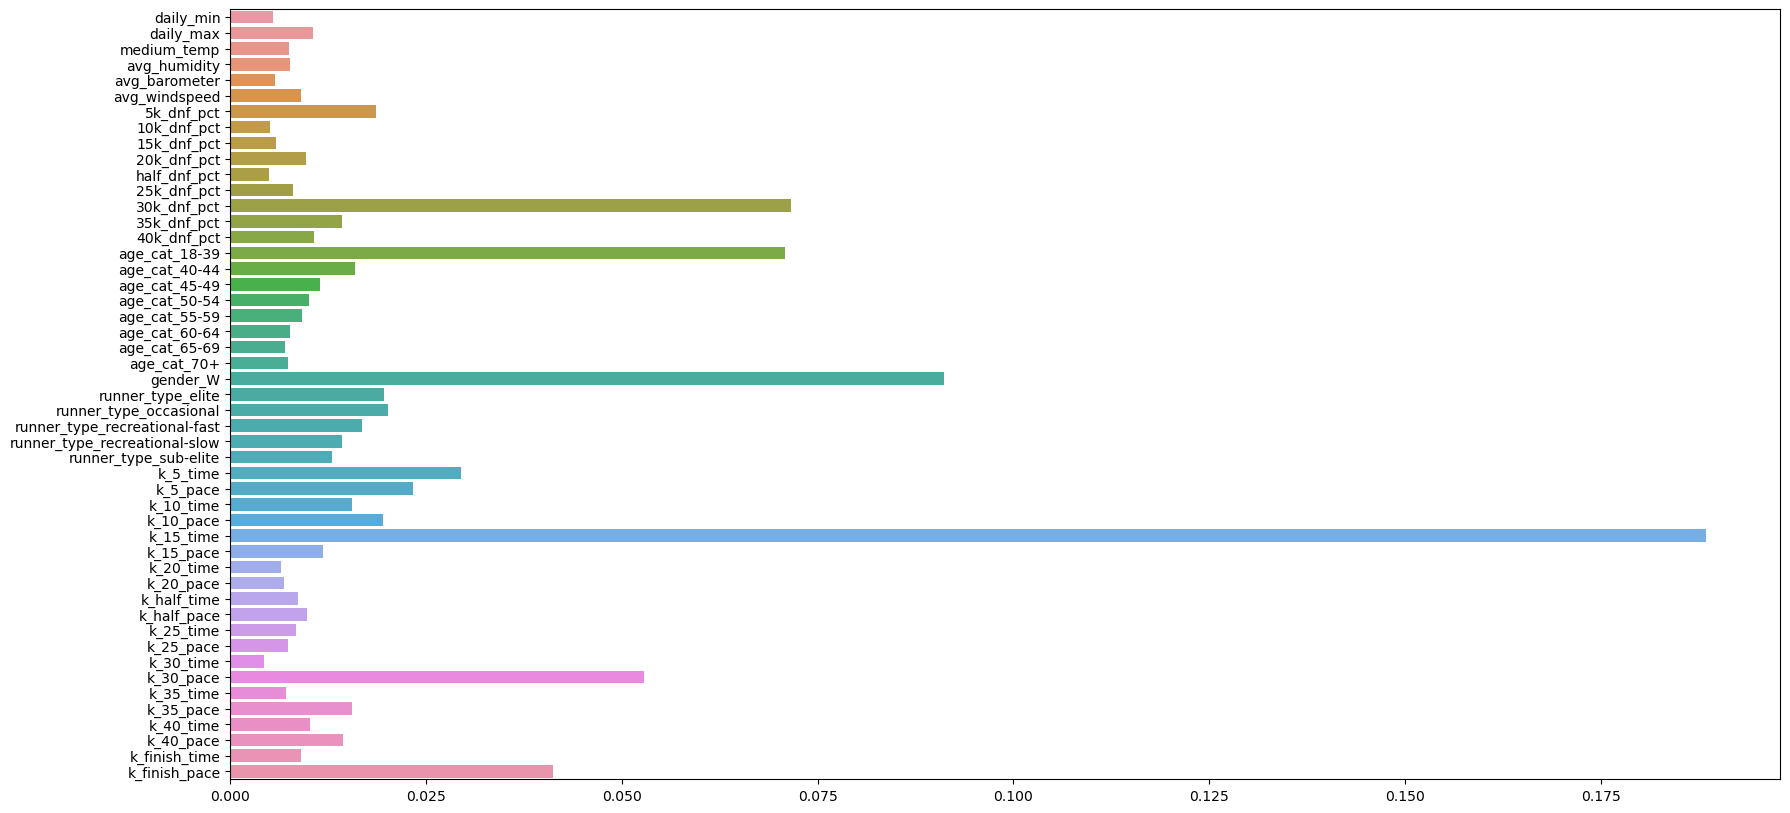

In [36]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_cls.feature_importances_, y=dataset_cols)

In [37]:
y_pred = xgb_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.99      0.99    201900
     Started       0.57      0.55      0.56      4002

    accuracy                           0.98    205902
   macro avg       0.78      0.77      0.78    205902
weighted avg       0.98      0.98      0.98    205902



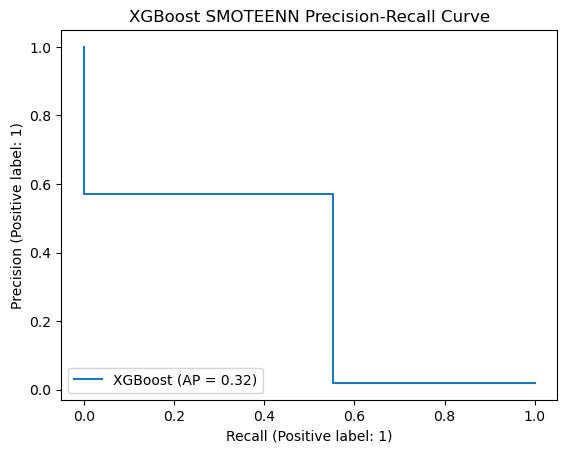

In [38]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="XGBoost")
pr_display.ax_.set_title("XGBoost SMOTEENN Precision-Recall Curve")
plt.show()

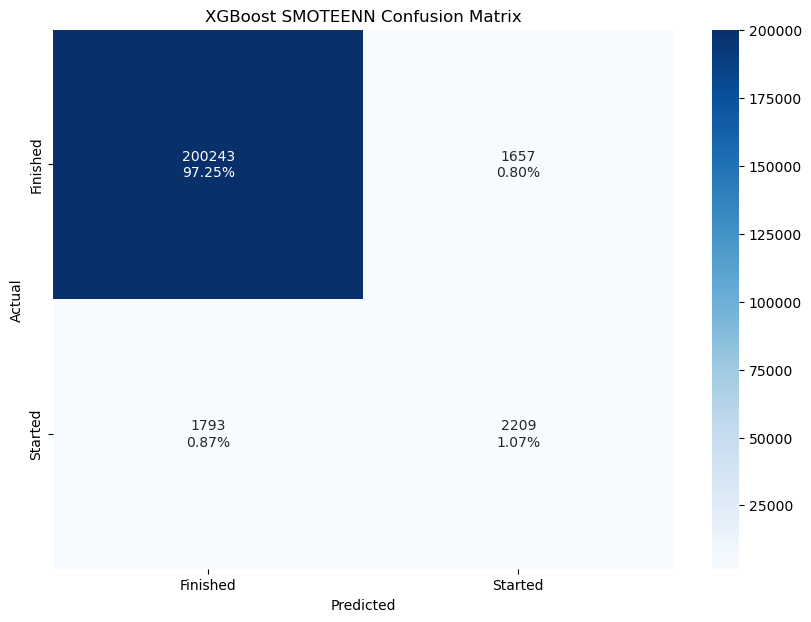

In [39]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="XGBoost SMOTEENN Confusion Matrix")

In [40]:
xgb_cls.save_model(f"{MODEL_CLASS_SAVE_HYBRID}XGBoost_SMOTEENN.json")

In [41]:
del xgb_cls

#### Neural Network:

## Marathon Performance Prediction:

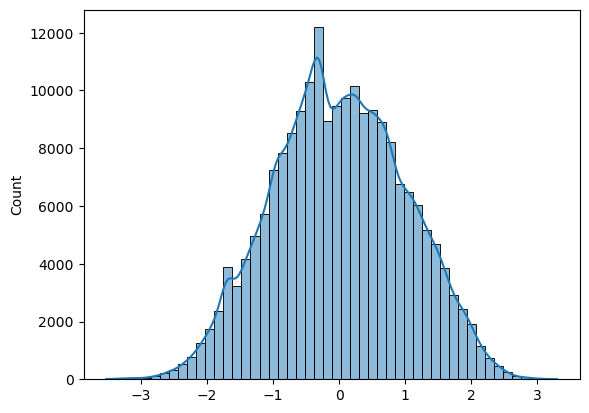

In [7]:
sns.histplot(y_test, bins=50, kde=True);

### KNN:

In [11]:
knn_reg = KNeighborsRegressor(n_neighbors=10, n_jobs=-1, weights='distance')

In [ ]:
# cv_score = cross_val_score(knn_reg, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
# print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

In [14]:
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=10, weights='distance')

In [12]:
y_pred = knn_reg.predict(X_test)

In [13]:
# Get the unscaled y_pred, since the target variable was scaled before training the model.
y_pred_unscaled = p_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# Get the unscaled y_test.
y_test_unscaled = p_transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [14]:
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False).round(0)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled).round(0)
mape = (mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)*100).round(2)
print(f"Mean Squared Error: {mse}\n")
print(f"Mean Absolute Error: {mae}\n")
print(f"Mean Absolute Percentage Error: {mape}%\n")

Mean Squared Error: 593.0

Mean Absolute Error: 423.0

Mean Absolute Percentage Error: 2.64%



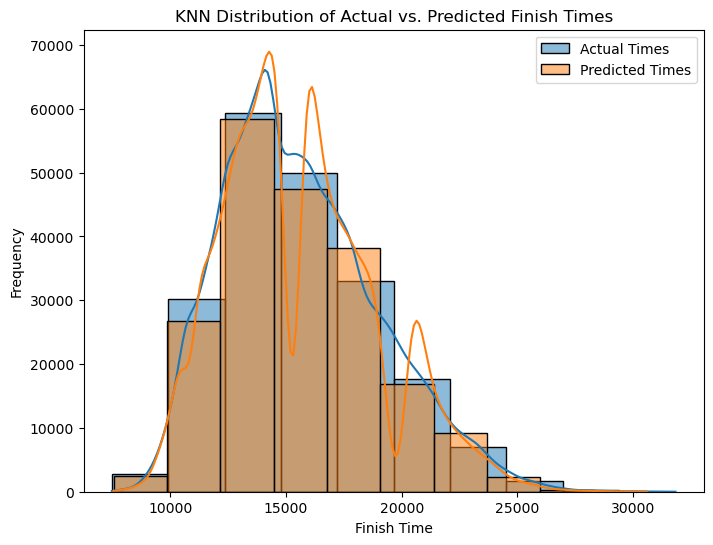

In [15]:
plot_performance_distribution(y_test_unscaled, y_pred_unscaled, "KNN Distribution of Actual vs. Predicted Finish Times", bins=10)

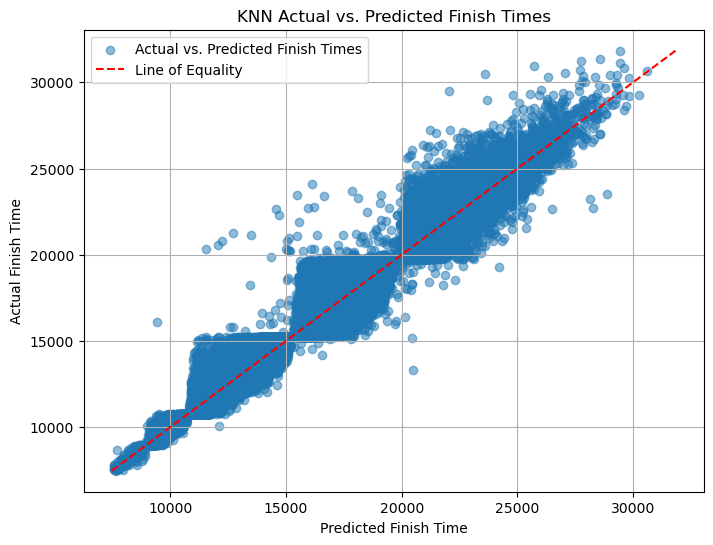

In [16]:
plot_performance_comparison(y_test_unscaled, y_pred_unscaled, title="KNN Actual vs. Predicted Finish Times")

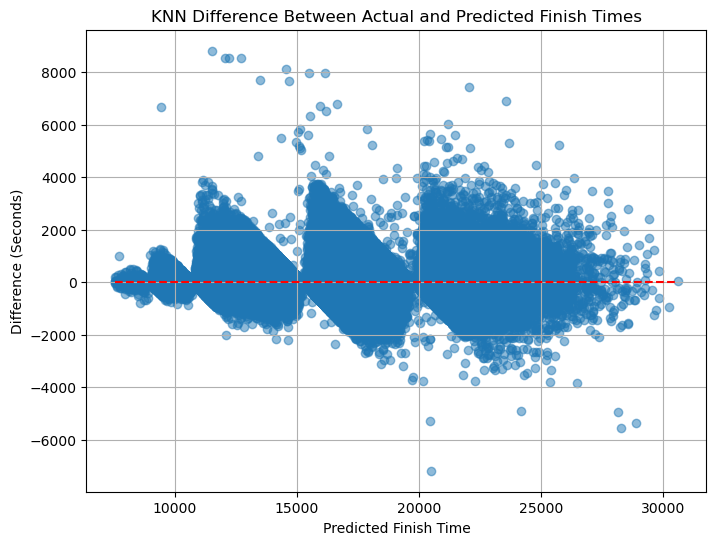

In [17]:
plot_performance_diff(y_test_unscaled, y_pred_unscaled, title="KNN Difference Between Actual and Predicted Finish Times")

In [20]:
save_sklearn_model(knn_reg, "KNN_marath_perf", MODEL_REG_SAVE_NORMAL)

Model saved to Models/Regression/Normal/KNN_marth_perf.joblib


In [18]:
del knn_reg

In [11]:
# Run to load the KNN model.
knn_reg = load_sklearn_model("KNN_marath_perf", MODEL_REG_SAVE_NORMAL)

Model loaded from Models/Regression/Normal/KNN_marath_perf.joblib


### Random Forest:

In [22]:
rfr_rgr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=17, n_jobs=-1)

In [23]:
rfr_rgr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=17)

<Axes: >

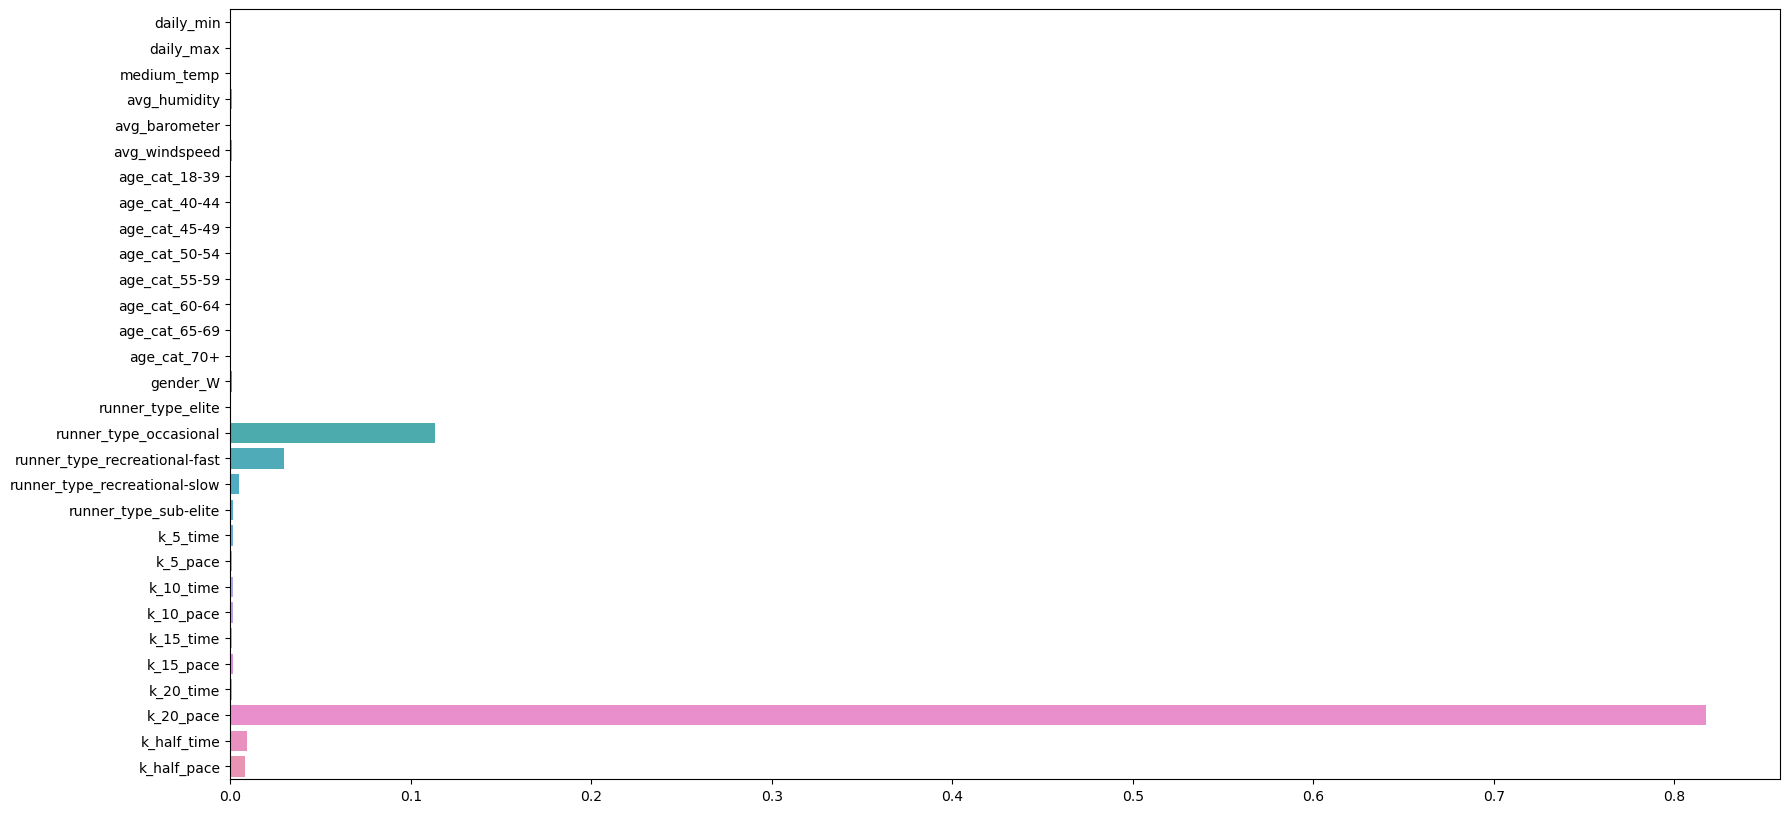

In [24]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_rgr.feature_importances_, y=dataset_cols)

In [20]:
y_pred = rfr_rgr.predict(X_test)

In [21]:
# Get the unscaled y_pred, since the target variable was scaled before training the model.
y_pred_unscaled = p_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# Get the unscaled y_test.
y_test_unscaled = p_transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
# cv_5 = cross_val_score(rfr_rgr, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
# print(f"Mean Cross Validation Score k=5: {cv_5}\n")

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False).round(0)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled).round(0)
mape = (mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)*100).round(2)
print(f"Mean Squared Error: {mse}\n")
print(f"Mean Absolute Error: {mae}\n")
print(f"Mean Absolute Percentage Error: {mape}%\n")

Mean Squared Error: 551.0

Mean Absolute Error: 396.0

Mean Absolute Percentage Error: 2.48%



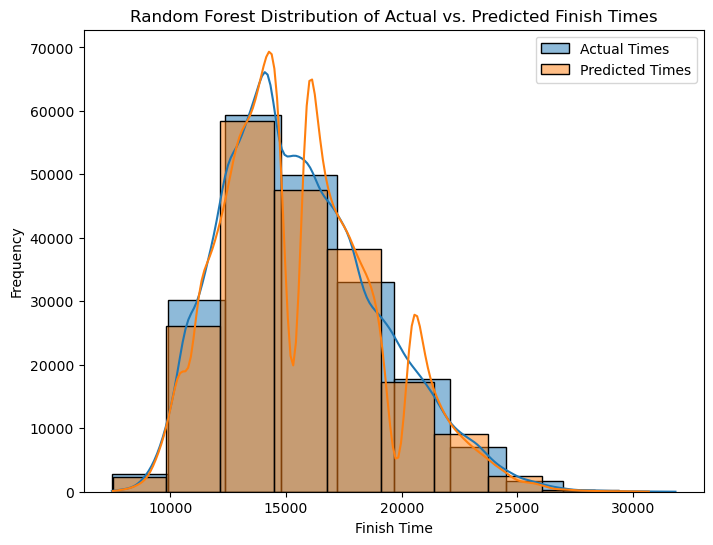

In [22]:
plot_performance_distribution(y_test_unscaled, y_pred_unscaled, title="Random Forest Distribution of Actual vs. Predicted Finish Times", bins=10)

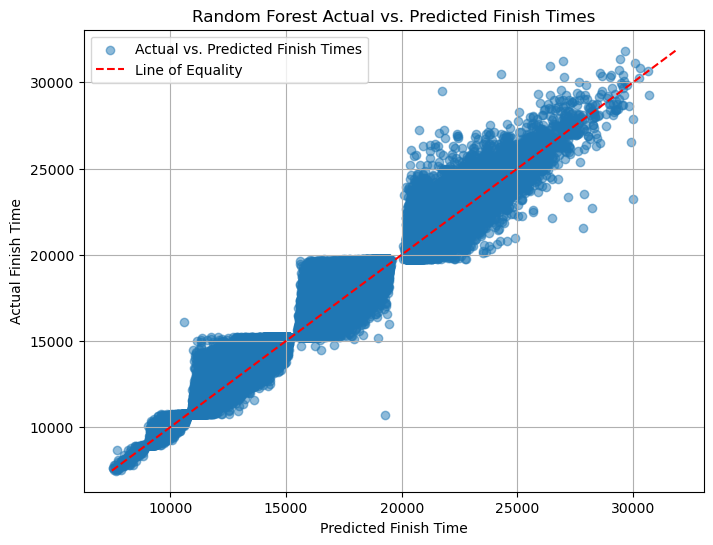

In [23]:
plot_performance_comparison(y_test_unscaled, y_pred_unscaled, title="Random Forest Actual vs. Predicted Finish Times")

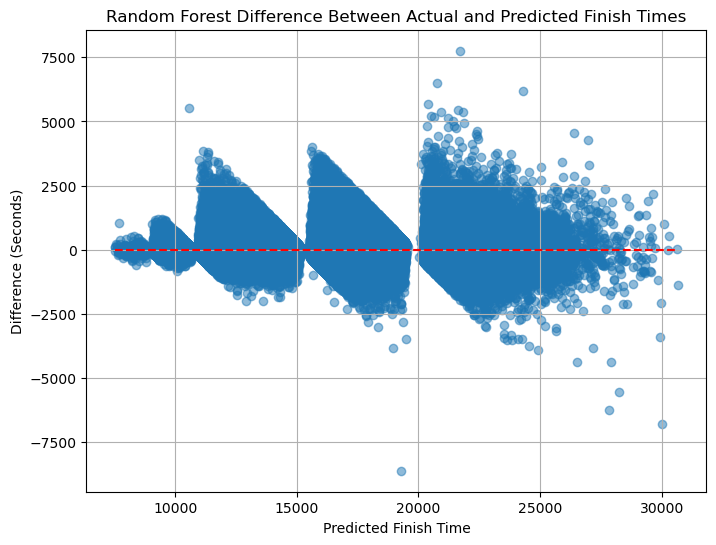

In [24]:
plot_performance_diff(y_test_unscaled, y_pred_unscaled, title="Random Forest Difference Between Actual and Predicted Finish Times")

In [28]:
save_sklearn_model(rfr_rgr, "RandomForest_marath_perf", MODEL_REG_SAVE_NORMAL)

Model saved to Models/Regression/Normal/RandomForest_marth_perf.joblib


In [25]:
del rfr_rgr

In [19]:
# Run to load the Random Forest model.
rfr_rgr = load_sklearn_model("RandomForest_marath_perf", MODEL_REG_SAVE_NORMAL)

Model loaded from Models/Regression/Normal/RandomForest_marath_perf.joblib


### XGBoost:

In [89]:
xgb_rgr = XGBRegressor(n_estimators=100, max_depth=20, random_state=17, eval_metric=["mae", "rmse"], n_jobs=-1, reg_alpha=4)

In [90]:
xgb_rgr.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-mae:0.64610	validation_0-rmse:0.79146	validation_1-mae:0.64812	validation_1-rmse:0.79346
[1]	validation_0-mae:0.46293	validation_0-rmse:0.56633	validation_1-mae:0.46473	validation_1-rmse:0.56797
[2]	validation_0-mae:0.33735	validation_0-rmse:0.41288	validation_1-mae:0.33911	validation_1-rmse:0.41440
[3]	validation_0-mae:0.25325	validation_0-rmse:0.31062	validation_1-mae:0.25505	validation_1-rmse:0.31230
[4]	validation_0-mae:0.19891	validation_0-rmse:0.24481	validation_1-mae:0.20080	validation_1-rmse:0.24683
[5]	validation_0-mae:0.16513	validation_0-rmse:0.20437	validation_1-mae:0.16731	validation_1-rmse:0.20694
[6]	validation_0-mae:0.14456	validation_0-rmse:0.18071	validation_1-mae:0.14708	validation_1-rmse:0.18389
[7]	validation_0-mae:0.13209	validation_0-rmse:0.16730	validation_1-mae:0.13505	validation_1-rmse:0.17117
[8]	validation_0-mae:0.12438	validation_0-rmse:0.15970	validation_1-mae:0.12778	validation_1-rmse:0.16430
[9]	validation_0-mae:0.11961	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=17, ...)

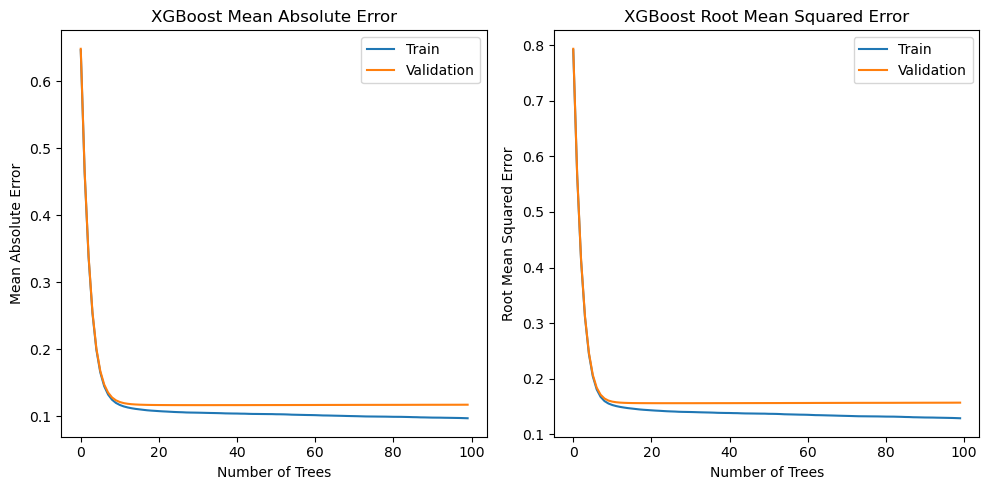

In [91]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(xgb_rgr.evals_result_["validation_0"]["mae"], label="Train")
plt.plot(xgb_rgr.evals_result_["validation_1"]["mae"], label="Validation")
plt.legend()
plt.xlabel("Number of Trees")
plt.ylabel("Mean Absolute Error")
plt.title("XGBoost Mean Absolute Error")

plt.subplot(1, 2, 2)
plt.plot(xgb_rgr.evals_result_["validation_0"]["rmse"], label="Train")
plt.plot(xgb_rgr.evals_result_["validation_1"]["rmse"], label="Validation")
plt.legend()
plt.xlabel("Number of Trees")
plt.ylabel("Root Mean Squared Error")
plt.title("XGBoost Root Mean Squared Error")
plt.tight_layout()
plt.show()

In [ ]:
cv_score = cross_val_score(xgb_rgr, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

<Axes: >

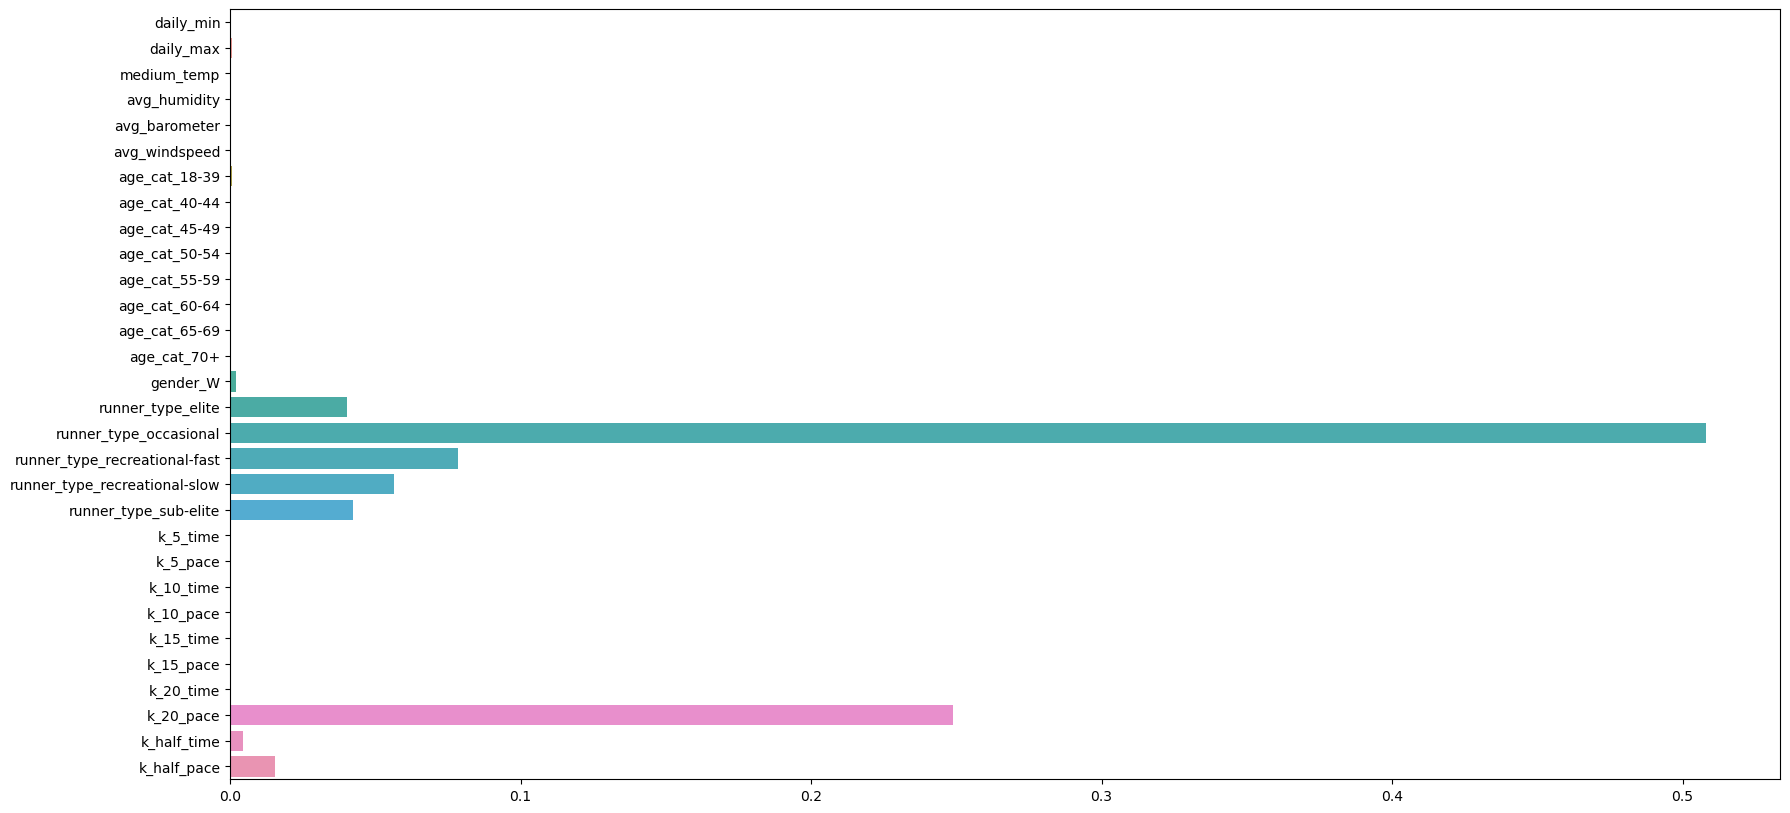

In [92]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_rgr.feature_importances_, y=dataset_cols)

In [93]:
y_pred = xgb_rgr.predict(X_test)

In [94]:
# Get the unscaled y_pred, since the target variable was scaled before training the model.
y_pred_unscaled = p_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# Get the unscaled y_test.
y_test_unscaled = p_transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [96]:
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False).round(0)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled).round(0)
mape = (mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)*100).round(2)
r2 = r2_score(y_test_unscaled, y_pred_unscaled).round(2)
print(f"Root Mean Squared Error: {mse} seconds, {mse/60} minutes\n")
print(f"Mean Absolute Error: {mae} seconds, {mae/60} minutes\n")
print(f"Mean Absolute Percentage Error: {mape}%\n")
print(f"R2 Score: {r2}\n")

Root Mean Squared Error: 553.0 seconds, 9.216666666666667 minutes

Mean Absolute Error: 397.0 seconds, 6.616666666666666 minutes

Mean Absolute Percentage Error: 2.48%

R2 Score: 0.97



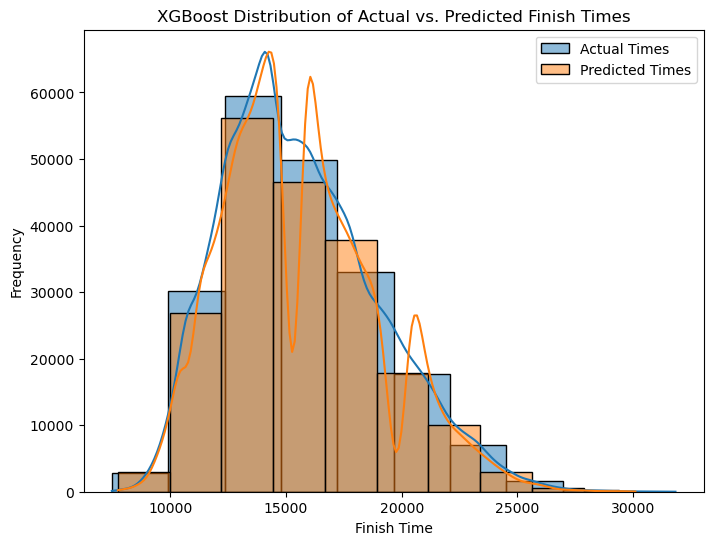

In [149]:
plot_performance_distribution(y_test_unscaled, y_pred_unscaled, title="XGBoost Distribution of Actual vs. Predicted Finish Times", bins=10)

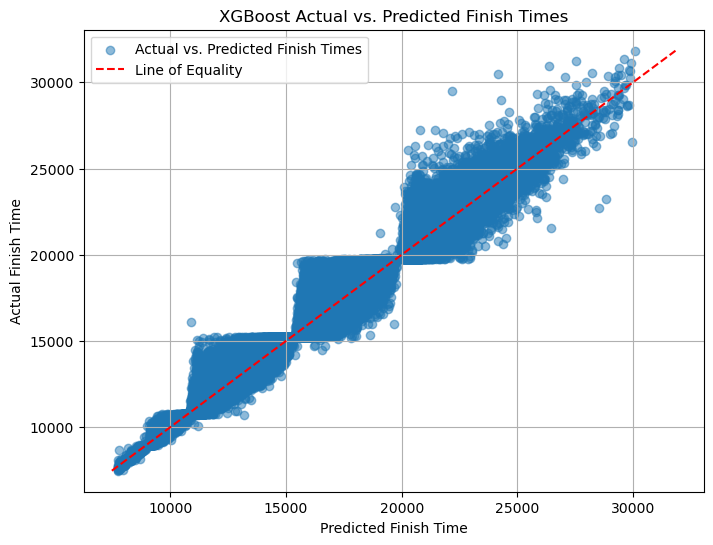

In [150]:
plot_performance_comparison(y_test_unscaled, y_pred_unscaled, title="XGBoost Actual vs. Predicted Finish Times")

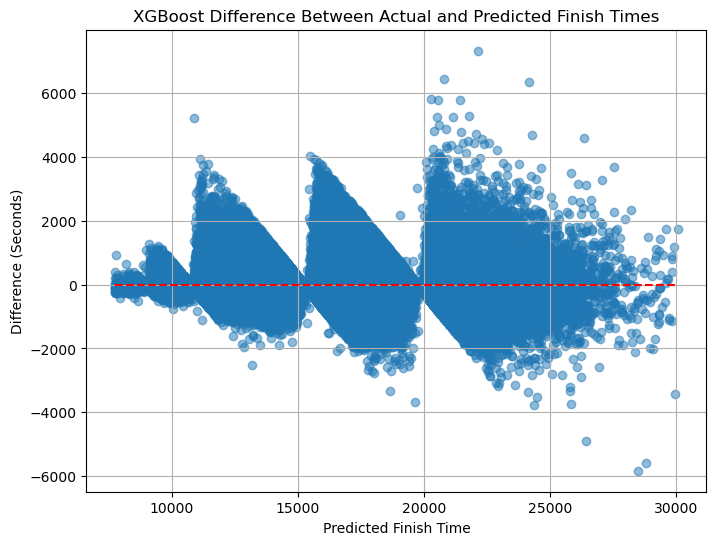

In [151]:
plot_performance_diff(y_test_unscaled, y_pred_unscaled, title="XGBoost Difference Between Actual and Predicted Finish Times")

In [136]:
xgb_rgr.save_model(f"{MODEL_REG_SAVE_NORMAL}XGBoost_marath_perf.json")

In [137]:
del xgb_rgr

In [159]:
# Run if the model and transformer are not loaded.
xgb_rgr = XGBRegressor()
xgb_rgr.load_model(f"{MODEL_REG_SAVE_NORMAL}XGBoost_marath_perf.json")
p_transformer = load_sklearn_model("Regression_PowerTransformer", MODEL_REG_SAVE_NORMAL)

Model loaded from Models/Regression/Normal/Regression_PowerTransformer.joblib


### Neural Network:

In [ ]:
# model = tf.keras.models.Sequential([